In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b50','k7_b50','k9_b50','k11_b50','k13_b50','k15_b50','k17_b50','k19_b50','k21_b50']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_e_k5_b50_k7_b50_k9_b50_k11_b50_k13_b50_k15_b50_k17_b50_k19_b50_k21_b50_t1_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(657450, 828)
(657450, 8)
validation
(74368, 828)
(74368, 8)
test
(91684, 828)
(91684, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/66 [..............................] - ETA: 1:48 - loss: 2.1447 - STD: 0.0965 - MAE: 0.2160

 4/66 [>.............................] - ETA: 1s - loss: 1.6503 - STD: 0.1341 - MAE: 0.1784  

 5/66 [=>............................] - ETA: 2s - loss: 1.5925 - STD: 0.1541 - MAE: 0.1685

 6/66 [=>............................] - ETA: 2s - loss: 1.5607 - STD: 0.1695 - MAE: 0.1613

 7/66 [==>...........................] - ETA: 2s - loss: 1.5326 - STD: 0.1808 - MAE: 0.1558

 8/66 [==>...........................] - ETA: 2s - loss: 1.5101 - STD: 0.1888 - MAE: 0.1519

 9/66 [===>..........................] - ETA: 2s - loss: 1.4942 - STD: 0.1939 - MAE: 0.1494

10/66 [===>..........................] - ETA: 2s - loss: 1.4798 - STD: 0.1967 - MAE: 0.1479

11/66 [====>.........................] - ETA: 2s - loss: 1.4673 - STD: 0.1976 - MAE: 0.1471

12/66 [====>.........................] - ETA: 2s - loss: 1.4559 - STD: 0.1973 - MAE: 0.1469

13/66 [====>.........................] - ETA: 2s - loss: 1.4478 - STD: 0.1962 - MAE: 0.1472

14/66 [=====>........................] - ETA: 2s - loss: 1.4401 - STD: 0.1948 - MAE: 0.1475

15/66 [=====>........................] - ETA: 2s - loss: 1.4344 - STD: 0.1934 - MAE: 0.1479

16/66 [======>.......................] - ETA: 2s - loss: 1.4279 - STD: 0.1921 - MAE: 0.1483

17/66 [======>.......................] - ETA: 2s - loss: 1.4224 - STD: 0.1911 - MAE: 0.1485

18/66 [=======>......................] - ETA: 2s - loss: 1.4171 - STD: 0.1904 - MAE: 0.1486

19/66 [=======>......................] - ETA: 2s - loss: 1.4130 - STD: 0.1902 - MAE: 0.1486

20/66 [========>.....................] - ETA: 2s - loss: 1.4064 - STD: 0.1902 - MAE: 0.1483

21/66 [========>.....................] - ETA: 2s - loss: 1.4031 - STD: 0.1905 - MAE: 0.1481

22/66 [=========>....................] - ETA: 2s - loss: 1.3995 - STD: 0.1910 - MAE: 0.1478

23/66 [=========>....................] - ETA: 2s - loss: 1.3967 - STD: 0.1916 - MAE: 0.1476

24/66 [=========>....................] - ETA: 2s - loss: 1.3933 - STD: 0.1923 - MAE: 0.1472

25/66 [==========>...................] - ETA: 2s - loss: 1.3908 - STD: 0.1929 - MAE: 0.1469

26/66 [==========>...................] - ETA: 2s - loss: 1.3877 - STD: 0.1935 - MAE: 0.1466

27/66 [===========>..................] - ETA: 2s - loss: 1.3846 - STD: 0.1939 - MAE: 0.1463

28/66 [===========>..................] - ETA: 2s - loss: 1.3820 - STD: 0.1942 - MAE: 0.1461

29/66 [============>.................] - ETA: 2s - loss: 1.3799 - STD: 0.1944 - MAE: 0.1460

30/66 [============>.................] - ETA: 1s - loss: 1.3776 - STD: 0.1944 - MAE: 0.1460

31/66 [=============>................] - ETA: 1s - loss: 1.3753 - STD: 0.1943 - MAE: 0.1459

32/66 [=============>................] - ETA: 1s - loss: 1.3737 - STD: 0.1941 - MAE: 0.1460

33/66 [==============>...............] - ETA: 1s - loss: 1.3720 - STD: 0.1938 - MAE: 0.1460

34/66 [==============>...............] - ETA: 1s - loss: 1.3707 - STD: 0.1935 - MAE: 0.1461

35/66 [==============>...............] - ETA: 1s - loss: 1.3694 - STD: 0.1932 - MAE: 0.1462

36/66 [===============>..............] - ETA: 1s - loss: 1.3675 - STD: 0.1929 - MAE: 0.1462

37/66 [===============>..............] - ETA: 1s - loss: 1.3663 - STD: 0.1927 - MAE: 0.1463

38/66 [================>.............] - ETA: 1s - loss: 1.3654 - STD: 0.1925 - MAE: 0.1463

39/66 [================>.............] - ETA: 1s - loss: 1.3641 - STD: 0.1925 - MAE: 0.1464

40/66 [=================>............] - ETA: 1s - loss: 1.3623 - STD: 0.1924 - MAE: 0.1463

41/66 [=================>............] - ETA: 1s - loss: 1.3610 - STD: 0.1925 - MAE: 0.1463

42/66 [==================>...........] - ETA: 1s - loss: 1.3600 - STD: 0.1925 - MAE: 0.1462

43/66 [==================>...........] - ETA: 1s - loss: 1.3589 - STD: 0.1926 - MAE: 0.1462

44/66 [===================>..........] - ETA: 1s - loss: 1.3573 - STD: 0.1927 - MAE: 0.1461

45/66 [===================>..........] - ETA: 1s - loss: 1.3558 - STD: 0.1928 - MAE: 0.1460

46/66 [===================>..........] - ETA: 1s - loss: 1.3545 - STD: 0.1928 - MAE: 0.1459

47/66 [====================>.........] - ETA: 1s - loss: 1.3533 - STD: 0.1929 - MAE: 0.1459

48/66 [====================>.........] - ETA: 0s - loss: 1.3529 - STD: 0.1929 - MAE: 0.1459

49/66 [=====================>........] - ETA: 0s - loss: 1.3518 - STD: 0.1929 - MAE: 0.1458

50/66 [=====================>........] - ETA: 1s - loss: 1.3510 - STD: 0.1929 - MAE: 0.1458

53/66 [=======================>......] - ETA: 0s - loss: 1.3485 - STD: 0.1927 - MAE: 0.1458

55/66 [========================>.....] - ETA: 0s - loss: 1.3468 - STD: 0.1925 - MAE: 0.1458

56/66 [========================>.....] - ETA: 0s - loss: 1.3462 - STD: 0.1925 - MAE: 0.1458

57/66 [========================>.....] - ETA: 0s - loss: 1.3454 - STD: 0.1925 - MAE: 0.1458

58/66 [=========================>....] - ETA: 0s - loss: 1.3446 - STD: 0.1924 - MAE: 0.1458

59/66 [=========================>....] - ETA: 0s - loss: 1.3438 - STD: 0.1924 - MAE: 0.1458

60/66 [==========================>...] - ETA: 0s - loss: 1.3432 - STD: 0.1924 - MAE: 0.1457

61/66 [==========================>...] - ETA: 0s - loss: 1.3426 - STD: 0.1925 - MAE: 0.1457

62/66 [===========================>..] - ETA: 0s - loss: 1.3421 - STD: 0.1925 - MAE: 0.1457

63/66 [===========================>..] - ETA: 0s - loss: 1.3417 - STD: 0.1925 - MAE: 0.1457

64/66 [============================>.] - ETA: 0s - loss: 1.3412 - STD: 0.1926 - MAE: 0.1456

65/66 [============================>.] - ETA: 0s - loss: 1.3406 - STD: 0.1926 - MAE: 0.1456

66/66 [==============================] - ETA: 0s - loss: 1.3400 - STD: 0.1926 - MAE: 0.1456

66/66 [==============================] - 7s 81ms/step - loss: 1.3400 - STD: 0.1926 - MAE: 0.1456 - val_loss: 1.2422 - val_STD: 0.1923 - val_MAE: 0.1416


Epoch 2/10000


 1/66 [..............................] - ETA: 5s - loss: 1.2879 - STD: 0.1923 - MAE: 0.1437

 2/66 [..............................] - ETA: 3s - loss: 1.3004 - STD: 0.1921 - MAE: 0.1443

 3/66 [>.............................] - ETA: 3s - loss: 1.3031 - STD: 0.1920 - MAE: 0.1446

 4/66 [>.............................] - ETA: 3s - loss: 1.3094 - STD: 0.1919 - MAE: 0.1450

 5/66 [=>............................] - ETA: 3s - loss: 1.3094 - STD: 0.1917 - MAE: 0.1451

 6/66 [=>............................] - ETA: 3s - loss: 1.3092 - STD: 0.1916 - MAE: 0.1452

 7/66 [==>...........................] - ETA: 3s - loss: 1.3103 - STD: 0.1914 - MAE: 0.1453

 8/66 [==>...........................] - ETA: 3s - loss: 1.3084 - STD: 0.1913 - MAE: 0.1453

 9/66 [===>..........................] - ETA: 3s - loss: 1.3071 - STD: 0.1912 - MAE: 0.1453

10/66 [===>..........................] - ETA: 3s - loss: 1.3062 - STD: 0.1911 - MAE: 0.1452

11/66 [====>.........................] - ETA: 3s - loss: 1.3040 - STD: 0.1911 - MAE: 0.1451

12/66 [====>.........................] - ETA: 3s - loss: 1.3029 - STD: 0.1913 - MAE: 0.1450

13/66 [====>.........................] - ETA: 3s - loss: 1.3034 - STD: 0.1915 - MAE: 0.1450

14/66 [=====>........................] - ETA: 3s - loss: 1.3037 - STD: 0.1917 - MAE: 0.1449

15/66 [=====>........................] - ETA: 3s - loss: 1.3035 - STD: 0.1919 - MAE: 0.1448

16/66 [======>.......................] - ETA: 2s - loss: 1.3036 - STD: 0.1920 - MAE: 0.1448

17/66 [======>.......................] - ETA: 2s - loss: 1.3018 - STD: 0.1921 - MAE: 0.1447

18/66 [=======>......................] - ETA: 2s - loss: 1.3028 - STD: 0.1921 - MAE: 0.1447

19/66 [=======>......................] - ETA: 2s - loss: 1.3027 - STD: 0.1921 - MAE: 0.1447

20/66 [========>.....................] - ETA: 2s - loss: 1.3021 - STD: 0.1920 - MAE: 0.1447

21/66 [========>.....................] - ETA: 2s - loss: 1.3017 - STD: 0.1920 - MAE: 0.1447

22/66 [=========>....................] - ETA: 2s - loss: 1.3016 - STD: 0.1919 - MAE: 0.1447

23/66 [=========>....................] - ETA: 2s - loss: 1.3009 - STD: 0.1919 - MAE: 0.1446

24/66 [=========>....................] - ETA: 2s - loss: 1.3009 - STD: 0.1919 - MAE: 0.1446

25/66 [==========>...................] - ETA: 2s - loss: 1.3006 - STD: 0.1920 - MAE: 0.1446

26/66 [==========>...................] - ETA: 2s - loss: 1.3005 - STD: 0.1920 - MAE: 0.1446

27/66 [===========>..................] - ETA: 2s - loss: 1.3004 - STD: 0.1920 - MAE: 0.1446

28/66 [===========>..................] - ETA: 2s - loss: 1.3001 - STD: 0.1920 - MAE: 0.1445

29/66 [============>.................] - ETA: 2s - loss: 1.2998 - STD: 0.1920 - MAE: 0.1445

30/66 [============>.................] - ETA: 2s - loss: 1.2990 - STD: 0.1920 - MAE: 0.1445

31/66 [=============>................] - ETA: 2s - loss: 1.2993 - STD: 0.1920 - MAE: 0.1445

32/66 [=============>................] - ETA: 1s - loss: 1.2987 - STD: 0.1920 - MAE: 0.1445

33/66 [==============>...............] - ETA: 1s - loss: 1.2980 - STD: 0.1919 - MAE: 0.1444

34/66 [==============>...............] - ETA: 1s - loss: 1.2974 - STD: 0.1919 - MAE: 0.1444

35/66 [==============>...............] - ETA: 1s - loss: 1.2976 - STD: 0.1919 - MAE: 0.1444

36/66 [===============>..............] - ETA: 1s - loss: 1.2977 - STD: 0.1919 - MAE: 0.1444

37/66 [===============>..............] - ETA: 1s - loss: 1.2965 - STD: 0.1918 - MAE: 0.1444

38/66 [================>.............] - ETA: 1s - loss: 1.2961 - STD: 0.1918 - MAE: 0.1444

39/66 [================>.............] - ETA: 1s - loss: 1.2959 - STD: 0.1919 - MAE: 0.1443

40/66 [=================>............] - ETA: 1s - loss: 1.2948 - STD: 0.1919 - MAE: 0.1443

41/66 [=================>............] - ETA: 1s - loss: 1.2944 - STD: 0.1920 - MAE: 0.1442

42/66 [==================>...........] - ETA: 1s - loss: 1.2937 - STD: 0.1920 - MAE: 0.1441

43/66 [==================>...........] - ETA: 1s - loss: 1.2934 - STD: 0.1921 - MAE: 0.1441

44/66 [===================>..........] - ETA: 1s - loss: 1.2930 - STD: 0.1921 - MAE: 0.1441

45/66 [===================>..........] - ETA: 1s - loss: 1.2925 - STD: 0.1921 - MAE: 0.1440

46/66 [===================>..........] - ETA: 1s - loss: 1.2918 - STD: 0.1921 - MAE: 0.1440

47/66 [====================>.........] - ETA: 1s - loss: 1.2913 - STD: 0.1921 - MAE: 0.1439

48/66 [====================>.........] - ETA: 1s - loss: 1.2909 - STD: 0.1921 - MAE: 0.1439

49/66 [=====================>........] - ETA: 0s - loss: 1.2908 - STD: 0.1922 - MAE: 0.1439

50/66 [=====================>........] - ETA: 0s - loss: 1.2903 - STD: 0.1922 - MAE: 0.1439

51/66 [======================>.......] - ETA: 0s - loss: 1.2900 - STD: 0.1922 - MAE: 0.1438

52/66 [======================>.......] - ETA: 0s - loss: 1.2895 - STD: 0.1922 - MAE: 0.1438

53/66 [=======================>......] - ETA: 0s - loss: 1.2894 - STD: 0.1922 - MAE: 0.1438

54/66 [=======================>......] - ETA: 0s - loss: 1.2892 - STD: 0.1923 - MAE: 0.1437

55/66 [========================>.....] - ETA: 0s - loss: 1.2890 - STD: 0.1923 - MAE: 0.1437

56/66 [========================>.....] - ETA: 0s - loss: 1.2888 - STD: 0.1923 - MAE: 0.1437

57/66 [========================>.....] - ETA: 0s - loss: 1.2885 - STD: 0.1923 - MAE: 0.1437

58/66 [=========================>....] - ETA: 0s - loss: 1.2884 - STD: 0.1923 - MAE: 0.1437

59/66 [=========================>....] - ETA: 0s - loss: 1.2878 - STD: 0.1923 - MAE: 0.1437

60/66 [==========================>...] - ETA: 0s - loss: 1.2875 - STD: 0.1923 - MAE: 0.1436

61/66 [==========================>...] - ETA: 0s - loss: 1.2871 - STD: 0.1923 - MAE: 0.1436

62/66 [===========================>..] - ETA: 0s - loss: 1.2868 - STD: 0.1924 - MAE: 0.1436

63/66 [===========================>..] - ETA: 0s - loss: 1.2862 - STD: 0.1924 - MAE: 0.1435

65/66 [============================>.] - ETA: 0s - loss: 1.2855 - STD: 0.1926 - MAE: 0.1434

66/66 [==============================] - ETA: 0s - loss: 1.2849 - STD: 0.1927 - MAE: 0.1433

66/66 [==============================] - 4s 61ms/step - loss: 1.2849 - STD: 0.1927 - MAE: 0.1433 - val_loss: 1.1748 - val_STD: 0.1999 - val_MAE: 0.1343


Epoch 3/10000


 1/66 [..............................] - ETA: 5s - loss: 1.2531 - STD: 0.1942 - MAE: 0.1409

 3/66 [>.............................] - ETA: 3s - loss: 1.2522 - STD: 0.1961 - MAE: 0.1403

 4/66 [>.............................] - ETA: 3s - loss: 1.2475 - STD: 0.1968 - MAE: 0.1398

 5/66 [=>............................] - ETA: 3s - loss: 1.2486 - STD: 0.1976 - MAE: 0.1396

 6/66 [=>............................] - ETA: 3s - loss: 1.2497 - STD: 0.1974 - MAE: 0.1397

 7/66 [==>...........................] - ETA: 3s - loss: 1.2494 - STD: 0.1970 - MAE: 0.1398

 8/66 [==>...........................] - ETA: 3s - loss: 1.2493 - STD: 0.1970 - MAE: 0.1398

 9/66 [===>..........................] - ETA: 3s - loss: 1.2509 - STD: 0.1973 - MAE: 0.1398

10/66 [===>..........................] - ETA: 3s - loss: 1.2513 - STD: 0.1976 - MAE: 0.1398

11/66 [====>.........................] - ETA: 3s - loss: 1.2500 - STD: 0.1974 - MAE: 0.1398

12/66 [====>.........................] - ETA: 3s - loss: 1.2489 - STD: 0.1973 - MAE: 0.1398

13/66 [====>.........................] - ETA: 3s - loss: 1.2489 - STD: 0.1974 - MAE: 0.1398

14/66 [=====>........................] - ETA: 3s - loss: 1.2484 - STD: 0.1976 - MAE: 0.1397

15/66 [=====>........................] - ETA: 3s - loss: 1.2473 - STD: 0.1976 - MAE: 0.1396

16/66 [======>.......................] - ETA: 2s - loss: 1.2458 - STD: 0.1976 - MAE: 0.1395

17/66 [======>.......................] - ETA: 2s - loss: 1.2456 - STD: 0.1978 - MAE: 0.1395

18/66 [=======>......................] - ETA: 2s - loss: 1.2461 - STD: 0.1980 - MAE: 0.1395

19/66 [=======>......................] - ETA: 2s - loss: 1.2457 - STD: 0.1979 - MAE: 0.1395

20/66 [========>.....................] - ETA: 2s - loss: 1.2447 - STD: 0.1979 - MAE: 0.1394

21/66 [========>.....................] - ETA: 2s - loss: 1.2445 - STD: 0.1981 - MAE: 0.1393

22/66 [=========>....................] - ETA: 2s - loss: 1.2439 - STD: 0.1983 - MAE: 0.1392

23/66 [=========>....................] - ETA: 2s - loss: 1.2427 - STD: 0.1982 - MAE: 0.1392

24/66 [=========>....................] - ETA: 2s - loss: 1.2419 - STD: 0.1982 - MAE: 0.1392

25/66 [==========>...................] - ETA: 2s - loss: 1.2413 - STD: 0.1983 - MAE: 0.1392

26/66 [==========>...................] - ETA: 2s - loss: 1.2405 - STD: 0.1985 - MAE: 0.1391

27/66 [===========>..................] - ETA: 2s - loss: 1.2390 - STD: 0.1985 - MAE: 0.1390

28/66 [===========>..................] - ETA: 2s - loss: 1.2377 - STD: 0.1986 - MAE: 0.1389

29/66 [============>.................] - ETA: 2s - loss: 1.2369 - STD: 0.1988 - MAE: 0.1388

30/66 [============>.................] - ETA: 2s - loss: 1.2359 - STD: 0.1988 - MAE: 0.1388

31/66 [=============>................] - ETA: 2s - loss: 1.2352 - STD: 0.1988 - MAE: 0.1388

32/66 [=============>................] - ETA: 2s - loss: 1.2338 - STD: 0.1990 - MAE: 0.1386

33/66 [==============>...............] - ETA: 1s - loss: 1.2329 - STD: 0.1991 - MAE: 0.1385

34/66 [==============>...............] - ETA: 1s - loss: 1.2319 - STD: 0.1990 - MAE: 0.1386

35/66 [==============>...............] - ETA: 1s - loss: 1.2313 - STD: 0.1991 - MAE: 0.1385

36/66 [===============>..............] - ETA: 1s - loss: 1.2304 - STD: 0.1991 - MAE: 0.1385

37/66 [===============>..............] - ETA: 1s - loss: 1.2299 - STD: 0.1991 - MAE: 0.1385

38/66 [================>.............] - ETA: 1s - loss: 1.2288 - STD: 0.1991 - MAE: 0.1384

39/66 [================>.............] - ETA: 1s - loss: 1.2283 - STD: 0.1993 - MAE: 0.1384

40/66 [=================>............] - ETA: 1s - loss: 1.2269 - STD: 0.1992 - MAE: 0.1384

41/66 [=================>............] - ETA: 1s - loss: 1.2255 - STD: 0.1993 - MAE: 0.1383

42/66 [==================>...........] - ETA: 1s - loss: 1.2244 - STD: 0.1994 - MAE: 0.1382

43/66 [==================>...........] - ETA: 1s - loss: 1.2230 - STD: 0.1994 - MAE: 0.1382

44/66 [===================>..........] - ETA: 1s - loss: 1.2217 - STD: 0.1997 - MAE: 0.1380

45/66 [===================>..........] - ETA: 1s - loss: 1.2203 - STD: 0.1997 - MAE: 0.1379

46/66 [===================>..........] - ETA: 1s - loss: 1.2193 - STD: 0.1998 - MAE: 0.1379

47/66 [====================>.........] - ETA: 1s - loss: 1.2186 - STD: 0.2000 - MAE: 0.1378

48/66 [====================>.........] - ETA: 1s - loss: 1.2180 - STD: 0.1999 - MAE: 0.1378

49/66 [=====================>........] - ETA: 1s - loss: 1.2172 - STD: 0.1998 - MAE: 0.1378

50/66 [=====================>........] - ETA: 0s - loss: 1.2162 - STD: 0.1999 - MAE: 0.1377

51/66 [======================>.......] - ETA: 0s - loss: 1.2150 - STD: 0.2000 - MAE: 0.1377

52/66 [======================>.......] - ETA: 0s - loss: 1.2140 - STD: 0.1999 - MAE: 0.1377

53/66 [=======================>......] - ETA: 0s - loss: 1.2127 - STD: 0.2001 - MAE: 0.1376

54/66 [=======================>......] - ETA: 0s - loss: 1.2114 - STD: 0.2003 - MAE: 0.1375

55/66 [========================>.....] - ETA: 0s - loss: 1.2104 - STD: 0.2003 - MAE: 0.1374

56/66 [========================>.....] - ETA: 0s - loss: 1.2092 - STD: 0.2003 - MAE: 0.1374

57/66 [========================>.....] - ETA: 0s - loss: 1.2084 - STD: 0.2004 - MAE: 0.1373

58/66 [=========================>....] - ETA: 0s - loss: 1.2073 - STD: 0.2004 - MAE: 0.1373

59/66 [=========================>....] - ETA: 0s - loss: 1.2063 - STD: 0.2004 - MAE: 0.1373

60/66 [==========================>...] - ETA: 0s - loss: 1.2053 - STD: 0.2005 - MAE: 0.1372

61/66 [==========================>...] - ETA: 0s - loss: 1.2044 - STD: 0.2005 - MAE: 0.1372

62/66 [===========================>..] - ETA: 0s - loss: 1.2035 - STD: 0.2005 - MAE: 0.1372

63/66 [===========================>..] - ETA: 0s - loss: 1.2029 - STD: 0.2005 - MAE: 0.1372

64/66 [============================>.] - ETA: 0s - loss: 1.2021 - STD: 0.2006 - MAE: 0.1371

65/66 [============================>.] - ETA: 0s - loss: 1.2012 - STD: 0.2006 - MAE: 0.1371

66/66 [==============================] - ETA: 0s - loss: 1.1998 - STD: 0.2006 - MAE: 0.1370

66/66 [==============================] - 4s 63ms/step - loss: 1.1998 - STD: 0.2006 - MAE: 0.1370 - val_loss: 1.0791 - val_STD: 0.2117 - val_MAE: 0.1263


Epoch 4/10000


 1/66 [..............................] - ETA: 6s - loss: 1.1455 - STD: 0.2103 - MAE: 0.1318

 2/66 [..............................] - ETA: 3s - loss: 1.1412 - STD: 0.2073 - MAE: 0.1328

 3/66 [>.............................] - ETA: 3s - loss: 1.1333 - STD: 0.2051 - MAE: 0.1334

 4/66 [>.............................] - ETA: 3s - loss: 1.1300 - STD: 0.2058 - MAE: 0.1331

 5/66 [=>............................] - ETA: 3s - loss: 1.1277 - STD: 0.2062 - MAE: 0.1328

 6/66 [=>............................] - ETA: 3s - loss: 1.1263 - STD: 0.2055 - MAE: 0.1330

 7/66 [==>...........................] - ETA: 3s - loss: 1.1260 - STD: 0.2049 - MAE: 0.1333

 8/66 [==>...........................] - ETA: 3s - loss: 1.1241 - STD: 0.2050 - MAE: 0.1332

 9/66 [===>..........................] - ETA: 3s - loss: 1.1255 - STD: 0.2055 - MAE: 0.1330

10/66 [===>..........................] - ETA: 3s - loss: 1.1243 - STD: 0.2053 - MAE: 0.1331

11/66 [====>.........................] - ETA: 3s - loss: 1.1227 - STD: 0.2051 - MAE: 0.1331

12/66 [====>.........................] - ETA: 3s - loss: 1.1216 - STD: 0.2051 - MAE: 0.1331

13/66 [====>.........................] - ETA: 3s - loss: 1.1198 - STD: 0.2052 - MAE: 0.1329

14/66 [=====>........................] - ETA: 3s - loss: 1.1200 - STD: 0.2053 - MAE: 0.1329

15/66 [=====>........................] - ETA: 2s - loss: 1.1177 - STD: 0.2054 - MAE: 0.1328

16/66 [======>.......................] - ETA: 2s - loss: 1.1167 - STD: 0.2055 - MAE: 0.1327

17/66 [======>.......................] - ETA: 2s - loss: 1.1154 - STD: 0.2053 - MAE: 0.1327

18/66 [=======>......................] - ETA: 2s - loss: 1.1146 - STD: 0.2055 - MAE: 0.1326

19/66 [=======>......................] - ETA: 2s - loss: 1.1137 - STD: 0.2060 - MAE: 0.1324

20/66 [========>.....................] - ETA: 2s - loss: 1.1127 - STD: 0.2055 - MAE: 0.1325

21/66 [========>.....................] - ETA: 2s - loss: 1.1117 - STD: 0.2052 - MAE: 0.1326

22/66 [=========>....................] - ETA: 2s - loss: 1.1113 - STD: 0.2059 - MAE: 0.1323

23/66 [=========>....................] - ETA: 2s - loss: 1.1100 - STD: 0.2058 - MAE: 0.1323

24/66 [=========>....................] - ETA: 2s - loss: 1.1090 - STD: 0.2055 - MAE: 0.1324

25/66 [==========>...................] - ETA: 2s - loss: 1.1085 - STD: 0.2058 - MAE: 0.1322

26/66 [==========>...................] - ETA: 2s - loss: 1.1074 - STD: 0.2059 - MAE: 0.1321

27/66 [===========>..................] - ETA: 2s - loss: 1.1064 - STD: 0.2060 - MAE: 0.1321

28/66 [===========>..................] - ETA: 2s - loss: 1.1051 - STD: 0.2061 - MAE: 0.1320

29/66 [============>.................] - ETA: 2s - loss: 1.1044 - STD: 0.2063 - MAE: 0.1319

30/66 [============>.................] - ETA: 2s - loss: 1.1036 - STD: 0.2061 - MAE: 0.1319

31/66 [=============>................] - ETA: 2s - loss: 1.1021 - STD: 0.2063 - MAE: 0.1318

32/66 [=============>................] - ETA: 1s - loss: 1.1007 - STD: 0.2067 - MAE: 0.1316

33/66 [==============>...............] - ETA: 1s - loss: 1.0998 - STD: 0.2063 - MAE: 0.1317

34/66 [==============>...............] - ETA: 1s - loss: 1.0995 - STD: 0.2066 - MAE: 0.1315

35/66 [==============>...............] - ETA: 1s - loss: 1.0991 - STD: 0.2067 - MAE: 0.1315

36/66 [===============>..............] - ETA: 1s - loss: 1.0980 - STD: 0.2064 - MAE: 0.1315

37/66 [===============>..............] - ETA: 1s - loss: 1.0967 - STD: 0.2069 - MAE: 0.1313

39/66 [================>.............] - ETA: 1s - loss: 1.0954 - STD: 0.2068 - MAE: 0.1313

40/66 [=================>............] - ETA: 1s - loss: 1.0948 - STD: 0.2071 - MAE: 0.1311

41/66 [=================>............] - ETA: 1s - loss: 1.0940 - STD: 0.2071 - MAE: 0.1311

42/66 [==================>...........] - ETA: 1s - loss: 1.0929 - STD: 0.2070 - MAE: 0.1311

43/66 [==================>...........] - ETA: 1s - loss: 1.0918 - STD: 0.2074 - MAE: 0.1309

44/66 [===================>..........] - ETA: 1s - loss: 1.0907 - STD: 0.2074 - MAE: 0.1308

45/66 [===================>..........] - ETA: 1s - loss: 1.0899 - STD: 0.2074 - MAE: 0.1308

46/66 [===================>..........] - ETA: 1s - loss: 1.0891 - STD: 0.2076 - MAE: 0.1306

47/66 [====================>.........] - ETA: 1s - loss: 1.0879 - STD: 0.2077 - MAE: 0.1306

48/66 [====================>.........] - ETA: 1s - loss: 1.0866 - STD: 0.2077 - MAE: 0.1305

49/66 [=====================>........] - ETA: 0s - loss: 1.0859 - STD: 0.2081 - MAE: 0.1303

50/66 [=====================>........] - ETA: 0s - loss: 1.0852 - STD: 0.2080 - MAE: 0.1303

51/66 [======================>.......] - ETA: 0s - loss: 1.0841 - STD: 0.2081 - MAE: 0.1302

52/66 [======================>.......] - ETA: 0s - loss: 1.0837 - STD: 0.2085 - MAE: 0.1300

53/66 [=======================>......] - ETA: 0s - loss: 1.0829 - STD: 0.2083 - MAE: 0.1301

54/66 [=======================>......] - ETA: 0s - loss: 1.0823 - STD: 0.2083 - MAE: 0.1300

55/66 [========================>.....] - ETA: 0s - loss: 1.0815 - STD: 0.2086 - MAE: 0.1299

56/66 [========================>.....] - ETA: 0s - loss: 1.0807 - STD: 0.2086 - MAE: 0.1299

57/66 [========================>.....] - ETA: 0s - loss: 1.0798 - STD: 0.2086 - MAE: 0.1298

58/66 [=========================>....] - ETA: 0s - loss: 1.0792 - STD: 0.2088 - MAE: 0.1297

59/66 [=========================>....] - ETA: 0s - loss: 1.0783 - STD: 0.2089 - MAE: 0.1296

60/66 [==========================>...] - ETA: 0s - loss: 1.0773 - STD: 0.2089 - MAE: 0.1296

61/66 [==========================>...] - ETA: 0s - loss: 1.0764 - STD: 0.2091 - MAE: 0.1295

62/66 [===========================>..] - ETA: 0s - loss: 1.0755 - STD: 0.2092 - MAE: 0.1294

63/66 [===========================>..] - ETA: 0s - loss: 1.0744 - STD: 0.2093 - MAE: 0.1293

64/66 [============================>.] - ETA: 0s - loss: 1.0736 - STD: 0.2094 - MAE: 0.1292

65/66 [============================>.] - ETA: 0s - loss: 1.0728 - STD: 0.2095 - MAE: 0.1292

66/66 [==============================] - ETA: 0s - loss: 1.0721 - STD: 0.2096 - MAE: 0.1291

66/66 [==============================] - 4s 61ms/step - loss: 1.0721 - STD: 0.2096 - MAE: 0.1291 - val_loss: 0.9717 - val_STD: 0.2189 - val_MAE: 0.1185


Epoch 5/10000


 1/66 [..............................] - ETA: 6s - loss: 1.0023 - STD: 0.2205 - MAE: 0.1212

 2/66 [..............................] - ETA: 3s - loss: 1.0142 - STD: 0.2183 - MAE: 0.1227

 3/66 [>.............................] - ETA: 3s - loss: 1.0125 - STD: 0.2159 - MAE: 0.1236

 4/66 [>.............................] - ETA: 3s - loss: 1.0115 - STD: 0.2173 - MAE: 0.1230

 5/66 [=>............................] - ETA: 3s - loss: 1.0126 - STD: 0.2172 - MAE: 0.1232

 6/66 [=>............................] - ETA: 3s - loss: 1.0106 - STD: 0.2163 - MAE: 0.1234

 7/66 [==>...........................] - ETA: 3s - loss: 1.0114 - STD: 0.2171 - MAE: 0.1231

 8/66 [==>...........................] - ETA: 3s - loss: 1.0119 - STD: 0.2173 - MAE: 0.1231

 9/66 [===>..........................] - ETA: 3s - loss: 1.0099 - STD: 0.2163 - MAE: 0.1234

10/66 [===>..........................] - ETA: 3s - loss: 1.0098 - STD: 0.2175 - MAE: 0.1230

11/66 [====>.........................] - ETA: 3s - loss: 1.0097 - STD: 0.2169 - MAE: 0.1232

12/66 [====>.........................] - ETA: 3s - loss: 1.0099 - STD: 0.2162 - MAE: 0.1235

13/66 [====>.........................] - ETA: 3s - loss: 1.0098 - STD: 0.2173 - MAE: 0.1230

14/66 [=====>........................] - ETA: 3s - loss: 1.0085 - STD: 0.2171 - MAE: 0.1230

15/66 [=====>........................] - ETA: 3s - loss: 1.0076 - STD: 0.2167 - MAE: 0.1231

16/66 [======>.......................] - ETA: 2s - loss: 1.0076 - STD: 0.2175 - MAE: 0.1228

17/66 [======>.......................] - ETA: 2s - loss: 1.0065 - STD: 0.2171 - MAE: 0.1229

18/66 [=======>......................] - ETA: 2s - loss: 1.0050 - STD: 0.2168 - MAE: 0.1230

19/66 [=======>......................] - ETA: 2s - loss: 1.0044 - STD: 0.2175 - MAE: 0.1226

20/66 [========>.....................] - ETA: 2s - loss: 1.0033 - STD: 0.2174 - MAE: 0.1226

21/66 [========>.....................] - ETA: 2s - loss: 1.0021 - STD: 0.2172 - MAE: 0.1227

22/66 [=========>....................] - ETA: 2s - loss: 1.0025 - STD: 0.2177 - MAE: 0.1225

23/66 [=========>....................] - ETA: 2s - loss: 1.0018 - STD: 0.2174 - MAE: 0.1225

24/66 [=========>....................] - ETA: 2s - loss: 1.0014 - STD: 0.2172 - MAE: 0.1226

25/66 [==========>...................] - ETA: 2s - loss: 1.0011 - STD: 0.2176 - MAE: 0.1224

26/66 [==========>...................] - ETA: 2s - loss: 1.0004 - STD: 0.2176 - MAE: 0.1224

27/66 [===========>..................] - ETA: 2s - loss: 0.9998 - STD: 0.2174 - MAE: 0.1225

28/66 [===========>..................] - ETA: 2s - loss: 0.9989 - STD: 0.2177 - MAE: 0.1223

29/66 [============>.................] - ETA: 2s - loss: 0.9988 - STD: 0.2179 - MAE: 0.1222

30/66 [============>.................] - ETA: 2s - loss: 0.9984 - STD: 0.2175 - MAE: 0.1224

31/66 [=============>................] - ETA: 2s - loss: 0.9973 - STD: 0.2177 - MAE: 0.1222

32/66 [=============>................] - ETA: 2s - loss: 0.9972 - STD: 0.2182 - MAE: 0.1220

33/66 [==============>...............] - ETA: 1s - loss: 0.9971 - STD: 0.2177 - MAE: 0.1222

34/66 [==============>...............] - ETA: 1s - loss: 0.9962 - STD: 0.2177 - MAE: 0.1222

35/66 [==============>...............] - ETA: 1s - loss: 0.9962 - STD: 0.2182 - MAE: 0.1220

36/66 [===============>..............] - ETA: 1s - loss: 0.9956 - STD: 0.2180 - MAE: 0.1220

37/66 [===============>..............] - ETA: 1s - loss: 0.9948 - STD: 0.2178 - MAE: 0.1220

38/66 [================>.............] - ETA: 1s - loss: 0.9941 - STD: 0.2183 - MAE: 0.1218

39/66 [================>.............] - ETA: 1s - loss: 0.9937 - STD: 0.2184 - MAE: 0.1217

40/66 [=================>............] - ETA: 1s - loss: 0.9929 - STD: 0.2181 - MAE: 0.1218

41/66 [=================>............] - ETA: 1s - loss: 0.9928 - STD: 0.2183 - MAE: 0.1218

42/66 [==================>...........] - ETA: 1s - loss: 0.9920 - STD: 0.2186 - MAE: 0.1216

43/66 [==================>...........] - ETA: 1s - loss: 0.9912 - STD: 0.2186 - MAE: 0.1216

44/66 [===================>..........] - ETA: 1s - loss: 0.9908 - STD: 0.2184 - MAE: 0.1216

45/66 [===================>..........] - ETA: 1s - loss: 0.9902 - STD: 0.2185 - MAE: 0.1215

46/66 [===================>..........] - ETA: 1s - loss: 0.9895 - STD: 0.2188 - MAE: 0.1214

47/66 [====================>.........] - ETA: 1s - loss: 0.9888 - STD: 0.2187 - MAE: 0.1214

48/66 [====================>.........] - ETA: 1s - loss: 0.9883 - STD: 0.2186 - MAE: 0.1214

49/66 [=====================>........] - ETA: 0s - loss: 0.9876 - STD: 0.2188 - MAE: 0.1213

50/66 [=====================>........] - ETA: 0s - loss: 0.9869 - STD: 0.2189 - MAE: 0.1212

51/66 [======================>.......] - ETA: 0s - loss: 0.9865 - STD: 0.2189 - MAE: 0.1212

52/66 [======================>.......] - ETA: 0s - loss: 0.9859 - STD: 0.2190 - MAE: 0.1212

53/66 [=======================>......] - ETA: 0s - loss: 0.9849 - STD: 0.2192 - MAE: 0.1210

54/66 [=======================>......] - ETA: 0s - loss: 0.9842 - STD: 0.2192 - MAE: 0.1210

55/66 [========================>.....] - ETA: 0s - loss: 0.9837 - STD: 0.2192 - MAE: 0.1210

56/66 [========================>.....] - ETA: 0s - loss: 0.9833 - STD: 0.2194 - MAE: 0.1208

57/66 [========================>.....] - ETA: 0s - loss: 0.9829 - STD: 0.2194 - MAE: 0.1208

58/66 [=========================>....] - ETA: 0s - loss: 0.9824 - STD: 0.2193 - MAE: 0.1209

59/66 [=========================>....] - ETA: 0s - loss: 0.9817 - STD: 0.2195 - MAE: 0.1207

60/66 [==========================>...] - ETA: 0s - loss: 0.9808 - STD: 0.2196 - MAE: 0.1207

61/66 [==========================>...] - ETA: 0s - loss: 0.9802 - STD: 0.2196 - MAE: 0.1207

63/66 [===========================>..] - ETA: 0s - loss: 0.9792 - STD: 0.2197 - MAE: 0.1205

64/66 [============================>.] - ETA: 0s - loss: 0.9783 - STD: 0.2198 - MAE: 0.1205

65/66 [============================>.] - ETA: 0s - loss: 0.9777 - STD: 0.2198 - MAE: 0.1205

66/66 [==============================] - ETA: 0s - loss: 0.9768 - STD: 0.2198 - MAE: 0.1204

66/66 [==============================] - 4s 61ms/step - loss: 0.9768 - STD: 0.2198 - MAE: 0.1204 - val_loss: 0.8949 - val_STD: 0.2275 - val_MAE: 0.1115


Epoch 6/10000


 1/66 [..............................] - ETA: 6s - loss: 0.9312 - STD: 0.2297 - MAE: 0.1141

 2/66 [..............................] - ETA: 3s - loss: 0.9285 - STD: 0.2240 - MAE: 0.1166

 3/66 [>.............................] - ETA: 3s - loss: 0.9285 - STD: 0.2236 - MAE: 0.1168

 4/66 [>.............................] - ETA: 3s - loss: 0.9309 - STD: 0.2248 - MAE: 0.1164

 5/66 [=>............................] - ETA: 3s - loss: 0.9290 - STD: 0.2247 - MAE: 0.1162

 6/66 [=>............................] - ETA: 3s - loss: 0.9283 - STD: 0.2243 - MAE: 0.1164

 7/66 [==>...........................] - ETA: 3s - loss: 0.9279 - STD: 0.2248 - MAE: 0.1162

 8/66 [==>...........................] - ETA: 3s - loss: 0.9278 - STD: 0.2251 - MAE: 0.1161

 9/66 [===>..........................] - ETA: 3s - loss: 0.9239 - STD: 0.2249 - MAE: 0.1160

10/66 [===>..........................] - ETA: 3s - loss: 0.9243 - STD: 0.2256 - MAE: 0.1157

11/66 [====>.........................] - ETA: 3s - loss: 0.9225 - STD: 0.2255 - MAE: 0.1156

12/66 [====>.........................] - ETA: 3s - loss: 0.9207 - STD: 0.2255 - MAE: 0.1156

13/66 [====>.........................] - ETA: 3s - loss: 0.9198 - STD: 0.2259 - MAE: 0.1153

14/66 [=====>........................] - ETA: 3s - loss: 0.9202 - STD: 0.2257 - MAE: 0.1155

15/66 [=====>........................] - ETA: 3s - loss: 0.9192 - STD: 0.2255 - MAE: 0.1155

16/66 [======>.......................] - ETA: 2s - loss: 0.9191 - STD: 0.2259 - MAE: 0.1153

17/66 [======>.......................] - ETA: 2s - loss: 0.9187 - STD: 0.2259 - MAE: 0.1154

18/66 [=======>......................] - ETA: 2s - loss: 0.9185 - STD: 0.2256 - MAE: 0.1155

19/66 [=======>......................] - ETA: 2s - loss: 0.9191 - STD: 0.2258 - MAE: 0.1154

20/66 [========>.....................] - ETA: 2s - loss: 0.9184 - STD: 0.2259 - MAE: 0.1154

21/66 [========>.....................] - ETA: 2s - loss: 0.9178 - STD: 0.2257 - MAE: 0.1155

22/66 [=========>....................] - ETA: 2s - loss: 0.9177 - STD: 0.2257 - MAE: 0.1155

23/66 [=========>....................] - ETA: 2s - loss: 0.9172 - STD: 0.2260 - MAE: 0.1153

24/66 [=========>....................] - ETA: 2s - loss: 0.9176 - STD: 0.2257 - MAE: 0.1155

25/66 [==========>...................] - ETA: 2s - loss: 0.9175 - STD: 0.2256 - MAE: 0.1156

26/66 [==========>...................] - ETA: 2s - loss: 0.9169 - STD: 0.2260 - MAE: 0.1153

27/66 [===========>..................] - ETA: 2s - loss: 0.9161 - STD: 0.2258 - MAE: 0.1154

28/66 [===========>..................] - ETA: 2s - loss: 0.9158 - STD: 0.2256 - MAE: 0.1155

29/66 [============>.................] - ETA: 2s - loss: 0.9152 - STD: 0.2260 - MAE: 0.1153

30/66 [============>.................] - ETA: 2s - loss: 0.9143 - STD: 0.2260 - MAE: 0.1152

31/66 [=============>................] - ETA: 2s - loss: 0.9142 - STD: 0.2257 - MAE: 0.1154

32/66 [=============>................] - ETA: 2s - loss: 0.9134 - STD: 0.2258 - MAE: 0.1153

33/66 [==============>...............] - ETA: 1s - loss: 0.9136 - STD: 0.2261 - MAE: 0.1152

34/66 [==============>...............] - ETA: 1s - loss: 0.9129 - STD: 0.2259 - MAE: 0.1153

35/66 [==============>...............] - ETA: 1s - loss: 0.9124 - STD: 0.2259 - MAE: 0.1152

36/66 [===============>..............] - ETA: 1s - loss: 0.9117 - STD: 0.2261 - MAE: 0.1151

37/66 [===============>..............] - ETA: 1s - loss: 0.9112 - STD: 0.2260 - MAE: 0.1151

38/66 [================>.............] - ETA: 1s - loss: 0.9114 - STD: 0.2259 - MAE: 0.1152

39/66 [================>.............] - ETA: 1s - loss: 0.9105 - STD: 0.2260 - MAE: 0.1151

40/66 [=================>............] - ETA: 1s - loss: 0.9106 - STD: 0.2262 - MAE: 0.1151

41/66 [=================>............] - ETA: 1s - loss: 0.9105 - STD: 0.2261 - MAE: 0.1151

42/66 [==================>...........] - ETA: 1s - loss: 0.9096 - STD: 0.2261 - MAE: 0.1151

43/66 [==================>...........] - ETA: 1s - loss: 0.9093 - STD: 0.2262 - MAE: 0.1150

44/66 [===================>..........] - ETA: 1s - loss: 0.9092 - STD: 0.2263 - MAE: 0.1149

45/66 [===================>..........] - ETA: 1s - loss: 0.9088 - STD: 0.2262 - MAE: 0.1150

46/66 [===================>..........] - ETA: 1s - loss: 0.9082 - STD: 0.2262 - MAE: 0.1149

47/66 [====================>.........] - ETA: 1s - loss: 0.9079 - STD: 0.2265 - MAE: 0.1148

48/66 [====================>.........] - ETA: 1s - loss: 0.9079 - STD: 0.2264 - MAE: 0.1149

49/66 [=====================>........] - ETA: 0s - loss: 0.9074 - STD: 0.2263 - MAE: 0.1149

50/66 [=====================>........] - ETA: 0s - loss: 0.9071 - STD: 0.2265 - MAE: 0.1148

51/66 [======================>.......] - ETA: 0s - loss: 0.9067 - STD: 0.2266 - MAE: 0.1147

52/66 [======================>.......] - ETA: 0s - loss: 0.9066 - STD: 0.2264 - MAE: 0.1148

53/66 [=======================>......] - ETA: 0s - loss: 0.9060 - STD: 0.2265 - MAE: 0.1147

54/66 [=======================>......] - ETA: 0s - loss: 0.9058 - STD: 0.2268 - MAE: 0.1146

55/66 [========================>.....] - ETA: 0s - loss: 0.9057 - STD: 0.2266 - MAE: 0.1147

56/66 [========================>.....] - ETA: 0s - loss: 0.9052 - STD: 0.2265 - MAE: 0.1147

57/66 [========================>.....] - ETA: 0s - loss: 0.9051 - STD: 0.2267 - MAE: 0.1146

58/66 [=========================>....] - ETA: 0s - loss: 0.9047 - STD: 0.2268 - MAE: 0.1146

59/66 [=========================>....] - ETA: 0s - loss: 0.9044 - STD: 0.2267 - MAE: 0.1146

60/66 [==========================>...] - ETA: 0s - loss: 0.9046 - STD: 0.2267 - MAE: 0.1146

62/66 [===========================>..] - ETA: 0s - loss: 0.9040 - STD: 0.2269 - MAE: 0.1145

63/66 [===========================>..] - ETA: 0s - loss: 0.9037 - STD: 0.2269 - MAE: 0.1145

64/66 [============================>.] - ETA: 0s - loss: 0.9035 - STD: 0.2268 - MAE: 0.1145

65/66 [============================>.] - ETA: 0s - loss: 0.9032 - STD: 0.2269 - MAE: 0.1145

66/66 [==============================] - ETA: 0s - loss: 0.9031 - STD: 0.2270 - MAE: 0.1144

66/66 [==============================] - 4s 61ms/step - loss: 0.9031 - STD: 0.2270 - MAE: 0.1144 - val_loss: 0.8593 - val_STD: 0.2195 - val_MAE: 0.1145


Epoch 7/10000


 1/66 [..............................] - ETA: 6s - loss: 0.8712 - STD: 0.2193 - MAE: 0.1166

 2/66 [..............................] - ETA: 4s - loss: 0.8745 - STD: 0.2196 - MAE: 0.1166

 3/66 [>.............................] - ETA: 3s - loss: 0.8824 - STD: 0.2267 - MAE: 0.1139

 4/66 [>.............................] - ETA: 3s - loss: 0.8824 - STD: 0.2271 - MAE: 0.1137

 6/66 [=>............................] - ETA: 3s - loss: 0.8799 - STD: 0.2273 - MAE: 0.1134

 7/66 [==>...........................] - ETA: 3s - loss: 0.8823 - STD: 0.2280 - MAE: 0.1132

 8/66 [==>...........................] - ETA: 3s - loss: 0.8824 - STD: 0.2275 - MAE: 0.1134

 9/66 [===>..........................] - ETA: 3s - loss: 0.8841 - STD: 0.2281 - MAE: 0.1133

10/66 [===>..........................] - ETA: 3s - loss: 0.8815 - STD: 0.2283 - MAE: 0.1131

11/66 [====>.........................] - ETA: 3s - loss: 0.8817 - STD: 0.2283 - MAE: 0.1131

12/66 [====>.........................] - ETA: 3s - loss: 0.8818 - STD: 0.2284 - MAE: 0.1130

13/66 [====>.........................] - ETA: 3s - loss: 0.8808 - STD: 0.2285 - MAE: 0.1129

14/66 [=====>........................] - ETA: 3s - loss: 0.8811 - STD: 0.2283 - MAE: 0.1131

15/66 [=====>........................] - ETA: 2s - loss: 0.8811 - STD: 0.2288 - MAE: 0.1129

16/66 [======>.......................] - ETA: 2s - loss: 0.8795 - STD: 0.2288 - MAE: 0.1128

17/66 [======>.......................] - ETA: 2s - loss: 0.8790 - STD: 0.2286 - MAE: 0.1129

18/66 [=======>......................] - ETA: 2s - loss: 0.8786 - STD: 0.2287 - MAE: 0.1128

19/66 [=======>......................] - ETA: 2s - loss: 0.8786 - STD: 0.2289 - MAE: 0.1127

20/66 [========>.....................] - ETA: 2s - loss: 0.8782 - STD: 0.2288 - MAE: 0.1128

21/66 [========>.....................] - ETA: 2s - loss: 0.8785 - STD: 0.2285 - MAE: 0.1129

22/66 [=========>....................] - ETA: 2s - loss: 0.8793 - STD: 0.2287 - MAE: 0.1128

23/66 [=========>....................] - ETA: 2s - loss: 0.8788 - STD: 0.2289 - MAE: 0.1127

24/66 [=========>....................] - ETA: 2s - loss: 0.8784 - STD: 0.2286 - MAE: 0.1128

25/66 [==========>...................] - ETA: 2s - loss: 0.8775 - STD: 0.2287 - MAE: 0.1128

26/66 [==========>...................] - ETA: 2s - loss: 0.8767 - STD: 0.2289 - MAE: 0.1126

27/66 [===========>..................] - ETA: 2s - loss: 0.8757 - STD: 0.2290 - MAE: 0.1126

28/66 [===========>..................] - ETA: 2s - loss: 0.8752 - STD: 0.2290 - MAE: 0.1125

29/66 [============>.................] - ETA: 2s - loss: 0.8754 - STD: 0.2291 - MAE: 0.1124

30/66 [============>.................] - ETA: 2s - loss: 0.8746 - STD: 0.2291 - MAE: 0.1124

31/66 [=============>................] - ETA: 2s - loss: 0.8739 - STD: 0.2291 - MAE: 0.1124

32/66 [=============>................] - ETA: 1s - loss: 0.8738 - STD: 0.2294 - MAE: 0.1123

33/66 [==============>...............] - ETA: 1s - loss: 0.8734 - STD: 0.2294 - MAE: 0.1123

34/66 [==============>...............] - ETA: 1s - loss: 0.8732 - STD: 0.2294 - MAE: 0.1122

35/66 [==============>...............] - ETA: 1s - loss: 0.8733 - STD: 0.2294 - MAE: 0.1123

36/66 [===============>..............] - ETA: 1s - loss: 0.8727 - STD: 0.2294 - MAE: 0.1122

37/66 [===============>..............] - ETA: 1s - loss: 0.8723 - STD: 0.2296 - MAE: 0.1121

38/66 [================>.............] - ETA: 1s - loss: 0.8723 - STD: 0.2295 - MAE: 0.1122

39/66 [================>.............] - ETA: 1s - loss: 0.8722 - STD: 0.2295 - MAE: 0.1121

40/66 [=================>............] - ETA: 1s - loss: 0.8719 - STD: 0.2296 - MAE: 0.1121

41/66 [=================>............] - ETA: 1s - loss: 0.8717 - STD: 0.2296 - MAE: 0.1121

42/66 [==================>...........] - ETA: 1s - loss: 0.8714 - STD: 0.2298 - MAE: 0.1120

43/66 [==================>...........] - ETA: 1s - loss: 0.8709 - STD: 0.2298 - MAE: 0.1120

44/66 [===================>..........] - ETA: 1s - loss: 0.8703 - STD: 0.2297 - MAE: 0.1120

45/66 [===================>..........] - ETA: 1s - loss: 0.8700 - STD: 0.2298 - MAE: 0.1119

46/66 [===================>..........] - ETA: 1s - loss: 0.8698 - STD: 0.2299 - MAE: 0.1119

47/66 [====================>.........] - ETA: 1s - loss: 0.8695 - STD: 0.2298 - MAE: 0.1119

48/66 [====================>.........] - ETA: 1s - loss: 0.8694 - STD: 0.2298 - MAE: 0.1119

49/66 [=====================>........] - ETA: 0s - loss: 0.8692 - STD: 0.2299 - MAE: 0.1119

50/66 [=====================>........] - ETA: 0s - loss: 0.8691 - STD: 0.2299 - MAE: 0.1119

51/66 [======================>.......] - ETA: 0s - loss: 0.8688 - STD: 0.2299 - MAE: 0.1119

52/66 [======================>.......] - ETA: 0s - loss: 0.8683 - STD: 0.2301 - MAE: 0.1118

53/66 [=======================>......] - ETA: 0s - loss: 0.8682 - STD: 0.2301 - MAE: 0.1117

54/66 [=======================>......] - ETA: 0s - loss: 0.8680 - STD: 0.2299 - MAE: 0.1118

55/66 [========================>.....] - ETA: 0s - loss: 0.8678 - STD: 0.2301 - MAE: 0.1117

56/66 [========================>.....] - ETA: 0s - loss: 0.8677 - STD: 0.2302 - MAE: 0.1117

57/66 [========================>.....] - ETA: 0s - loss: 0.8677 - STD: 0.2300 - MAE: 0.1117

58/66 [=========================>....] - ETA: 0s - loss: 0.8674 - STD: 0.2300 - MAE: 0.1117

59/66 [=========================>....] - ETA: 0s - loss: 0.8672 - STD: 0.2301 - MAE: 0.1117

60/66 [==========================>...] - ETA: 0s - loss: 0.8673 - STD: 0.2302 - MAE: 0.1117

61/66 [==========================>...] - ETA: 0s - loss: 0.8671 - STD: 0.2301 - MAE: 0.1117

62/66 [===========================>..] - ETA: 0s - loss: 0.8666 - STD: 0.2302 - MAE: 0.1116

63/66 [===========================>..] - ETA: 0s - loss: 0.8664 - STD: 0.2303 - MAE: 0.1116

64/66 [============================>.] - ETA: 0s - loss: 0.8664 - STD: 0.2302 - MAE: 0.1116

65/66 [============================>.] - ETA: 0s - loss: 0.8662 - STD: 0.2302 - MAE: 0.1116

66/66 [==============================] - ETA: 0s - loss: 0.8664 - STD: 0.2303 - MAE: 0.1116

66/66 [==============================] - 4s 62ms/step - loss: 0.8664 - STD: 0.2303 - MAE: 0.1116 - val_loss: 0.8366 - val_STD: 0.2262 - val_MAE: 0.1106


Epoch 8/10000


 1/66 [..............................] - ETA: 6s - loss: 0.8564 - STD: 0.2261 - MAE: 0.1133

 2/66 [..............................] - ETA: 3s - loss: 0.8631 - STD: 0.2259 - MAE: 0.1137

 3/66 [>.............................] - ETA: 3s - loss: 0.8638 - STD: 0.2292 - MAE: 0.1123

 4/66 [>.............................] - ETA: 3s - loss: 0.8614 - STD: 0.2308 - MAE: 0.1114

 5/66 [=>............................] - ETA: 3s - loss: 0.8618 - STD: 0.2295 - MAE: 0.1120

 6/66 [=>............................] - ETA: 3s - loss: 0.8584 - STD: 0.2302 - MAE: 0.1114

 7/66 [==>...........................] - ETA: 3s - loss: 0.8559 - STD: 0.2316 - MAE: 0.1106

 8/66 [==>...........................] - ETA: 3s - loss: 0.8547 - STD: 0.2317 - MAE: 0.1105

 9/66 [===>..........................] - ETA: 3s - loss: 0.8552 - STD: 0.2307 - MAE: 0.1110

10/66 [===>..........................] - ETA: 3s - loss: 0.8547 - STD: 0.2311 - MAE: 0.1108

11/66 [====>.........................] - ETA: 3s - loss: 0.8549 - STD: 0.2316 - MAE: 0.1105

12/66 [====>.........................] - ETA: 3s - loss: 0.8543 - STD: 0.2313 - MAE: 0.1106

13/66 [====>.........................] - ETA: 3s - loss: 0.8540 - STD: 0.2311 - MAE: 0.1108

14/66 [=====>........................] - ETA: 3s - loss: 0.8535 - STD: 0.2316 - MAE: 0.1105

15/66 [=====>........................] - ETA: 2s - loss: 0.8530 - STD: 0.2319 - MAE: 0.1104

16/66 [======>.......................] - ETA: 2s - loss: 0.8538 - STD: 0.2312 - MAE: 0.1107

17/66 [======>.......................] - ETA: 2s - loss: 0.8537 - STD: 0.2315 - MAE: 0.1106

18/66 [=======>......................] - ETA: 2s - loss: 0.8532 - STD: 0.2317 - MAE: 0.1104

19/66 [=======>......................] - ETA: 2s - loss: 0.8526 - STD: 0.2316 - MAE: 0.1105

20/66 [========>.....................] - ETA: 2s - loss: 0.8537 - STD: 0.2316 - MAE: 0.1105

21/66 [========>.....................] - ETA: 2s - loss: 0.8538 - STD: 0.2316 - MAE: 0.1105

22/66 [=========>....................] - ETA: 2s - loss: 0.8534 - STD: 0.2318 - MAE: 0.1104

23/66 [=========>....................] - ETA: 2s - loss: 0.8530 - STD: 0.2318 - MAE: 0.1104

24/66 [=========>....................] - ETA: 2s - loss: 0.8528 - STD: 0.2317 - MAE: 0.1104

25/66 [==========>...................] - ETA: 2s - loss: 0.8530 - STD: 0.2319 - MAE: 0.1103

26/66 [==========>...................] - ETA: 2s - loss: 0.8532 - STD: 0.2320 - MAE: 0.1103

27/66 [===========>..................] - ETA: 2s - loss: 0.8534 - STD: 0.2316 - MAE: 0.1105

28/66 [===========>..................] - ETA: 2s - loss: 0.8535 - STD: 0.2320 - MAE: 0.1103

29/66 [============>.................] - ETA: 2s - loss: 0.8532 - STD: 0.2322 - MAE: 0.1103

30/66 [============>.................] - ETA: 2s - loss: 0.8535 - STD: 0.2318 - MAE: 0.1105

31/66 [=============>................] - ETA: 2s - loss: 0.8530 - STD: 0.2319 - MAE: 0.1104

32/66 [=============>................] - ETA: 1s - loss: 0.8532 - STD: 0.2322 - MAE: 0.1103

33/66 [==============>...............] - ETA: 1s - loss: 0.8528 - STD: 0.2321 - MAE: 0.1103

34/66 [==============>...............] - ETA: 1s - loss: 0.8524 - STD: 0.2319 - MAE: 0.1103

35/66 [==============>...............] - ETA: 1s - loss: 0.8521 - STD: 0.2321 - MAE: 0.1103

36/66 [===============>..............] - ETA: 1s - loss: 0.8520 - STD: 0.2321 - MAE: 0.1102

37/66 [===============>..............] - ETA: 1s - loss: 0.8522 - STD: 0.2320 - MAE: 0.1103

38/66 [================>.............] - ETA: 1s - loss: 0.8519 - STD: 0.2319 - MAE: 0.1103

39/66 [================>.............] - ETA: 1s - loss: 0.8516 - STD: 0.2320 - MAE: 0.1103

40/66 [=================>............] - ETA: 1s - loss: 0.8515 - STD: 0.2321 - MAE: 0.1102

41/66 [=================>............] - ETA: 1s - loss: 0.8516 - STD: 0.2320 - MAE: 0.1103

42/66 [==================>...........] - ETA: 1s - loss: 0.8515 - STD: 0.2319 - MAE: 0.1103

43/66 [==================>...........] - ETA: 1s - loss: 0.8513 - STD: 0.2321 - MAE: 0.1102

44/66 [===================>..........] - ETA: 1s - loss: 0.8513 - STD: 0.2321 - MAE: 0.1102

45/66 [===================>..........] - ETA: 1s - loss: 0.8515 - STD: 0.2319 - MAE: 0.1103

46/66 [===================>..........] - ETA: 1s - loss: 0.8516 - STD: 0.2320 - MAE: 0.1103

47/66 [====================>.........] - ETA: 1s - loss: 0.8511 - STD: 0.2321 - MAE: 0.1102

48/66 [====================>.........] - ETA: 1s - loss: 0.8506 - STD: 0.2320 - MAE: 0.1102

49/66 [=====================>........] - ETA: 0s - loss: 0.8506 - STD: 0.2320 - MAE: 0.1102

50/66 [=====================>........] - ETA: 0s - loss: 0.8503 - STD: 0.2322 - MAE: 0.1101

51/66 [======================>.......] - ETA: 0s - loss: 0.8503 - STD: 0.2321 - MAE: 0.1102

52/66 [======================>.......] - ETA: 0s - loss: 0.8503 - STD: 0.2320 - MAE: 0.1102

53/66 [=======================>......] - ETA: 0s - loss: 0.8500 - STD: 0.2321 - MAE: 0.1102

54/66 [=======================>......] - ETA: 0s - loss: 0.8502 - STD: 0.2322 - MAE: 0.1101

55/66 [========================>.....] - ETA: 0s - loss: 0.8503 - STD: 0.2322 - MAE: 0.1101

56/66 [========================>.....] - ETA: 0s - loss: 0.8500 - STD: 0.2321 - MAE: 0.1102

57/66 [========================>.....] - ETA: 0s - loss: 0.8498 - STD: 0.2322 - MAE: 0.1101

58/66 [=========================>....] - ETA: 0s - loss: 0.8497 - STD: 0.2323 - MAE: 0.1101

59/66 [=========================>....] - ETA: 0s - loss: 0.8494 - STD: 0.2322 - MAE: 0.1101

60/66 [==========================>...] - ETA: 0s - loss: 0.8491 - STD: 0.2322 - MAE: 0.1101

61/66 [==========================>...] - ETA: 0s - loss: 0.8496 - STD: 0.2323 - MAE: 0.1101

63/66 [===========================>..] - ETA: 0s - loss: 0.8497 - STD: 0.2322 - MAE: 0.1101

64/66 [============================>.] - ETA: 0s - loss: 0.8495 - STD: 0.2322 - MAE: 0.1101

65/66 [============================>.] - ETA: 0s - loss: 0.8492 - STD: 0.2323 - MAE: 0.1101

66/66 [==============================] - ETA: 0s - loss: 0.8489 - STD: 0.2322 - MAE: 0.1101

66/66 [==============================] - 4s 61ms/step - loss: 0.8489 - STD: 0.2322 - MAE: 0.1101 - val_loss: 0.8450 - val_STD: 0.2334 - val_MAE: 0.1073


Epoch 9/10000


 1/66 [..............................] - ETA: 6s - loss: 0.8477 - STD: 0.2349 - MAE: 0.1088

 2/66 [..............................] - ETA: 3s - loss: 0.8522 - STD: 0.2346 - MAE: 0.1091

 3/66 [>.............................] - ETA: 3s - loss: 0.8562 - STD: 0.2330 - MAE: 0.1102

 4/66 [>.............................] - ETA: 3s - loss: 0.8583 - STD: 0.2327 - MAE: 0.1104

 5/66 [=>............................] - ETA: 3s - loss: 0.8516 - STD: 0.2330 - MAE: 0.1099

 6/66 [=>............................] - ETA: 3s - loss: 0.8522 - STD: 0.2339 - MAE: 0.1095

 7/66 [==>...........................] - ETA: 3s - loss: 0.8520 - STD: 0.2339 - MAE: 0.1096

 8/66 [==>...........................] - ETA: 3s - loss: 0.8511 - STD: 0.2331 - MAE: 0.1099

 9/66 [===>..........................] - ETA: 3s - loss: 0.8515 - STD: 0.2325 - MAE: 0.1102

10/66 [===>..........................] - ETA: 3s - loss: 0.8493 - STD: 0.2332 - MAE: 0.1097

11/66 [====>.........................] - ETA: 3s - loss: 0.8485 - STD: 0.2335 - MAE: 0.1095

12/66 [====>.........................] - ETA: 3s - loss: 0.8482 - STD: 0.2329 - MAE: 0.1099

13/66 [====>.........................] - ETA: 3s - loss: 0.8474 - STD: 0.2328 - MAE: 0.1098

14/66 [=====>........................] - ETA: 3s - loss: 0.8445 - STD: 0.2331 - MAE: 0.1095

15/66 [=====>........................] - ETA: 3s - loss: 0.8440 - STD: 0.2331 - MAE: 0.1095

16/66 [======>.......................] - ETA: 2s - loss: 0.8429 - STD: 0.2334 - MAE: 0.1093

17/66 [======>.......................] - ETA: 2s - loss: 0.8430 - STD: 0.2334 - MAE: 0.1093

19/66 [=======>......................] - ETA: 2s - loss: 0.8418 - STD: 0.2333 - MAE: 0.1093

20/66 [========>.....................] - ETA: 2s - loss: 0.8409 - STD: 0.2332 - MAE: 0.1093

21/66 [========>.....................] - ETA: 2s - loss: 0.8406 - STD: 0.2335 - MAE: 0.1091

22/66 [=========>....................] - ETA: 2s - loss: 0.8402 - STD: 0.2335 - MAE: 0.1091

23/66 [=========>....................] - ETA: 2s - loss: 0.8402 - STD: 0.2331 - MAE: 0.1093

24/66 [=========>....................] - ETA: 2s - loss: 0.8395 - STD: 0.2333 - MAE: 0.1092

25/66 [==========>...................] - ETA: 2s - loss: 0.8391 - STD: 0.2336 - MAE: 0.1090

26/66 [==========>...................] - ETA: 2s - loss: 0.8393 - STD: 0.2334 - MAE: 0.1092

27/66 [===========>..................] - ETA: 2s - loss: 0.8391 - STD: 0.2332 - MAE: 0.1092

28/66 [===========>..................] - ETA: 2s - loss: 0.8391 - STD: 0.2334 - MAE: 0.1091

29/66 [============>.................] - ETA: 2s - loss: 0.8386 - STD: 0.2334 - MAE: 0.1092

30/66 [============>.................] - ETA: 2s - loss: 0.8384 - STD: 0.2334 - MAE: 0.1092

31/66 [=============>................] - ETA: 2s - loss: 0.8377 - STD: 0.2335 - MAE: 0.1091

32/66 [=============>................] - ETA: 2s - loss: 0.8375 - STD: 0.2335 - MAE: 0.1090

33/66 [==============>...............] - ETA: 1s - loss: 0.8370 - STD: 0.2335 - MAE: 0.1090

34/66 [==============>...............] - ETA: 1s - loss: 0.8370 - STD: 0.2335 - MAE: 0.1090

35/66 [==============>...............] - ETA: 1s - loss: 0.8370 - STD: 0.2335 - MAE: 0.1090

36/66 [===============>..............] - ETA: 1s - loss: 0.8369 - STD: 0.2335 - MAE: 0.1090

37/66 [===============>..............] - ETA: 1s - loss: 0.8363 - STD: 0.2335 - MAE: 0.1089

38/66 [================>.............] - ETA: 1s - loss: 0.8361 - STD: 0.2336 - MAE: 0.1089

39/66 [================>.............] - ETA: 1s - loss: 0.8358 - STD: 0.2336 - MAE: 0.1089

40/66 [=================>............] - ETA: 1s - loss: 0.8351 - STD: 0.2336 - MAE: 0.1089

41/66 [=================>............] - ETA: 1s - loss: 0.8353 - STD: 0.2337 - MAE: 0.1088

42/66 [==================>...........] - ETA: 1s - loss: 0.8350 - STD: 0.2336 - MAE: 0.1089

43/66 [==================>...........] - ETA: 1s - loss: 0.8350 - STD: 0.2336 - MAE: 0.1088

44/66 [===================>..........] - ETA: 1s - loss: 0.8349 - STD: 0.2337 - MAE: 0.1088

45/66 [===================>..........] - ETA: 1s - loss: 0.8345 - STD: 0.2337 - MAE: 0.1088

46/66 [===================>..........] - ETA: 1s - loss: 0.8343 - STD: 0.2337 - MAE: 0.1088

47/66 [====================>.........] - ETA: 1s - loss: 0.8342 - STD: 0.2338 - MAE: 0.1087

48/66 [====================>.........] - ETA: 1s - loss: 0.8339 - STD: 0.2338 - MAE: 0.1087

49/66 [=====================>........] - ETA: 1s - loss: 0.8336 - STD: 0.2338 - MAE: 0.1087

50/66 [=====================>........] - ETA: 0s - loss: 0.8335 - STD: 0.2337 - MAE: 0.1087

51/66 [======================>.......] - ETA: 0s - loss: 0.8335 - STD: 0.2339 - MAE: 0.1086

52/66 [======================>.......] - ETA: 0s - loss: 0.8332 - STD: 0.2338 - MAE: 0.1087

53/66 [=======================>......] - ETA: 0s - loss: 0.8332 - STD: 0.2338 - MAE: 0.1087

54/66 [=======================>......] - ETA: 0s - loss: 0.8330 - STD: 0.2339 - MAE: 0.1086

55/66 [========================>.....] - ETA: 0s - loss: 0.8326 - STD: 0.2339 - MAE: 0.1086

56/66 [========================>.....] - ETA: 0s - loss: 0.8323 - STD: 0.2338 - MAE: 0.1086

57/66 [========================>.....] - ETA: 0s - loss: 0.8325 - STD: 0.2339 - MAE: 0.1086

58/66 [=========================>....] - ETA: 0s - loss: 0.8322 - STD: 0.2339 - MAE: 0.1086

59/66 [=========================>....] - ETA: 0s - loss: 0.8319 - STD: 0.2339 - MAE: 0.1086

60/66 [==========================>...] - ETA: 0s - loss: 0.8316 - STD: 0.2339 - MAE: 0.1086

61/66 [==========================>...] - ETA: 0s - loss: 0.8317 - STD: 0.2340 - MAE: 0.1085

62/66 [===========================>..] - ETA: 0s - loss: 0.8315 - STD: 0.2339 - MAE: 0.1086

63/66 [===========================>..] - ETA: 0s - loss: 0.8314 - STD: 0.2339 - MAE: 0.1085

64/66 [============================>.] - ETA: 0s - loss: 0.8313 - STD: 0.2340 - MAE: 0.1085

65/66 [============================>.] - ETA: 0s - loss: 0.8312 - STD: 0.2339 - MAE: 0.1085

66/66 [==============================] - ETA: 0s - loss: 0.8314 - STD: 0.2339 - MAE: 0.1085

66/66 [==============================] - 4s 63ms/step - loss: 0.8314 - STD: 0.2339 - MAE: 0.1085 - val_loss: 0.8220 - val_STD: 0.2394 - val_MAE: 0.1044


Epoch 10/10000


 1/66 [..............................] - ETA: 5s - loss: 0.8525 - STD: 0.2392 - MAE: 0.1068

 2/66 [..............................] - ETA: 3s - loss: 0.8362 - STD: 0.2354 - MAE: 0.1079

 3/66 [>.............................] - ETA: 3s - loss: 0.8326 - STD: 0.2349 - MAE: 0.1080

 4/66 [>.............................] - ETA: 3s - loss: 0.8332 - STD: 0.2366 - MAE: 0.1073

 5/66 [=>............................] - ETA: 3s - loss: 0.8308 - STD: 0.2358 - MAE: 0.1076

 6/66 [=>............................] - ETA: 3s - loss: 0.8306 - STD: 0.2348 - MAE: 0.1081

 7/66 [==>...........................] - ETA: 3s - loss: 0.8286 - STD: 0.2355 - MAE: 0.1076

 8/66 [==>...........................] - ETA: 3s - loss: 0.8268 - STD: 0.2362 - MAE: 0.1072

 9/66 [===>..........................] - ETA: 3s - loss: 0.8246 - STD: 0.2355 - MAE: 0.1074

10/66 [===>..........................] - ETA: 3s - loss: 0.8246 - STD: 0.2351 - MAE: 0.1076

11/66 [====>.........................] - ETA: 3s - loss: 0.8233 - STD: 0.2358 - MAE: 0.1072

12/66 [====>.........................] - ETA: 3s - loss: 0.8216 - STD: 0.2357 - MAE: 0.1072

13/66 [====>.........................] - ETA: 3s - loss: 0.8218 - STD: 0.2352 - MAE: 0.1074

14/66 [=====>........................] - ETA: 3s - loss: 0.8216 - STD: 0.2355 - MAE: 0.1073

15/66 [=====>........................] - ETA: 2s - loss: 0.8212 - STD: 0.2358 - MAE: 0.1072

16/66 [======>.......................] - ETA: 2s - loss: 0.8213 - STD: 0.2353 - MAE: 0.1074

17/66 [======>.......................] - ETA: 2s - loss: 0.8214 - STD: 0.2353 - MAE: 0.1074

18/66 [=======>......................] - ETA: 2s - loss: 0.8216 - STD: 0.2355 - MAE: 0.1074

19/66 [=======>......................] - ETA: 2s - loss: 0.8215 - STD: 0.2351 - MAE: 0.1075

20/66 [========>.....................] - ETA: 2s - loss: 0.8207 - STD: 0.2350 - MAE: 0.1075

21/66 [========>.....................] - ETA: 2s - loss: 0.8201 - STD: 0.2352 - MAE: 0.1074

22/66 [=========>....................] - ETA: 2s - loss: 0.8194 - STD: 0.2352 - MAE: 0.1074

24/66 [=========>....................] - ETA: 2s - loss: 0.8188 - STD: 0.2350 - MAE: 0.1075

25/66 [==========>...................] - ETA: 2s - loss: 0.8186 - STD: 0.2350 - MAE: 0.1075

26/66 [==========>...................] - ETA: 2s - loss: 0.8184 - STD: 0.2352 - MAE: 0.1074

27/66 [===========>..................] - ETA: 2s - loss: 0.8188 - STD: 0.2350 - MAE: 0.1075

28/66 [===========>..................] - ETA: 2s - loss: 0.8188 - STD: 0.2349 - MAE: 0.1076

29/66 [============>.................] - ETA: 2s - loss: 0.8193 - STD: 0.2352 - MAE: 0.1074

30/66 [============>.................] - ETA: 2s - loss: 0.8194 - STD: 0.2351 - MAE: 0.1075

31/66 [=============>................] - ETA: 2s - loss: 0.8195 - STD: 0.2350 - MAE: 0.1075

32/66 [=============>................] - ETA: 1s - loss: 0.8190 - STD: 0.2351 - MAE: 0.1075

33/66 [==============>...............] - ETA: 1s - loss: 0.8186 - STD: 0.2351 - MAE: 0.1074

34/66 [==============>...............] - ETA: 1s - loss: 0.8188 - STD: 0.2352 - MAE: 0.1074

35/66 [==============>...............] - ETA: 1s - loss: 0.8187 - STD: 0.2352 - MAE: 0.1074

36/66 [===============>..............] - ETA: 1s - loss: 0.8186 - STD: 0.2351 - MAE: 0.1074

37/66 [===============>..............] - ETA: 1s - loss: 0.8188 - STD: 0.2352 - MAE: 0.1074

38/66 [================>.............] - ETA: 1s - loss: 0.8192 - STD: 0.2352 - MAE: 0.1074

39/66 [================>.............] - ETA: 1s - loss: 0.8186 - STD: 0.2352 - MAE: 0.1074

40/66 [=================>............] - ETA: 1s - loss: 0.8182 - STD: 0.2352 - MAE: 0.1074

41/66 [=================>............] - ETA: 1s - loss: 0.8184 - STD: 0.2352 - MAE: 0.1074

42/66 [==================>...........] - ETA: 1s - loss: 0.8185 - STD: 0.2352 - MAE: 0.1074

43/66 [==================>...........] - ETA: 1s - loss: 0.8183 - STD: 0.2351 - MAE: 0.1074

44/66 [===================>..........] - ETA: 1s - loss: 0.8184 - STD: 0.2352 - MAE: 0.1074

45/66 [===================>..........] - ETA: 1s - loss: 0.8183 - STD: 0.2352 - MAE: 0.1074

46/66 [===================>..........] - ETA: 1s - loss: 0.8186 - STD: 0.2351 - MAE: 0.1074

47/66 [====================>.........] - ETA: 1s - loss: 0.8184 - STD: 0.2352 - MAE: 0.1074

48/66 [====================>.........] - ETA: 1s - loss: 0.8181 - STD: 0.2351 - MAE: 0.1074

49/66 [=====================>........] - ETA: 0s - loss: 0.8181 - STD: 0.2351 - MAE: 0.1074

50/66 [=====================>........] - ETA: 0s - loss: 0.8178 - STD: 0.2352 - MAE: 0.1073

51/66 [======================>.......] - ETA: 0s - loss: 0.8176 - STD: 0.2352 - MAE: 0.1073

52/66 [======================>.......] - ETA: 0s - loss: 0.8178 - STD: 0.2352 - MAE: 0.1074

53/66 [=======================>......] - ETA: 0s - loss: 0.8174 - STD: 0.2352 - MAE: 0.1073

54/66 [=======================>......] - ETA: 0s - loss: 0.8174 - STD: 0.2354 - MAE: 0.1073

55/66 [========================>.....] - ETA: 0s - loss: 0.8173 - STD: 0.2353 - MAE: 0.1073

56/66 [========================>.....] - ETA: 0s - loss: 0.8173 - STD: 0.2351 - MAE: 0.1074

57/66 [========================>.....] - ETA: 0s - loss: 0.8170 - STD: 0.2353 - MAE: 0.1073

58/66 [=========================>....] - ETA: 0s - loss: 0.8171 - STD: 0.2354 - MAE: 0.1072

59/66 [=========================>....] - ETA: 0s - loss: 0.8167 - STD: 0.2353 - MAE: 0.1073

60/66 [==========================>...] - ETA: 0s - loss: 0.8170 - STD: 0.2354 - MAE: 0.1072

61/66 [==========================>...] - ETA: 0s - loss: 0.8166 - STD: 0.2354 - MAE: 0.1072

62/66 [===========================>..] - ETA: 0s - loss: 0.8164 - STD: 0.2354 - MAE: 0.1072

63/66 [===========================>..] - ETA: 0s - loss: 0.8163 - STD: 0.2355 - MAE: 0.1072

64/66 [============================>.] - ETA: 0s - loss: 0.8163 - STD: 0.2354 - MAE: 0.1072

65/66 [============================>.] - ETA: 0s - loss: 0.8164 - STD: 0.2353 - MAE: 0.1073

66/66 [==============================] - ETA: 0s - loss: 0.8167 - STD: 0.2354 - MAE: 0.1072

66/66 [==============================] - 4s 62ms/step - loss: 0.8167 - STD: 0.2354 - MAE: 0.1072 - val_loss: 0.8191 - val_STD: 0.2448 - val_MAE: 0.1012


Epoch 11/10000


 1/66 [..............................] - ETA: 5s - loss: 0.8342 - STD: 0.2449 - MAE: 0.1039

 2/66 [..............................] - ETA: 3s - loss: 0.8207 - STD: 0.2341 - MAE: 0.1082

 3/66 [>.............................] - ETA: 3s - loss: 0.8092 - STD: 0.2335 - MAE: 0.1078

 4/66 [>.............................] - ETA: 3s - loss: 0.8107 - STD: 0.2381 - MAE: 0.1059

 5/66 [=>............................] - ETA: 3s - loss: 0.8121 - STD: 0.2365 - MAE: 0.1067

 6/66 [=>............................] - ETA: 3s - loss: 0.8121 - STD: 0.2359 - MAE: 0.1069

 7/66 [==>...........................] - ETA: 3s - loss: 0.8111 - STD: 0.2362 - MAE: 0.1068

 8/66 [==>...........................] - ETA: 3s - loss: 0.8115 - STD: 0.2360 - MAE: 0.1068

 9/66 [===>..........................] - ETA: 3s - loss: 0.8141 - STD: 0.2361 - MAE: 0.1069

10/66 [===>..........................] - ETA: 3s - loss: 0.8126 - STD: 0.2360 - MAE: 0.1069

11/66 [====>.........................] - ETA: 3s - loss: 0.8114 - STD: 0.2357 - MAE: 0.1070

12/66 [====>.........................] - ETA: 3s - loss: 0.8110 - STD: 0.2357 - MAE: 0.1069

13/66 [====>.........................] - ETA: 3s - loss: 0.8105 - STD: 0.2357 - MAE: 0.1069

14/66 [=====>........................] - ETA: 2s - loss: 0.8113 - STD: 0.2364 - MAE: 0.1066

15/66 [=====>........................] - ETA: 2s - loss: 0.8113 - STD: 0.2361 - MAE: 0.1067

16/66 [======>.......................] - ETA: 2s - loss: 0.8108 - STD: 0.2355 - MAE: 0.1070

17/66 [======>.......................] - ETA: 2s - loss: 0.8108 - STD: 0.2361 - MAE: 0.1067

18/66 [=======>......................] - ETA: 2s - loss: 0.8107 - STD: 0.2363 - MAE: 0.1066

19/66 [=======>......................] - ETA: 2s - loss: 0.8106 - STD: 0.2359 - MAE: 0.1068

20/66 [========>.....................] - ETA: 2s - loss: 0.8096 - STD: 0.2359 - MAE: 0.1068

21/66 [========>.....................] - ETA: 2s - loss: 0.8093 - STD: 0.2363 - MAE: 0.1066

22/66 [=========>....................] - ETA: 2s - loss: 0.8095 - STD: 0.2361 - MAE: 0.1067

23/66 [=========>....................] - ETA: 2s - loss: 0.8096 - STD: 0.2360 - MAE: 0.1067

24/66 [=========>....................] - ETA: 2s - loss: 0.8093 - STD: 0.2362 - MAE: 0.1066

25/66 [==========>...................] - ETA: 2s - loss: 0.8091 - STD: 0.2362 - MAE: 0.1066

27/66 [===========>..................] - ETA: 2s - loss: 0.8094 - STD: 0.2361 - MAE: 0.1066

28/66 [===========>..................] - ETA: 2s - loss: 0.8091 - STD: 0.2362 - MAE: 0.1066

29/66 [============>.................] - ETA: 2s - loss: 0.8096 - STD: 0.2359 - MAE: 0.1067

30/66 [============>.................] - ETA: 2s - loss: 0.8093 - STD: 0.2359 - MAE: 0.1068

31/66 [=============>................] - ETA: 2s - loss: 0.8092 - STD: 0.2361 - MAE: 0.1067

32/66 [=============>................] - ETA: 1s - loss: 0.8086 - STD: 0.2359 - MAE: 0.1067

33/66 [==============>...............] - ETA: 1s - loss: 0.8083 - STD: 0.2359 - MAE: 0.1067

34/66 [==============>...............] - ETA: 1s - loss: 0.8080 - STD: 0.2360 - MAE: 0.1067

35/66 [==============>...............] - ETA: 1s - loss: 0.8070 - STD: 0.2361 - MAE: 0.1065

36/66 [===============>..............] - ETA: 1s - loss: 0.8067 - STD: 0.2361 - MAE: 0.1065

37/66 [===============>..............] - ETA: 1s - loss: 0.8065 - STD: 0.2361 - MAE: 0.1065

38/66 [================>.............] - ETA: 1s - loss: 0.8062 - STD: 0.2361 - MAE: 0.1065

39/66 [================>.............] - ETA: 1s - loss: 0.8058 - STD: 0.2362 - MAE: 0.1064

40/66 [=================>............] - ETA: 1s - loss: 0.8057 - STD: 0.2361 - MAE: 0.1065

41/66 [=================>............] - ETA: 1s - loss: 0.8055 - STD: 0.2361 - MAE: 0.1065

42/66 [==================>...........] - ETA: 1s - loss: 0.8054 - STD: 0.2361 - MAE: 0.1064

43/66 [==================>...........] - ETA: 1s - loss: 0.8056 - STD: 0.2362 - MAE: 0.1064

44/66 [===================>..........] - ETA: 1s - loss: 0.8054 - STD: 0.2362 - MAE: 0.1064

45/66 [===================>..........] - ETA: 1s - loss: 0.8052 - STD: 0.2362 - MAE: 0.1064

46/66 [===================>..........] - ETA: 1s - loss: 0.8048 - STD: 0.2362 - MAE: 0.1064

47/66 [====================>.........] - ETA: 1s - loss: 0.8050 - STD: 0.2363 - MAE: 0.1063

48/66 [====================>.........] - ETA: 1s - loss: 0.8053 - STD: 0.2363 - MAE: 0.1063

49/66 [=====================>........] - ETA: 0s - loss: 0.8053 - STD: 0.2363 - MAE: 0.1064

50/66 [=====================>........] - ETA: 0s - loss: 0.8051 - STD: 0.2362 - MAE: 0.1064

51/66 [======================>.......] - ETA: 0s - loss: 0.8050 - STD: 0.2364 - MAE: 0.1063

52/66 [======================>.......] - ETA: 0s - loss: 0.8046 - STD: 0.2365 - MAE: 0.1062

53/66 [=======================>......] - ETA: 0s - loss: 0.8048 - STD: 0.2363 - MAE: 0.1063

54/66 [=======================>......] - ETA: 0s - loss: 0.8049 - STD: 0.2363 - MAE: 0.1063

55/66 [========================>.....] - ETA: 0s - loss: 0.8049 - STD: 0.2364 - MAE: 0.1063

56/66 [========================>.....] - ETA: 0s - loss: 0.8049 - STD: 0.2364 - MAE: 0.1063

57/66 [========================>.....] - ETA: 0s - loss: 0.8049 - STD: 0.2363 - MAE: 0.1063

58/66 [=========================>....] - ETA: 0s - loss: 0.8051 - STD: 0.2363 - MAE: 0.1063

59/66 [=========================>....] - ETA: 0s - loss: 0.8052 - STD: 0.2364 - MAE: 0.1063

60/66 [==========================>...] - ETA: 0s - loss: 0.8051 - STD: 0.2364 - MAE: 0.1063

61/66 [==========================>...] - ETA: 0s - loss: 0.8052 - STD: 0.2364 - MAE: 0.1063

62/66 [===========================>..] - ETA: 0s - loss: 0.8051 - STD: 0.2364 - MAE: 0.1063

63/66 [===========================>..] - ETA: 0s - loss: 0.8050 - STD: 0.2364 - MAE: 0.1063

64/66 [============================>.] - ETA: 0s - loss: 0.8051 - STD: 0.2365 - MAE: 0.1062

65/66 [============================>.] - ETA: 0s - loss: 0.8051 - STD: 0.2365 - MAE: 0.1062

66/66 [==============================] - ETA: 0s - loss: 0.8052 - STD: 0.2364 - MAE: 0.1063

66/66 [==============================] - 4s 61ms/step - loss: 0.8052 - STD: 0.2364 - MAE: 0.1063 - val_loss: 0.7898 - val_STD: 0.2352 - val_MAE: 0.1049


Epoch 12/10000


 1/66 [..............................] - ETA: 5s - loss: 0.7876 - STD: 0.2342 - MAE: 0.1066

 2/66 [..............................] - ETA: 3s - loss: 0.8042 - STD: 0.2410 - MAE: 0.1042

 3/66 [>.............................] - ETA: 3s - loss: 0.8045 - STD: 0.2373 - MAE: 0.1059

 4/66 [>.............................] - ETA: 3s - loss: 0.8035 - STD: 0.2362 - MAE: 0.1064

 5/66 [=>............................] - ETA: 3s - loss: 0.8056 - STD: 0.2371 - MAE: 0.1062

 7/66 [==>...........................] - ETA: 3s - loss: 0.8003 - STD: 0.2374 - MAE: 0.1057

 8/66 [==>...........................] - ETA: 3s - loss: 0.7992 - STD: 0.2374 - MAE: 0.1056

 9/66 [===>..........................] - ETA: 3s - loss: 0.8000 - STD: 0.2369 - MAE: 0.1059

10/66 [===>..........................] - ETA: 3s - loss: 0.7990 - STD: 0.2371 - MAE: 0.1057

11/66 [====>.........................] - ETA: 3s - loss: 0.7980 - STD: 0.2371 - MAE: 0.1057

12/66 [====>.........................] - ETA: 3s - loss: 0.7973 - STD: 0.2369 - MAE: 0.1057

13/66 [====>.........................] - ETA: 3s - loss: 0.7977 - STD: 0.2370 - MAE: 0.1057

14/66 [=====>........................] - ETA: 2s - loss: 0.7966 - STD: 0.2369 - MAE: 0.1057

15/66 [=====>........................] - ETA: 2s - loss: 0.7962 - STD: 0.2367 - MAE: 0.1058

16/66 [======>.......................] - ETA: 2s - loss: 0.7956 - STD: 0.2369 - MAE: 0.1056

17/66 [======>.......................] - ETA: 2s - loss: 0.7948 - STD: 0.2369 - MAE: 0.1056

18/66 [=======>......................] - ETA: 2s - loss: 0.7943 - STD: 0.2370 - MAE: 0.1055

19/66 [=======>......................] - ETA: 2s - loss: 0.7948 - STD: 0.2371 - MAE: 0.1055

20/66 [========>.....................] - ETA: 2s - loss: 0.7944 - STD: 0.2369 - MAE: 0.1055

21/66 [========>.....................] - ETA: 2s - loss: 0.7937 - STD: 0.2370 - MAE: 0.1055

22/66 [=========>....................] - ETA: 2s - loss: 0.7935 - STD: 0.2374 - MAE: 0.1053

23/66 [=========>....................] - ETA: 2s - loss: 0.7934 - STD: 0.2371 - MAE: 0.1054

24/66 [=========>....................] - ETA: 2s - loss: 0.7927 - STD: 0.2371 - MAE: 0.1054

25/66 [==========>...................] - ETA: 2s - loss: 0.7930 - STD: 0.2376 - MAE: 0.1052

26/66 [==========>...................] - ETA: 2s - loss: 0.7930 - STD: 0.2375 - MAE: 0.1052

27/66 [===========>..................] - ETA: 2s - loss: 0.7930 - STD: 0.2373 - MAE: 0.1053

28/66 [===========>..................] - ETA: 2s - loss: 0.7936 - STD: 0.2374 - MAE: 0.1052

29/66 [============>.................] - ETA: 2s - loss: 0.7937 - STD: 0.2374 - MAE: 0.1052

30/66 [============>.................] - ETA: 2s - loss: 0.7937 - STD: 0.2375 - MAE: 0.1052

31/66 [=============>................] - ETA: 2s - loss: 0.7938 - STD: 0.2376 - MAE: 0.1052

32/66 [=============>................] - ETA: 1s - loss: 0.7937 - STD: 0.2374 - MAE: 0.1053

33/66 [==============>...............] - ETA: 1s - loss: 0.7937 - STD: 0.2374 - MAE: 0.1053

34/66 [==============>...............] - ETA: 1s - loss: 0.7943 - STD: 0.2378 - MAE: 0.1051

35/66 [==============>...............] - ETA: 1s - loss: 0.7943 - STD: 0.2375 - MAE: 0.1053

36/66 [===============>..............] - ETA: 1s - loss: 0.7950 - STD: 0.2372 - MAE: 0.1055

37/66 [===============>..............] - ETA: 1s - loss: 0.7956 - STD: 0.2375 - MAE: 0.1054

38/66 [================>.............] - ETA: 1s - loss: 0.7952 - STD: 0.2375 - MAE: 0.1054

39/66 [================>.............] - ETA: 1s - loss: 0.7955 - STD: 0.2373 - MAE: 0.1054

40/66 [=================>............] - ETA: 1s - loss: 0.7947 - STD: 0.2373 - MAE: 0.1054

41/66 [=================>............] - ETA: 1s - loss: 0.7944 - STD: 0.2375 - MAE: 0.1053

42/66 [==================>...........] - ETA: 1s - loss: 0.7942 - STD: 0.2374 - MAE: 0.1053

43/66 [==================>...........] - ETA: 1s - loss: 0.7941 - STD: 0.2373 - MAE: 0.1054

44/66 [===================>..........] - ETA: 1s - loss: 0.7939 - STD: 0.2373 - MAE: 0.1054

45/66 [===================>..........] - ETA: 1s - loss: 0.7936 - STD: 0.2374 - MAE: 0.1053

46/66 [===================>..........] - ETA: 1s - loss: 0.7932 - STD: 0.2374 - MAE: 0.1053

47/66 [====================>.........] - ETA: 1s - loss: 0.7928 - STD: 0.2374 - MAE: 0.1053

48/66 [====================>.........] - ETA: 1s - loss: 0.7926 - STD: 0.2374 - MAE: 0.1053

49/66 [=====================>........] - ETA: 1s - loss: 0.7924 - STD: 0.2374 - MAE: 0.1053

50/66 [=====================>........] - ETA: 0s - loss: 0.7924 - STD: 0.2375 - MAE: 0.1052

51/66 [======================>.......] - ETA: 0s - loss: 0.7924 - STD: 0.2374 - MAE: 0.1052

52/66 [======================>.......] - ETA: 0s - loss: 0.7921 - STD: 0.2374 - MAE: 0.1053

53/66 [=======================>......] - ETA: 0s - loss: 0.7920 - STD: 0.2375 - MAE: 0.1052

54/66 [=======================>......] - ETA: 0s - loss: 0.7919 - STD: 0.2375 - MAE: 0.1052

55/66 [========================>.....] - ETA: 0s - loss: 0.7922 - STD: 0.2375 - MAE: 0.1052

56/66 [========================>.....] - ETA: 0s - loss: 0.7922 - STD: 0.2375 - MAE: 0.1052

57/66 [========================>.....] - ETA: 0s - loss: 0.7920 - STD: 0.2375 - MAE: 0.1052

58/66 [=========================>....] - ETA: 0s - loss: 0.7921 - STD: 0.2376 - MAE: 0.1051

59/66 [=========================>....] - ETA: 0s - loss: 0.7920 - STD: 0.2376 - MAE: 0.1051

60/66 [==========================>...] - ETA: 0s - loss: 0.7920 - STD: 0.2376 - MAE: 0.1051

61/66 [==========================>...] - ETA: 0s - loss: 0.7922 - STD: 0.2376 - MAE: 0.1051

62/66 [===========================>..] - ETA: 0s - loss: 0.7922 - STD: 0.2376 - MAE: 0.1051

63/66 [===========================>..] - ETA: 0s - loss: 0.7921 - STD: 0.2377 - MAE: 0.1051

64/66 [============================>.] - ETA: 0s - loss: 0.7919 - STD: 0.2377 - MAE: 0.1051

65/66 [============================>.] - ETA: 0s - loss: 0.7919 - STD: 0.2376 - MAE: 0.1051

66/66 [==============================] - ETA: 0s - loss: 0.7921 - STD: 0.2378 - MAE: 0.1050

66/66 [==============================] - 4s 62ms/step - loss: 0.7921 - STD: 0.2378 - MAE: 0.1050 - val_loss: 0.7812 - val_STD: 0.2355 - val_MAE: 0.1046


Epoch 13/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7588 - STD: 0.2371 - MAE: 0.1034

 3/66 [>.............................] - ETA: 3s - loss: 0.7830 - STD: 0.2385 - MAE: 0.1044

 4/66 [>.............................] - ETA: 3s - loss: 0.7850 - STD: 0.2388 - MAE: 0.1044

 5/66 [=>............................] - ETA: 3s - loss: 0.7927 - STD: 0.2364 - MAE: 0.1059

 6/66 [=>............................] - ETA: 3s - loss: 0.7958 - STD: 0.2373 - MAE: 0.1056

 7/66 [==>...........................] - ETA: 3s - loss: 0.7933 - STD: 0.2382 - MAE: 0.1050

 8/66 [==>...........................] - ETA: 3s - loss: 0.7953 - STD: 0.2373 - MAE: 0.1055

 9/66 [===>..........................] - ETA: 3s - loss: 0.7978 - STD: 0.2379 - MAE: 0.1054

10/66 [===>..........................] - ETA: 3s - loss: 0.7995 - STD: 0.2381 - MAE: 0.1054

11/66 [====>.........................] - ETA: 3s - loss: 0.7997 - STD: 0.2371 - MAE: 0.1059

12/66 [====>.........................] - ETA: 3s - loss: 0.7988 - STD: 0.2372 - MAE: 0.1058

13/66 [====>.........................] - ETA: 3s - loss: 0.7997 - STD: 0.2383 - MAE: 0.1053

14/66 [=====>........................] - ETA: 3s - loss: 0.7995 - STD: 0.2377 - MAE: 0.1056

15/66 [=====>........................] - ETA: 3s - loss: 0.7996 - STD: 0.2370 - MAE: 0.1059

16/66 [======>.......................] - ETA: 2s - loss: 0.7989 - STD: 0.2376 - MAE: 0.1056

17/66 [======>.......................] - ETA: 2s - loss: 0.7987 - STD: 0.2382 - MAE: 0.1053

18/66 [=======>......................] - ETA: 2s - loss: 0.7981 - STD: 0.2376 - MAE: 0.1056

19/66 [=======>......................] - ETA: 2s - loss: 0.7970 - STD: 0.2373 - MAE: 0.1057

20/66 [========>.....................] - ETA: 2s - loss: 0.7972 - STD: 0.2379 - MAE: 0.1054

21/66 [========>.....................] - ETA: 2s - loss: 0.7969 - STD: 0.2380 - MAE: 0.1053

22/66 [=========>....................] - ETA: 2s - loss: 0.7970 - STD: 0.2375 - MAE: 0.1056

23/66 [=========>....................] - ETA: 2s - loss: 0.7964 - STD: 0.2375 - MAE: 0.1056

24/66 [=========>....................] - ETA: 2s - loss: 0.7961 - STD: 0.2379 - MAE: 0.1054

25/66 [==========>...................] - ETA: 2s - loss: 0.7962 - STD: 0.2379 - MAE: 0.1054

26/66 [==========>...................] - ETA: 2s - loss: 0.7964 - STD: 0.2376 - MAE: 0.1055

27/66 [===========>..................] - ETA: 2s - loss: 0.7962 - STD: 0.2375 - MAE: 0.1055

28/66 [===========>..................] - ETA: 2s - loss: 0.7964 - STD: 0.2376 - MAE: 0.1055

29/66 [============>.................] - ETA: 2s - loss: 0.7959 - STD: 0.2375 - MAE: 0.1055

30/66 [============>.................] - ETA: 2s - loss: 0.7955 - STD: 0.2375 - MAE: 0.1055

31/66 [=============>................] - ETA: 2s - loss: 0.7953 - STD: 0.2376 - MAE: 0.1055

32/66 [=============>................] - ETA: 2s - loss: 0.7944 - STD: 0.2375 - MAE: 0.1054

33/66 [==============>...............] - ETA: 1s - loss: 0.7941 - STD: 0.2374 - MAE: 0.1054

34/66 [==============>...............] - ETA: 1s - loss: 0.7937 - STD: 0.2376 - MAE: 0.1054

35/66 [==============>...............] - ETA: 1s - loss: 0.7934 - STD: 0.2377 - MAE: 0.1053

36/66 [===============>..............] - ETA: 1s - loss: 0.7928 - STD: 0.2376 - MAE: 0.1053

37/66 [===============>..............] - ETA: 1s - loss: 0.7924 - STD: 0.2376 - MAE: 0.1053

38/66 [================>.............] - ETA: 1s - loss: 0.7921 - STD: 0.2377 - MAE: 0.1052

39/66 [================>.............] - ETA: 1s - loss: 0.7925 - STD: 0.2378 - MAE: 0.1052

40/66 [=================>............] - ETA: 1s - loss: 0.7926 - STD: 0.2377 - MAE: 0.1052

41/66 [=================>............] - ETA: 1s - loss: 0.7920 - STD: 0.2377 - MAE: 0.1052

42/66 [==================>...........] - ETA: 1s - loss: 0.7922 - STD: 0.2378 - MAE: 0.1052

43/66 [==================>...........] - ETA: 1s - loss: 0.7921 - STD: 0.2378 - MAE: 0.1052

44/66 [===================>..........] - ETA: 1s - loss: 0.7916 - STD: 0.2377 - MAE: 0.1052

45/66 [===================>..........] - ETA: 1s - loss: 0.7914 - STD: 0.2378 - MAE: 0.1051

46/66 [===================>..........] - ETA: 1s - loss: 0.7910 - STD: 0.2379 - MAE: 0.1051

47/66 [====================>.........] - ETA: 1s - loss: 0.7906 - STD: 0.2378 - MAE: 0.1051

48/66 [====================>.........] - ETA: 1s - loss: 0.7901 - STD: 0.2378 - MAE: 0.1050

49/66 [=====================>........] - ETA: 1s - loss: 0.7900 - STD: 0.2379 - MAE: 0.1050

50/66 [=====================>........] - ETA: 0s - loss: 0.7897 - STD: 0.2379 - MAE: 0.1050

51/66 [======================>.......] - ETA: 0s - loss: 0.7896 - STD: 0.2378 - MAE: 0.1050

52/66 [======================>.......] - ETA: 0s - loss: 0.7894 - STD: 0.2379 - MAE: 0.1050

53/66 [=======================>......] - ETA: 0s - loss: 0.7891 - STD: 0.2380 - MAE: 0.1049

54/66 [=======================>......] - ETA: 0s - loss: 0.7888 - STD: 0.2380 - MAE: 0.1049

55/66 [========================>.....] - ETA: 0s - loss: 0.7883 - STD: 0.2379 - MAE: 0.1049

56/66 [========================>.....] - ETA: 0s - loss: 0.7881 - STD: 0.2380 - MAE: 0.1048

57/66 [========================>.....] - ETA: 0s - loss: 0.7875 - STD: 0.2380 - MAE: 0.1048

58/66 [=========================>....] - ETA: 0s - loss: 0.7875 - STD: 0.2380 - MAE: 0.1048

59/66 [=========================>....] - ETA: 0s - loss: 0.7873 - STD: 0.2380 - MAE: 0.1048

60/66 [==========================>...] - ETA: 0s - loss: 0.7870 - STD: 0.2380 - MAE: 0.1048

61/66 [==========================>...] - ETA: 0s - loss: 0.7867 - STD: 0.2380 - MAE: 0.1048

62/66 [===========================>..] - ETA: 0s - loss: 0.7864 - STD: 0.2381 - MAE: 0.1047

63/66 [===========================>..] - ETA: 0s - loss: 0.7863 - STD: 0.2381 - MAE: 0.1047

64/66 [============================>.] - ETA: 0s - loss: 0.7857 - STD: 0.2380 - MAE: 0.1047

65/66 [============================>.] - ETA: 0s - loss: 0.7856 - STD: 0.2381 - MAE: 0.1047

66/66 [==============================] - ETA: 0s - loss: 0.7853 - STD: 0.2382 - MAE: 0.1046

66/66 [==============================] - 4s 63ms/step - loss: 0.7853 - STD: 0.2382 - MAE: 0.1046 - val_loss: 0.7800 - val_STD: 0.2347 - val_MAE: 0.1052


Epoch 14/10000


 1/66 [..............................] - ETA: 5s - loss: 0.7937 - STD: 0.2341 - MAE: 0.1070

 2/66 [..............................] - ETA: 3s - loss: 0.7831 - STD: 0.2341 - MAE: 0.1065

 3/66 [>.............................] - ETA: 3s - loss: 0.7778 - STD: 0.2394 - MAE: 0.1038

 4/66 [>.............................] - ETA: 3s - loss: 0.7751 - STD: 0.2395 - MAE: 0.1035

 5/66 [=>............................] - ETA: 3s - loss: 0.7736 - STD: 0.2387 - MAE: 0.1038

 6/66 [=>............................] - ETA: 3s - loss: 0.7745 - STD: 0.2391 - MAE: 0.1036

 7/66 [==>...........................] - ETA: 3s - loss: 0.7733 - STD: 0.2396 - MAE: 0.1032

 8/66 [==>...........................] - ETA: 3s - loss: 0.7716 - STD: 0.2397 - MAE: 0.1031

 9/66 [===>..........................] - ETA: 3s - loss: 0.7717 - STD: 0.2395 - MAE: 0.1032

10/66 [===>..........................] - ETA: 3s - loss: 0.7735 - STD: 0.2395 - MAE: 0.1033

11/66 [====>.........................] - ETA: 3s - loss: 0.7732 - STD: 0.2393 - MAE: 0.1034

12/66 [====>.........................] - ETA: 3s - loss: 0.7730 - STD: 0.2394 - MAE: 0.1033

13/66 [====>.........................] - ETA: 3s - loss: 0.7719 - STD: 0.2397 - MAE: 0.1031

14/66 [=====>........................] - ETA: 3s - loss: 0.7713 - STD: 0.2395 - MAE: 0.1032

15/66 [=====>........................] - ETA: 3s - loss: 0.7707 - STD: 0.2395 - MAE: 0.1032

16/66 [======>.......................] - ETA: 2s - loss: 0.7699 - STD: 0.2399 - MAE: 0.1029

17/66 [======>.......................] - ETA: 2s - loss: 0.7690 - STD: 0.2398 - MAE: 0.1029

18/66 [=======>......................] - ETA: 2s - loss: 0.7696 - STD: 0.2396 - MAE: 0.1030

19/66 [=======>......................] - ETA: 2s - loss: 0.7692 - STD: 0.2397 - MAE: 0.1029

20/66 [========>.....................] - ETA: 2s - loss: 0.7694 - STD: 0.2398 - MAE: 0.1029

21/66 [========>.....................] - ETA: 2s - loss: 0.7695 - STD: 0.2396 - MAE: 0.1030

22/66 [=========>....................] - ETA: 2s - loss: 0.7693 - STD: 0.2396 - MAE: 0.1030

23/66 [=========>....................] - ETA: 2s - loss: 0.7694 - STD: 0.2397 - MAE: 0.1030

24/66 [=========>....................] - ETA: 2s - loss: 0.7695 - STD: 0.2397 - MAE: 0.1030

25/66 [==========>...................] - ETA: 2s - loss: 0.7697 - STD: 0.2396 - MAE: 0.1031

26/66 [==========>...................] - ETA: 2s - loss: 0.7695 - STD: 0.2397 - MAE: 0.1030

27/66 [===========>..................] - ETA: 2s - loss: 0.7699 - STD: 0.2397 - MAE: 0.1030

28/66 [===========>..................] - ETA: 2s - loss: 0.7698 - STD: 0.2396 - MAE: 0.1030

29/66 [============>.................] - ETA: 2s - loss: 0.7698 - STD: 0.2397 - MAE: 0.1030

31/66 [=============>................] - ETA: 2s - loss: 0.7699 - STD: 0.2397 - MAE: 0.1030

32/66 [=============>................] - ETA: 1s - loss: 0.7700 - STD: 0.2396 - MAE: 0.1031

33/66 [==============>...............] - ETA: 1s - loss: 0.7704 - STD: 0.2397 - MAE: 0.1031

34/66 [==============>...............] - ETA: 1s - loss: 0.7713 - STD: 0.2397 - MAE: 0.1031

35/66 [==============>...............] - ETA: 1s - loss: 0.7714 - STD: 0.2396 - MAE: 0.1031

36/66 [===============>..............] - ETA: 1s - loss: 0.7720 - STD: 0.2397 - MAE: 0.1031

37/66 [===============>..............] - ETA: 1s - loss: 0.7723 - STD: 0.2397 - MAE: 0.1031

38/66 [================>.............] - ETA: 1s - loss: 0.7717 - STD: 0.2397 - MAE: 0.1031

39/66 [================>.............] - ETA: 1s - loss: 0.7719 - STD: 0.2397 - MAE: 0.1031

40/66 [=================>............] - ETA: 1s - loss: 0.7718 - STD: 0.2397 - MAE: 0.1031

41/66 [=================>............] - ETA: 1s - loss: 0.7720 - STD: 0.2397 - MAE: 0.1031

42/66 [==================>...........] - ETA: 1s - loss: 0.7714 - STD: 0.2397 - MAE: 0.1031

43/66 [==================>...........] - ETA: 1s - loss: 0.7714 - STD: 0.2397 - MAE: 0.1031

44/66 [===================>..........] - ETA: 1s - loss: 0.7714 - STD: 0.2398 - MAE: 0.1031

45/66 [===================>..........] - ETA: 1s - loss: 0.7715 - STD: 0.2397 - MAE: 0.1031

46/66 [===================>..........] - ETA: 1s - loss: 0.7711 - STD: 0.2397 - MAE: 0.1031

47/66 [====================>.........] - ETA: 1s - loss: 0.7710 - STD: 0.2397 - MAE: 0.1031

48/66 [====================>.........] - ETA: 1s - loss: 0.7710 - STD: 0.2397 - MAE: 0.1031

49/66 [=====================>........] - ETA: 0s - loss: 0.7709 - STD: 0.2397 - MAE: 0.1031

50/66 [=====================>........] - ETA: 0s - loss: 0.7709 - STD: 0.2397 - MAE: 0.1031

51/66 [======================>.......] - ETA: 0s - loss: 0.7706 - STD: 0.2397 - MAE: 0.1031

52/66 [======================>.......] - ETA: 0s - loss: 0.7706 - STD: 0.2398 - MAE: 0.1030

53/66 [=======================>......] - ETA: 0s - loss: 0.7702 - STD: 0.2398 - MAE: 0.1030

54/66 [=======================>......] - ETA: 0s - loss: 0.7697 - STD: 0.2398 - MAE: 0.1030

55/66 [========================>.....] - ETA: 0s - loss: 0.7697 - STD: 0.2398 - MAE: 0.1030

56/66 [========================>.....] - ETA: 0s - loss: 0.7696 - STD: 0.2398 - MAE: 0.1030

57/66 [========================>.....] - ETA: 0s - loss: 0.7694 - STD: 0.2398 - MAE: 0.1030

58/66 [=========================>....] - ETA: 0s - loss: 0.7694 - STD: 0.2398 - MAE: 0.1030

59/66 [=========================>....] - ETA: 0s - loss: 0.7692 - STD: 0.2398 - MAE: 0.1030

60/66 [==========================>...] - ETA: 0s - loss: 0.7691 - STD: 0.2399 - MAE: 0.1029

61/66 [==========================>...] - ETA: 0s - loss: 0.7693 - STD: 0.2398 - MAE: 0.1030

62/66 [===========================>..] - ETA: 0s - loss: 0.7693 - STD: 0.2398 - MAE: 0.1030

63/66 [===========================>..] - ETA: 0s - loss: 0.7694 - STD: 0.2399 - MAE: 0.1030

64/66 [============================>.] - ETA: 0s - loss: 0.7692 - STD: 0.2398 - MAE: 0.1030

65/66 [============================>.] - ETA: 0s - loss: 0.7691 - STD: 0.2398 - MAE: 0.1030

66/66 [==============================] - ETA: 0s - loss: 0.7688 - STD: 0.2399 - MAE: 0.1029

66/66 [==============================] - 4s 62ms/step - loss: 0.7688 - STD: 0.2399 - MAE: 0.1029 - val_loss: 0.7708 - val_STD: 0.2372 - val_MAE: 0.1032


Epoch 15/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7702 - STD: 0.2385 - MAE: 0.1038

 2/66 [..............................] - ETA: 3s - loss: 0.7606 - STD: 0.2382 - MAE: 0.1033

 3/66 [>.............................] - ETA: 3s - loss: 0.7628 - STD: 0.2407 - MAE: 0.1023

 4/66 [>.............................] - ETA: 3s - loss: 0.7648 - STD: 0.2400 - MAE: 0.1027

 5/66 [=>............................] - ETA: 3s - loss: 0.7673 - STD: 0.2408 - MAE: 0.1024

 6/66 [=>............................] - ETA: 3s - loss: 0.7679 - STD: 0.2403 - MAE: 0.1027

 7/66 [==>...........................] - ETA: 3s - loss: 0.7701 - STD: 0.2398 - MAE: 0.1030

 8/66 [==>...........................] - ETA: 3s - loss: 0.7713 - STD: 0.2415 - MAE: 0.1023

 9/66 [===>..........................] - ETA: 3s - loss: 0.7708 - STD: 0.2405 - MAE: 0.1028

10/66 [===>..........................] - ETA: 3s - loss: 0.7730 - STD: 0.2400 - MAE: 0.1032

11/66 [====>.........................] - ETA: 3s - loss: 0.7749 - STD: 0.2411 - MAE: 0.1028

12/66 [====>.........................] - ETA: 3s - loss: 0.7739 - STD: 0.2408 - MAE: 0.1028

13/66 [====>.........................] - ETA: 3s - loss: 0.7749 - STD: 0.2402 - MAE: 0.1032

14/66 [=====>........................] - ETA: 3s - loss: 0.7751 - STD: 0.2403 - MAE: 0.1032

15/66 [=====>........................] - ETA: 3s - loss: 0.7762 - STD: 0.2409 - MAE: 0.1029

16/66 [======>.......................] - ETA: 2s - loss: 0.7753 - STD: 0.2405 - MAE: 0.1030

17/66 [======>.......................] - ETA: 2s - loss: 0.7753 - STD: 0.2403 - MAE: 0.1031

18/66 [=======>......................] - ETA: 2s - loss: 0.7750 - STD: 0.2403 - MAE: 0.1031

19/66 [=======>......................] - ETA: 2s - loss: 0.7753 - STD: 0.2404 - MAE: 0.1031

20/66 [========>.....................] - ETA: 2s - loss: 0.7747 - STD: 0.2404 - MAE: 0.1030

21/66 [========>.....................] - ETA: 2s - loss: 0.7742 - STD: 0.2403 - MAE: 0.1030

22/66 [=========>....................] - ETA: 2s - loss: 0.7738 - STD: 0.2402 - MAE: 0.1031

23/66 [=========>....................] - ETA: 2s - loss: 0.7732 - STD: 0.2405 - MAE: 0.1029

24/66 [=========>....................] - ETA: 2s - loss: 0.7726 - STD: 0.2403 - MAE: 0.1030

25/66 [==========>...................] - ETA: 2s - loss: 0.7722 - STD: 0.2401 - MAE: 0.1030

26/66 [==========>...................] - ETA: 2s - loss: 0.7721 - STD: 0.2403 - MAE: 0.1029

27/66 [===========>..................] - ETA: 2s - loss: 0.7723 - STD: 0.2404 - MAE: 0.1029

28/66 [===========>..................] - ETA: 2s - loss: 0.7720 - STD: 0.2401 - MAE: 0.1030

29/66 [============>.................] - ETA: 2s - loss: 0.7719 - STD: 0.2402 - MAE: 0.1030

30/66 [============>.................] - ETA: 2s - loss: 0.7718 - STD: 0.2403 - MAE: 0.1029

31/66 [=============>................] - ETA: 2s - loss: 0.7717 - STD: 0.2402 - MAE: 0.1029

32/66 [=============>................] - ETA: 1s - loss: 0.7714 - STD: 0.2402 - MAE: 0.1029

33/66 [==============>...............] - ETA: 1s - loss: 0.7710 - STD: 0.2402 - MAE: 0.1029

34/66 [==============>...............] - ETA: 1s - loss: 0.7709 - STD: 0.2403 - MAE: 0.1028

35/66 [==============>...............] - ETA: 1s - loss: 0.7706 - STD: 0.2404 - MAE: 0.1028

36/66 [===============>..............] - ETA: 1s - loss: 0.7705 - STD: 0.2403 - MAE: 0.1028

37/66 [===============>..............] - ETA: 1s - loss: 0.7700 - STD: 0.2402 - MAE: 0.1028

38/66 [================>.............] - ETA: 1s - loss: 0.7700 - STD: 0.2404 - MAE: 0.1027

39/66 [================>.............] - ETA: 1s - loss: 0.7697 - STD: 0.2405 - MAE: 0.1027

40/66 [=================>............] - ETA: 1s - loss: 0.7699 - STD: 0.2403 - MAE: 0.1028

41/66 [=================>............] - ETA: 1s - loss: 0.7698 - STD: 0.2402 - MAE: 0.1028

42/66 [==================>...........] - ETA: 1s - loss: 0.7700 - STD: 0.2405 - MAE: 0.1027

43/66 [==================>...........] - ETA: 1s - loss: 0.7697 - STD: 0.2404 - MAE: 0.1027

44/66 [===================>..........] - ETA: 1s - loss: 0.7692 - STD: 0.2403 - MAE: 0.1028

45/66 [===================>..........] - ETA: 1s - loss: 0.7693 - STD: 0.2404 - MAE: 0.1027

46/66 [===================>..........] - ETA: 1s - loss: 0.7697 - STD: 0.2404 - MAE: 0.1027

47/66 [====================>.........] - ETA: 1s - loss: 0.7699 - STD: 0.2405 - MAE: 0.1027

48/66 [====================>.........] - ETA: 1s - loss: 0.7698 - STD: 0.2404 - MAE: 0.1027

49/66 [=====================>........] - ETA: 0s - loss: 0.7696 - STD: 0.2404 - MAE: 0.1028

50/66 [=====================>........] - ETA: 0s - loss: 0.7700 - STD: 0.2405 - MAE: 0.1027

51/66 [======================>.......] - ETA: 0s - loss: 0.7699 - STD: 0.2404 - MAE: 0.1027

52/66 [======================>.......] - ETA: 0s - loss: 0.7698 - STD: 0.2404 - MAE: 0.1028

53/66 [=======================>......] - ETA: 0s - loss: 0.7696 - STD: 0.2404 - MAE: 0.1027

54/66 [=======================>......] - ETA: 0s - loss: 0.7695 - STD: 0.2404 - MAE: 0.1028

55/66 [========================>.....] - ETA: 0s - loss: 0.7695 - STD: 0.2404 - MAE: 0.1027

56/66 [========================>.....] - ETA: 0s - loss: 0.7693 - STD: 0.2404 - MAE: 0.1027

57/66 [========================>.....] - ETA: 0s - loss: 0.7691 - STD: 0.2404 - MAE: 0.1027

58/66 [=========================>....] - ETA: 0s - loss: 0.7689 - STD: 0.2404 - MAE: 0.1027

59/66 [=========================>....] - ETA: 0s - loss: 0.7684 - STD: 0.2405 - MAE: 0.1026

60/66 [==========================>...] - ETA: 0s - loss: 0.7680 - STD: 0.2404 - MAE: 0.1027

61/66 [==========================>...] - ETA: 0s - loss: 0.7681 - STD: 0.2404 - MAE: 0.1026

63/66 [===========================>..] - ETA: 0s - loss: 0.7680 - STD: 0.2405 - MAE: 0.1026

64/66 [============================>.] - ETA: 0s - loss: 0.7683 - STD: 0.2405 - MAE: 0.1026

65/66 [============================>.] - ETA: 0s - loss: 0.7688 - STD: 0.2404 - MAE: 0.1027

66/66 [==============================] - ETA: 0s - loss: 0.7689 - STD: 0.2405 - MAE: 0.1027

66/66 [==============================] - 4s 61ms/step - loss: 0.7689 - STD: 0.2405 - MAE: 0.1027 - val_loss: 0.7766 - val_STD: 0.2469 - val_MAE: 0.0983


Epoch 16/10000


 1/66 [..............................] - ETA: 5s - loss: 0.7665 - STD: 0.2476 - MAE: 0.0993

 2/66 [..............................] - ETA: 3s - loss: 0.7749 - STD: 0.2415 - MAE: 0.1023

 3/66 [>.............................] - ETA: 3s - loss: 0.7737 - STD: 0.2397 - MAE: 0.1033

 4/66 [>.............................] - ETA: 3s - loss: 0.7706 - STD: 0.2418 - MAE: 0.1022

 5/66 [=>............................] - ETA: 3s - loss: 0.7690 - STD: 0.2429 - MAE: 0.1015

 6/66 [=>............................] - ETA: 3s - loss: 0.7678 - STD: 0.2417 - MAE: 0.1021

 7/66 [==>...........................] - ETA: 3s - loss: 0.7651 - STD: 0.2413 - MAE: 0.1021

 8/66 [==>...........................] - ETA: 3s - loss: 0.7631 - STD: 0.2422 - MAE: 0.1015

 9/66 [===>..........................] - ETA: 3s - loss: 0.7638 - STD: 0.2423 - MAE: 0.1015

10/66 [===>..........................] - ETA: 3s - loss: 0.7639 - STD: 0.2415 - MAE: 0.1019

11/66 [====>.........................] - ETA: 3s - loss: 0.7630 - STD: 0.2414 - MAE: 0.1019

12/66 [====>.........................] - ETA: 3s - loss: 0.7620 - STD: 0.2415 - MAE: 0.1017

13/66 [====>.........................] - ETA: 3s - loss: 0.7626 - STD: 0.2414 - MAE: 0.1019

14/66 [=====>........................] - ETA: 3s - loss: 0.7629 - STD: 0.2414 - MAE: 0.1019

15/66 [=====>........................] - ETA: 3s - loss: 0.7613 - STD: 0.2411 - MAE: 0.1020

17/66 [======>.......................] - ETA: 2s - loss: 0.7601 - STD: 0.2416 - MAE: 0.1017

18/66 [=======>......................] - ETA: 2s - loss: 0.7597 - STD: 0.2413 - MAE: 0.1018

19/66 [=======>......................] - ETA: 2s - loss: 0.7596 - STD: 0.2410 - MAE: 0.1019

20/66 [========>.....................] - ETA: 2s - loss: 0.7587 - STD: 0.2412 - MAE: 0.1018

21/66 [========>.....................] - ETA: 2s - loss: 0.7587 - STD: 0.2413 - MAE: 0.1017

22/66 [=========>....................] - ETA: 2s - loss: 0.7583 - STD: 0.2412 - MAE: 0.1018

23/66 [=========>....................] - ETA: 2s - loss: 0.7585 - STD: 0.2410 - MAE: 0.1019

24/66 [=========>....................] - ETA: 2s - loss: 0.7586 - STD: 0.2410 - MAE: 0.1019

25/66 [==========>...................] - ETA: 2s - loss: 0.7588 - STD: 0.2413 - MAE: 0.1018

26/66 [==========>...................] - ETA: 2s - loss: 0.7583 - STD: 0.2411 - MAE: 0.1018

27/66 [===========>..................] - ETA: 2s - loss: 0.7581 - STD: 0.2409 - MAE: 0.1019

28/66 [===========>..................] - ETA: 2s - loss: 0.7584 - STD: 0.2412 - MAE: 0.1018

29/66 [============>.................] - ETA: 2s - loss: 0.7585 - STD: 0.2410 - MAE: 0.1018

30/66 [============>.................] - ETA: 2s - loss: 0.7582 - STD: 0.2410 - MAE: 0.1019

31/66 [=============>................] - ETA: 2s - loss: 0.7580 - STD: 0.2411 - MAE: 0.1018

32/66 [=============>................] - ETA: 2s - loss: 0.7576 - STD: 0.2410 - MAE: 0.1018

33/66 [==============>...............] - ETA: 1s - loss: 0.7569 - STD: 0.2411 - MAE: 0.1017

34/66 [==============>...............] - ETA: 1s - loss: 0.7566 - STD: 0.2412 - MAE: 0.1016

35/66 [==============>...............] - ETA: 1s - loss: 0.7564 - STD: 0.2411 - MAE: 0.1017

36/66 [===============>..............] - ETA: 1s - loss: 0.7565 - STD: 0.2413 - MAE: 0.1016

37/66 [===============>..............] - ETA: 1s - loss: 0.7566 - STD: 0.2413 - MAE: 0.1016

38/66 [================>.............] - ETA: 1s - loss: 0.7568 - STD: 0.2411 - MAE: 0.1017

39/66 [================>.............] - ETA: 1s - loss: 0.7567 - STD: 0.2413 - MAE: 0.1017

40/66 [=================>............] - ETA: 1s - loss: 0.7568 - STD: 0.2413 - MAE: 0.1017

41/66 [=================>............] - ETA: 1s - loss: 0.7571 - STD: 0.2412 - MAE: 0.1017

42/66 [==================>...........] - ETA: 1s - loss: 0.7574 - STD: 0.2412 - MAE: 0.1017

43/66 [==================>...........] - ETA: 1s - loss: 0.7571 - STD: 0.2412 - MAE: 0.1017

44/66 [===================>..........] - ETA: 1s - loss: 0.7575 - STD: 0.2412 - MAE: 0.1017

45/66 [===================>..........] - ETA: 1s - loss: 0.7580 - STD: 0.2412 - MAE: 0.1018

46/66 [===================>..........] - ETA: 1s - loss: 0.7581 - STD: 0.2413 - MAE: 0.1017

47/66 [====================>.........] - ETA: 1s - loss: 0.7583 - STD: 0.2413 - MAE: 0.1018

48/66 [====================>.........] - ETA: 1s - loss: 0.7586 - STD: 0.2413 - MAE: 0.1018

49/66 [=====================>........] - ETA: 1s - loss: 0.7583 - STD: 0.2413 - MAE: 0.1018

50/66 [=====================>........] - ETA: 0s - loss: 0.7579 - STD: 0.2413 - MAE: 0.1017

51/66 [======================>.......] - ETA: 0s - loss: 0.7580 - STD: 0.2413 - MAE: 0.1017

52/66 [======================>.......] - ETA: 0s - loss: 0.7587 - STD: 0.2413 - MAE: 0.1018

53/66 [=======================>......] - ETA: 0s - loss: 0.7584 - STD: 0.2413 - MAE: 0.1018

54/66 [=======================>......] - ETA: 0s - loss: 0.7582 - STD: 0.2413 - MAE: 0.1017

55/66 [========================>.....] - ETA: 0s - loss: 0.7586 - STD: 0.2413 - MAE: 0.1018

56/66 [========================>.....] - ETA: 0s - loss: 0.7585 - STD: 0.2413 - MAE: 0.1018

57/66 [========================>.....] - ETA: 0s - loss: 0.7582 - STD: 0.2413 - MAE: 0.1017

58/66 [=========================>....] - ETA: 0s - loss: 0.7583 - STD: 0.2413 - MAE: 0.1017

59/66 [=========================>....] - ETA: 0s - loss: 0.7580 - STD: 0.2413 - MAE: 0.1017

60/66 [==========================>...] - ETA: 0s - loss: 0.7579 - STD: 0.2414 - MAE: 0.1017

61/66 [==========================>...] - ETA: 0s - loss: 0.7580 - STD: 0.2414 - MAE: 0.1017

62/66 [===========================>..] - ETA: 0s - loss: 0.7583 - STD: 0.2413 - MAE: 0.1018

63/66 [===========================>..] - ETA: 0s - loss: 0.7582 - STD: 0.2414 - MAE: 0.1017

64/66 [============================>.] - ETA: 0s - loss: 0.7585 - STD: 0.2414 - MAE: 0.1017

65/66 [============================>.] - ETA: 0s - loss: 0.7587 - STD: 0.2413 - MAE: 0.1018

66/66 [==============================] - ETA: 0s - loss: 0.7585 - STD: 0.2414 - MAE: 0.1017

66/66 [==============================] - 4s 62ms/step - loss: 0.7585 - STD: 0.2414 - MAE: 0.1017 - val_loss: 0.7689 - val_STD: 0.2423 - val_MAE: 0.1005


Epoch 17/10000


 1/66 [..............................] - ETA: 5s - loss: 0.7517 - STD: 0.2424 - MAE: 0.1008

 2/66 [..............................] - ETA: 3s - loss: 0.7526 - STD: 0.2408 - MAE: 0.1019

 3/66 [>.............................] - ETA: 3s - loss: 0.7556 - STD: 0.2409 - MAE: 0.1019

 4/66 [>.............................] - ETA: 3s - loss: 0.7508 - STD: 0.2405 - MAE: 0.1017

 5/66 [=>............................] - ETA: 3s - loss: 0.7481 - STD: 0.2418 - MAE: 0.1010

 6/66 [=>............................] - ETA: 3s - loss: 0.7488 - STD: 0.2418 - MAE: 0.1010

 7/66 [==>...........................] - ETA: 3s - loss: 0.7510 - STD: 0.2407 - MAE: 0.1017

 8/66 [==>...........................] - ETA: 3s - loss: 0.7495 - STD: 0.2411 - MAE: 0.1015

 9/66 [===>..........................] - ETA: 3s - loss: 0.7488 - STD: 0.2418 - MAE: 0.1011

10/66 [===>..........................] - ETA: 3s - loss: 0.7498 - STD: 0.2412 - MAE: 0.1014

11/66 [====>.........................] - ETA: 3s - loss: 0.7515 - STD: 0.2413 - MAE: 0.1014

12/66 [====>.........................] - ETA: 3s - loss: 0.7506 - STD: 0.2412 - MAE: 0.1014

13/66 [====>.........................] - ETA: 3s - loss: 0.7505 - STD: 0.2411 - MAE: 0.1014

14/66 [=====>........................] - ETA: 2s - loss: 0.7498 - STD: 0.2416 - MAE: 0.1012

15/66 [=====>........................] - ETA: 2s - loss: 0.7498 - STD: 0.2414 - MAE: 0.1013

16/66 [======>.......................] - ETA: 2s - loss: 0.7502 - STD: 0.2411 - MAE: 0.1014

17/66 [======>.......................] - ETA: 2s - loss: 0.7497 - STD: 0.2416 - MAE: 0.1012

18/66 [=======>......................] - ETA: 2s - loss: 0.7495 - STD: 0.2416 - MAE: 0.1011

19/66 [=======>......................] - ETA: 2s - loss: 0.7494 - STD: 0.2415 - MAE: 0.1012

20/66 [========>.....................] - ETA: 2s - loss: 0.7491 - STD: 0.2416 - MAE: 0.1011

21/66 [========>.....................] - ETA: 2s - loss: 0.7492 - STD: 0.2416 - MAE: 0.1011

22/66 [=========>....................] - ETA: 2s - loss: 0.7489 - STD: 0.2415 - MAE: 0.1011

23/66 [=========>....................] - ETA: 2s - loss: 0.7486 - STD: 0.2415 - MAE: 0.1011

24/66 [=========>....................] - ETA: 2s - loss: 0.7485 - STD: 0.2416 - MAE: 0.1011

25/66 [==========>...................] - ETA: 2s - loss: 0.7482 - STD: 0.2417 - MAE: 0.1010

26/66 [==========>...................] - ETA: 2s - loss: 0.7479 - STD: 0.2417 - MAE: 0.1010

27/66 [===========>..................] - ETA: 2s - loss: 0.7478 - STD: 0.2417 - MAE: 0.1010

28/66 [===========>..................] - ETA: 2s - loss: 0.7475 - STD: 0.2417 - MAE: 0.1010

29/66 [============>.................] - ETA: 2s - loss: 0.7476 - STD: 0.2419 - MAE: 0.1009

30/66 [============>.................] - ETA: 2s - loss: 0.7476 - STD: 0.2418 - MAE: 0.1009

31/66 [=============>................] - ETA: 1s - loss: 0.7475 - STD: 0.2418 - MAE: 0.1009

32/66 [=============>................] - ETA: 1s - loss: 0.7476 - STD: 0.2420 - MAE: 0.1009

33/66 [==============>...............] - ETA: 1s - loss: 0.7480 - STD: 0.2417 - MAE: 0.1010

34/66 [==============>...............] - ETA: 1s - loss: 0.7483 - STD: 0.2418 - MAE: 0.1010

35/66 [==============>...............] - ETA: 1s - loss: 0.7487 - STD: 0.2419 - MAE: 0.1009

36/66 [===============>..............] - ETA: 1s - loss: 0.7489 - STD: 0.2418 - MAE: 0.1010

37/66 [===============>..............] - ETA: 1s - loss: 0.7491 - STD: 0.2417 - MAE: 0.1011

38/66 [================>.............] - ETA: 1s - loss: 0.7492 - STD: 0.2419 - MAE: 0.1010

39/66 [================>.............] - ETA: 1s - loss: 0.7492 - STD: 0.2419 - MAE: 0.1010

40/66 [=================>............] - ETA: 1s - loss: 0.7494 - STD: 0.2418 - MAE: 0.1011

41/66 [=================>............] - ETA: 1s - loss: 0.7497 - STD: 0.2418 - MAE: 0.1011

43/66 [==================>...........] - ETA: 1s - loss: 0.7490 - STD: 0.2420 - MAE: 0.1009

44/66 [===================>..........] - ETA: 1s - loss: 0.7497 - STD: 0.2419 - MAE: 0.1010

45/66 [===================>..........] - ETA: 1s - loss: 0.7500 - STD: 0.2418 - MAE: 0.1011

46/66 [===================>..........] - ETA: 1s - loss: 0.7499 - STD: 0.2421 - MAE: 0.1010

47/66 [====================>.........] - ETA: 1s - loss: 0.7497 - STD: 0.2421 - MAE: 0.1009

48/66 [====================>.........] - ETA: 1s - loss: 0.7507 - STD: 0.2419 - MAE: 0.1011

49/66 [=====================>........] - ETA: 0s - loss: 0.7510 - STD: 0.2420 - MAE: 0.1011

50/66 [=====================>........] - ETA: 0s - loss: 0.7510 - STD: 0.2421 - MAE: 0.1010

51/66 [======================>.......] - ETA: 0s - loss: 0.7515 - STD: 0.2421 - MAE: 0.1011

52/66 [======================>.......] - ETA: 0s - loss: 0.7518 - STD: 0.2420 - MAE: 0.1011

53/66 [=======================>......] - ETA: 0s - loss: 0.7518 - STD: 0.2420 - MAE: 0.1012

54/66 [=======================>......] - ETA: 0s - loss: 0.7517 - STD: 0.2420 - MAE: 0.1011

55/66 [========================>.....] - ETA: 0s - loss: 0.7517 - STD: 0.2421 - MAE: 0.1011

56/66 [========================>.....] - ETA: 0s - loss: 0.7516 - STD: 0.2420 - MAE: 0.1011

57/66 [========================>.....] - ETA: 0s - loss: 0.7516 - STD: 0.2420 - MAE: 0.1011

58/66 [=========================>....] - ETA: 0s - loss: 0.7517 - STD: 0.2421 - MAE: 0.1011

59/66 [=========================>....] - ETA: 0s - loss: 0.7517 - STD: 0.2421 - MAE: 0.1011

60/66 [==========================>...] - ETA: 0s - loss: 0.7518 - STD: 0.2420 - MAE: 0.1012

61/66 [==========================>...] - ETA: 0s - loss: 0.7517 - STD: 0.2419 - MAE: 0.1012

62/66 [===========================>..] - ETA: 0s - loss: 0.7514 - STD: 0.2420 - MAE: 0.1011

63/66 [===========================>..] - ETA: 0s - loss: 0.7516 - STD: 0.2420 - MAE: 0.1011

64/66 [============================>.] - ETA: 0s - loss: 0.7514 - STD: 0.2419 - MAE: 0.1012

65/66 [============================>.] - ETA: 0s - loss: 0.7513 - STD: 0.2420 - MAE: 0.1011

66/66 [==============================] - ETA: 0s - loss: 0.7512 - STD: 0.2419 - MAE: 0.1011

66/66 [==============================] - 4s 61ms/step - loss: 0.7512 - STD: 0.2419 - MAE: 0.1011 - val_loss: 0.7667 - val_STD: 0.2448 - val_MAE: 0.0992


Epoch 18/10000


 1/66 [..............................] - ETA: 5s - loss: 0.7444 - STD: 0.2459 - MAE: 0.0985

 2/66 [..............................] - ETA: 3s - loss: 0.7496 - STD: 0.2432 - MAE: 0.1002

 3/66 [>.............................] - ETA: 3s - loss: 0.7437 - STD: 0.2419 - MAE: 0.1004

 4/66 [>.............................] - ETA: 3s - loss: 0.7422 - STD: 0.2421 - MAE: 0.1003

 5/66 [=>............................] - ETA: 3s - loss: 0.7453 - STD: 0.2424 - MAE: 0.1003

 6/66 [=>............................] - ETA: 3s - loss: 0.7493 - STD: 0.2429 - MAE: 0.1003

 7/66 [==>...........................] - ETA: 3s - loss: 0.7486 - STD: 0.2418 - MAE: 0.1008

 8/66 [==>...........................] - ETA: 3s - loss: 0.7479 - STD: 0.2419 - MAE: 0.1008

 9/66 [===>..........................] - ETA: 3s - loss: 0.7494 - STD: 0.2426 - MAE: 0.1006

10/66 [===>..........................] - ETA: 3s - loss: 0.7514 - STD: 0.2421 - MAE: 0.1009

11/66 [====>.........................] - ETA: 3s - loss: 0.7533 - STD: 0.2425 - MAE: 0.1009

12/66 [====>.........................] - ETA: 3s - loss: 0.7523 - STD: 0.2423 - MAE: 0.1009

13/66 [====>.........................] - ETA: 3s - loss: 0.7525 - STD: 0.2422 - MAE: 0.1009

14/66 [=====>........................] - ETA: 3s - loss: 0.7535 - STD: 0.2428 - MAE: 0.1007

15/66 [=====>........................] - ETA: 2s - loss: 0.7541 - STD: 0.2424 - MAE: 0.1010

16/66 [======>.......................] - ETA: 2s - loss: 0.7535 - STD: 0.2421 - MAE: 0.1011

17/66 [======>.......................] - ETA: 2s - loss: 0.7547 - STD: 0.2426 - MAE: 0.1009

18/66 [=======>......................] - ETA: 2s - loss: 0.7547 - STD: 0.2424 - MAE: 0.1010

19/66 [=======>......................] - ETA: 2s - loss: 0.7544 - STD: 0.2423 - MAE: 0.1011

20/66 [========>.....................] - ETA: 2s - loss: 0.7548 - STD: 0.2424 - MAE: 0.1011

21/66 [========>.....................] - ETA: 2s - loss: 0.7542 - STD: 0.2422 - MAE: 0.1012

22/66 [=========>....................] - ETA: 2s - loss: 0.7543 - STD: 0.2424 - MAE: 0.1011

23/66 [=========>....................] - ETA: 2s - loss: 0.7540 - STD: 0.2426 - MAE: 0.1010

24/66 [=========>....................] - ETA: 2s - loss: 0.7541 - STD: 0.2422 - MAE: 0.1011

25/66 [==========>...................] - ETA: 2s - loss: 0.7539 - STD: 0.2422 - MAE: 0.1012

27/66 [===========>..................] - ETA: 2s - loss: 0.7533 - STD: 0.2421 - MAE: 0.1012

28/66 [===========>..................] - ETA: 2s - loss: 0.7527 - STD: 0.2422 - MAE: 0.1011

29/66 [============>.................] - ETA: 2s - loss: 0.7519 - STD: 0.2422 - MAE: 0.1011

30/66 [============>.................] - ETA: 2s - loss: 0.7518 - STD: 0.2421 - MAE: 0.1011

31/66 [=============>................] - ETA: 2s - loss: 0.7513 - STD: 0.2422 - MAE: 0.1011

32/66 [=============>................] - ETA: 1s - loss: 0.7510 - STD: 0.2423 - MAE: 0.1010

33/66 [==============>...............] - ETA: 1s - loss: 0.7510 - STD: 0.2421 - MAE: 0.1011

34/66 [==============>...............] - ETA: 1s - loss: 0.7510 - STD: 0.2422 - MAE: 0.1011

35/66 [==============>...............] - ETA: 1s - loss: 0.7512 - STD: 0.2422 - MAE: 0.1011

36/66 [===============>..............] - ETA: 1s - loss: 0.7509 - STD: 0.2421 - MAE: 0.1011

37/66 [===============>..............] - ETA: 1s - loss: 0.7503 - STD: 0.2422 - MAE: 0.1010

38/66 [================>.............] - ETA: 1s - loss: 0.7506 - STD: 0.2422 - MAE: 0.1010

39/66 [================>.............] - ETA: 1s - loss: 0.7509 - STD: 0.2421 - MAE: 0.1011

40/66 [=================>............] - ETA: 1s - loss: 0.7505 - STD: 0.2422 - MAE: 0.1010

41/66 [=================>............] - ETA: 1s - loss: 0.7504 - STD: 0.2423 - MAE: 0.1010

42/66 [==================>...........] - ETA: 1s - loss: 0.7507 - STD: 0.2421 - MAE: 0.1011

43/66 [==================>...........] - ETA: 1s - loss: 0.7502 - STD: 0.2422 - MAE: 0.1010

44/66 [===================>..........] - ETA: 1s - loss: 0.7497 - STD: 0.2424 - MAE: 0.1009

45/66 [===================>..........] - ETA: 1s - loss: 0.7494 - STD: 0.2424 - MAE: 0.1009

46/66 [===================>..........] - ETA: 1s - loss: 0.7490 - STD: 0.2423 - MAE: 0.1009

47/66 [====================>.........] - ETA: 1s - loss: 0.7484 - STD: 0.2424 - MAE: 0.1008

48/66 [====================>.........] - ETA: 1s - loss: 0.7482 - STD: 0.2424 - MAE: 0.1008

49/66 [=====================>........] - ETA: 0s - loss: 0.7481 - STD: 0.2424 - MAE: 0.1008

50/66 [=====================>........] - ETA: 0s - loss: 0.7481 - STD: 0.2424 - MAE: 0.1008

51/66 [======================>.......] - ETA: 0s - loss: 0.7481 - STD: 0.2424 - MAE: 0.1008

52/66 [======================>.......] - ETA: 0s - loss: 0.7482 - STD: 0.2425 - MAE: 0.1008

53/66 [=======================>......] - ETA: 0s - loss: 0.7483 - STD: 0.2425 - MAE: 0.1008

54/66 [=======================>......] - ETA: 0s - loss: 0.7483 - STD: 0.2424 - MAE: 0.1008

55/66 [========================>.....] - ETA: 0s - loss: 0.7482 - STD: 0.2424 - MAE: 0.1008

56/66 [========================>.....] - ETA: 0s - loss: 0.7479 - STD: 0.2425 - MAE: 0.1007

57/66 [========================>.....] - ETA: 0s - loss: 0.7481 - STD: 0.2424 - MAE: 0.1008

58/66 [=========================>....] - ETA: 0s - loss: 0.7482 - STD: 0.2423 - MAE: 0.1008

59/66 [=========================>....] - ETA: 0s - loss: 0.7483 - STD: 0.2425 - MAE: 0.1007

60/66 [==========================>...] - ETA: 0s - loss: 0.7481 - STD: 0.2425 - MAE: 0.1007

61/66 [==========================>...] - ETA: 0s - loss: 0.7483 - STD: 0.2423 - MAE: 0.1008

62/66 [===========================>..] - ETA: 0s - loss: 0.7483 - STD: 0.2424 - MAE: 0.1008

63/66 [===========================>..] - ETA: 0s - loss: 0.7484 - STD: 0.2425 - MAE: 0.1007

64/66 [============================>.] - ETA: 0s - loss: 0.7486 - STD: 0.2424 - MAE: 0.1008

65/66 [============================>.] - ETA: 0s - loss: 0.7492 - STD: 0.2425 - MAE: 0.1008

66/66 [==============================] - ETA: 0s - loss: 0.7490 - STD: 0.2425 - MAE: 0.1008

66/66 [==============================] - 4s 61ms/step - loss: 0.7490 - STD: 0.2425 - MAE: 0.1008 - val_loss: 0.7737 - val_STD: 0.2370 - val_MAE: 0.1035


Epoch 19/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7775 - STD: 0.2381 - MAE: 0.1044

 2/66 [..............................] - ETA: 3s - loss: 0.7800 - STD: 0.2449 - MAE: 0.1013

 3/66 [>.............................] - ETA: 3s - loss: 0.7680 - STD: 0.2435 - MAE: 0.1013

 4/66 [>.............................] - ETA: 3s - loss: 0.7661 - STD: 0.2409 - MAE: 0.1026

 5/66 [=>............................] - ETA: 3s - loss: 0.7649 - STD: 0.2431 - MAE: 0.1014

 6/66 [=>............................] - ETA: 3s - loss: 0.7620 - STD: 0.2441 - MAE: 0.1008

 7/66 [==>...........................] - ETA: 3s - loss: 0.7609 - STD: 0.2421 - MAE: 0.1018

 8/66 [==>...........................] - ETA: 3s - loss: 0.7599 - STD: 0.2417 - MAE: 0.1019

 9/66 [===>..........................] - ETA: 3s - loss: 0.7620 - STD: 0.2428 - MAE: 0.1015

10/66 [===>..........................] - ETA: 3s - loss: 0.7599 - STD: 0.2424 - MAE: 0.1016

11/66 [====>.........................] - ETA: 3s - loss: 0.7580 - STD: 0.2421 - MAE: 0.1016

12/66 [====>.........................] - ETA: 3s - loss: 0.7592 - STD: 0.2423 - MAE: 0.1016

13/66 [====>.........................] - ETA: 3s - loss: 0.7575 - STD: 0.2427 - MAE: 0.1013

14/66 [=====>........................] - ETA: 3s - loss: 0.7569 - STD: 0.2424 - MAE: 0.1014

15/66 [=====>........................] - ETA: 2s - loss: 0.7562 - STD: 0.2423 - MAE: 0.1014

16/66 [======>.......................] - ETA: 2s - loss: 0.7559 - STD: 0.2425 - MAE: 0.1013

17/66 [======>.......................] - ETA: 2s - loss: 0.7548 - STD: 0.2424 - MAE: 0.1012

18/66 [=======>......................] - ETA: 2s - loss: 0.7543 - STD: 0.2424 - MAE: 0.1012

19/66 [=======>......................] - ETA: 2s - loss: 0.7545 - STD: 0.2425 - MAE: 0.1011

20/66 [========>.....................] - ETA: 2s - loss: 0.7534 - STD: 0.2424 - MAE: 0.1011

21/66 [========>.....................] - ETA: 2s - loss: 0.7533 - STD: 0.2422 - MAE: 0.1012

22/66 [=========>....................] - ETA: 2s - loss: 0.7528 - STD: 0.2425 - MAE: 0.1011

23/66 [=========>....................] - ETA: 2s - loss: 0.7517 - STD: 0.2424 - MAE: 0.1010

24/66 [=========>....................] - ETA: 2s - loss: 0.7512 - STD: 0.2422 - MAE: 0.1011

25/66 [==========>...................] - ETA: 2s - loss: 0.7511 - STD: 0.2424 - MAE: 0.1009

26/66 [==========>...................] - ETA: 2s - loss: 0.7506 - STD: 0.2425 - MAE: 0.1009

27/66 [===========>..................] - ETA: 2s - loss: 0.7501 - STD: 0.2423 - MAE: 0.1010

28/66 [===========>..................] - ETA: 2s - loss: 0.7496 - STD: 0.2423 - MAE: 0.1010

29/66 [============>.................] - ETA: 2s - loss: 0.7494 - STD: 0.2424 - MAE: 0.1009

30/66 [============>.................] - ETA: 2s - loss: 0.7489 - STD: 0.2424 - MAE: 0.1009

31/66 [=============>................] - ETA: 2s - loss: 0.7488 - STD: 0.2423 - MAE: 0.1009

32/66 [=============>................] - ETA: 1s - loss: 0.7481 - STD: 0.2423 - MAE: 0.1009

33/66 [==============>...............] - ETA: 1s - loss: 0.7482 - STD: 0.2423 - MAE: 0.1009

34/66 [==============>...............] - ETA: 1s - loss: 0.7480 - STD: 0.2423 - MAE: 0.1009

35/66 [==============>...............] - ETA: 1s - loss: 0.7475 - STD: 0.2423 - MAE: 0.1009

36/66 [===============>..............] - ETA: 1s - loss: 0.7471 - STD: 0.2423 - MAE: 0.1008

37/66 [===============>..............] - ETA: 1s - loss: 0.7473 - STD: 0.2424 - MAE: 0.1008

38/66 [================>.............] - ETA: 1s - loss: 0.7469 - STD: 0.2424 - MAE: 0.1008

39/66 [================>.............] - ETA: 1s - loss: 0.7467 - STD: 0.2423 - MAE: 0.1008

40/66 [=================>............] - ETA: 1s - loss: 0.7462 - STD: 0.2424 - MAE: 0.1007

41/66 [=================>............] - ETA: 1s - loss: 0.7459 - STD: 0.2425 - MAE: 0.1007

42/66 [==================>...........] - ETA: 1s - loss: 0.7455 - STD: 0.2424 - MAE: 0.1007

43/66 [==================>...........] - ETA: 1s - loss: 0.7448 - STD: 0.2424 - MAE: 0.1006

44/66 [===================>..........] - ETA: 1s - loss: 0.7442 - STD: 0.2426 - MAE: 0.1006

45/66 [===================>..........] - ETA: 1s - loss: 0.7439 - STD: 0.2426 - MAE: 0.1005

46/66 [===================>..........] - ETA: 1s - loss: 0.7436 - STD: 0.2426 - MAE: 0.1005

47/66 [====================>.........] - ETA: 1s - loss: 0.7434 - STD: 0.2426 - MAE: 0.1005

48/66 [====================>.........] - ETA: 1s - loss: 0.7435 - STD: 0.2427 - MAE: 0.1005

49/66 [=====================>........] - ETA: 0s - loss: 0.7432 - STD: 0.2427 - MAE: 0.1004

50/66 [=====================>........] - ETA: 0s - loss: 0.7430 - STD: 0.2428 - MAE: 0.1004

51/66 [======================>.......] - ETA: 0s - loss: 0.7428 - STD: 0.2427 - MAE: 0.1004

52/66 [======================>.......] - ETA: 0s - loss: 0.7425 - STD: 0.2427 - MAE: 0.1004

53/66 [=======================>......] - ETA: 0s - loss: 0.7424 - STD: 0.2428 - MAE: 0.1003

54/66 [=======================>......] - ETA: 0s - loss: 0.7424 - STD: 0.2428 - MAE: 0.1003

55/66 [========================>.....] - ETA: 0s - loss: 0.7422 - STD: 0.2428 - MAE: 0.1003

56/66 [========================>.....] - ETA: 0s - loss: 0.7419 - STD: 0.2428 - MAE: 0.1003

57/66 [========================>.....] - ETA: 0s - loss: 0.7420 - STD: 0.2428 - MAE: 0.1003

58/66 [=========================>....] - ETA: 0s - loss: 0.7419 - STD: 0.2428 - MAE: 0.1003

59/66 [=========================>....] - ETA: 0s - loss: 0.7420 - STD: 0.2428 - MAE: 0.1003

60/66 [==========================>...] - ETA: 0s - loss: 0.7418 - STD: 0.2428 - MAE: 0.1003

62/66 [===========================>..] - ETA: 0s - loss: 0.7415 - STD: 0.2428 - MAE: 0.1003

63/66 [===========================>..] - ETA: 0s - loss: 0.7415 - STD: 0.2428 - MAE: 0.1003

64/66 [============================>.] - ETA: 0s - loss: 0.7416 - STD: 0.2427 - MAE: 0.1003

65/66 [============================>.] - ETA: 0s - loss: 0.7415 - STD: 0.2428 - MAE: 0.1003

66/66 [==============================] - ETA: 0s - loss: 0.7411 - STD: 0.2428 - MAE: 0.1002

66/66 [==============================] - 4s 62ms/step - loss: 0.7411 - STD: 0.2428 - MAE: 0.1002 - val_loss: 0.7604 - val_STD: 0.2392 - val_MAE: 0.1019


Epoch 20/10000


 1/66 [..............................] - ETA: 5s - loss: 0.7240 - STD: 0.2408 - MAE: 0.1002

 2/66 [..............................] - ETA: 3s - loss: 0.7325 - STD: 0.2431 - MAE: 0.0997

 3/66 [>.............................] - ETA: 3s - loss: 0.7316 - STD: 0.2434 - MAE: 0.0994

 4/66 [>.............................] - ETA: 3s - loss: 0.7336 - STD: 0.2429 - MAE: 0.0998

 5/66 [=>............................] - ETA: 3s - loss: 0.7362 - STD: 0.2437 - MAE: 0.0995

 6/66 [=>............................] - ETA: 3s - loss: 0.7355 - STD: 0.2431 - MAE: 0.0998

 7/66 [==>...........................] - ETA: 3s - loss: 0.7372 - STD: 0.2429 - MAE: 0.0999

 8/66 [==>...........................] - ETA: 3s - loss: 0.7365 - STD: 0.2435 - MAE: 0.0996

 9/66 [===>..........................] - ETA: 3s - loss: 0.7356 - STD: 0.2432 - MAE: 0.0997

10/66 [===>..........................] - ETA: 3s - loss: 0.7344 - STD: 0.2433 - MAE: 0.0996

11/66 [====>.........................] - ETA: 3s - loss: 0.7349 - STD: 0.2437 - MAE: 0.0994

12/66 [====>.........................] - ETA: 3s - loss: 0.7354 - STD: 0.2434 - MAE: 0.0996

13/66 [====>.........................] - ETA: 3s - loss: 0.7347 - STD: 0.2434 - MAE: 0.0995

14/66 [=====>........................] - ETA: 3s - loss: 0.7342 - STD: 0.2435 - MAE: 0.0995

15/66 [=====>........................] - ETA: 3s - loss: 0.7345 - STD: 0.2434 - MAE: 0.0995

16/66 [======>.......................] - ETA: 2s - loss: 0.7329 - STD: 0.2436 - MAE: 0.0993

17/66 [======>.......................] - ETA: 2s - loss: 0.7330 - STD: 0.2436 - MAE: 0.0994

18/66 [=======>......................] - ETA: 2s - loss: 0.7329 - STD: 0.2436 - MAE: 0.0994

19/66 [=======>......................] - ETA: 2s - loss: 0.7324 - STD: 0.2437 - MAE: 0.0993

20/66 [========>.....................] - ETA: 2s - loss: 0.7324 - STD: 0.2437 - MAE: 0.0993

21/66 [========>.....................] - ETA: 2s - loss: 0.7327 - STD: 0.2436 - MAE: 0.0994

22/66 [=========>....................] - ETA: 2s - loss: 0.7329 - STD: 0.2438 - MAE: 0.0993

24/66 [=========>....................] - ETA: 2s - loss: 0.7328 - STD: 0.2436 - MAE: 0.0994

25/66 [==========>...................] - ETA: 2s - loss: 0.7335 - STD: 0.2438 - MAE: 0.0993

26/66 [==========>...................] - ETA: 2s - loss: 0.7336 - STD: 0.2439 - MAE: 0.0993

27/66 [===========>..................] - ETA: 2s - loss: 0.7331 - STD: 0.2437 - MAE: 0.0994

28/66 [===========>..................] - ETA: 2s - loss: 0.7326 - STD: 0.2439 - MAE: 0.0992

29/66 [============>.................] - ETA: 2s - loss: 0.7332 - STD: 0.2440 - MAE: 0.0992

30/66 [============>.................] - ETA: 2s - loss: 0.7333 - STD: 0.2438 - MAE: 0.0993

31/66 [=============>................] - ETA: 2s - loss: 0.7336 - STD: 0.2439 - MAE: 0.0993

32/66 [=============>................] - ETA: 1s - loss: 0.7333 - STD: 0.2439 - MAE: 0.0993

33/66 [==============>...............] - ETA: 1s - loss: 0.7335 - STD: 0.2438 - MAE: 0.0993

34/66 [==============>...............] - ETA: 1s - loss: 0.7335 - STD: 0.2438 - MAE: 0.0993

35/66 [==============>...............] - ETA: 1s - loss: 0.7333 - STD: 0.2439 - MAE: 0.0993

36/66 [===============>..............] - ETA: 1s - loss: 0.7334 - STD: 0.2438 - MAE: 0.0993

37/66 [===============>..............] - ETA: 1s - loss: 0.7343 - STD: 0.2439 - MAE: 0.0994

38/66 [================>.............] - ETA: 1s - loss: 0.7341 - STD: 0.2438 - MAE: 0.0994

39/66 [================>.............] - ETA: 1s - loss: 0.7339 - STD: 0.2437 - MAE: 0.0994

40/66 [=================>............] - ETA: 1s - loss: 0.7344 - STD: 0.2440 - MAE: 0.0993

41/66 [=================>............] - ETA: 1s - loss: 0.7345 - STD: 0.2439 - MAE: 0.0994

42/66 [==================>...........] - ETA: 1s - loss: 0.7342 - STD: 0.2438 - MAE: 0.0994

43/66 [==================>...........] - ETA: 1s - loss: 0.7346 - STD: 0.2439 - MAE: 0.0994

44/66 [===================>..........] - ETA: 1s - loss: 0.7347 - STD: 0.2439 - MAE: 0.0994

45/66 [===================>..........] - ETA: 1s - loss: 0.7348 - STD: 0.2438 - MAE: 0.0994

46/66 [===================>..........] - ETA: 1s - loss: 0.7348 - STD: 0.2438 - MAE: 0.0994

47/66 [====================>.........] - ETA: 1s - loss: 0.7348 - STD: 0.2438 - MAE: 0.0994

48/66 [====================>.........] - ETA: 1s - loss: 0.7346 - STD: 0.2439 - MAE: 0.0994

49/66 [=====================>........] - ETA: 0s - loss: 0.7343 - STD: 0.2439 - MAE: 0.0993

50/66 [=====================>........] - ETA: 0s - loss: 0.7345 - STD: 0.2438 - MAE: 0.0994

51/66 [======================>.......] - ETA: 0s - loss: 0.7346 - STD: 0.2438 - MAE: 0.0994

52/66 [======================>.......] - ETA: 0s - loss: 0.7343 - STD: 0.2438 - MAE: 0.0994

53/66 [=======================>......] - ETA: 0s - loss: 0.7347 - STD: 0.2439 - MAE: 0.0994

54/66 [=======================>......] - ETA: 0s - loss: 0.7348 - STD: 0.2438 - MAE: 0.0994

55/66 [========================>.....] - ETA: 0s - loss: 0.7347 - STD: 0.2438 - MAE: 0.0994

56/66 [========================>.....] - ETA: 0s - loss: 0.7347 - STD: 0.2439 - MAE: 0.0994

57/66 [========================>.....] - ETA: 0s - loss: 0.7345 - STD: 0.2438 - MAE: 0.0994

58/66 [=========================>....] - ETA: 0s - loss: 0.7345 - STD: 0.2438 - MAE: 0.0994

59/66 [=========================>....] - ETA: 0s - loss: 0.7342 - STD: 0.2439 - MAE: 0.0994

60/66 [==========================>...] - ETA: 0s - loss: 0.7340 - STD: 0.2439 - MAE: 0.0994

61/66 [==========================>...] - ETA: 0s - loss: 0.7339 - STD: 0.2438 - MAE: 0.0994

62/66 [===========================>..] - ETA: 0s - loss: 0.7339 - STD: 0.2439 - MAE: 0.0993

63/66 [===========================>..] - ETA: 0s - loss: 0.7338 - STD: 0.2439 - MAE: 0.0993

64/66 [============================>.] - ETA: 0s - loss: 0.7337 - STD: 0.2438 - MAE: 0.0994

65/66 [============================>.] - ETA: 0s - loss: 0.7336 - STD: 0.2438 - MAE: 0.0993

66/66 [==============================] - ETA: 0s - loss: 0.7335 - STD: 0.2439 - MAE: 0.0993

66/66 [==============================] - 4s 62ms/step - loss: 0.7335 - STD: 0.2439 - MAE: 0.0993 - val_loss: 0.7578 - val_STD: 0.2391 - val_MAE: 0.1021


Epoch 21/10000


 1/66 [..............................] - ETA: 5s - loss: 0.7309 - STD: 0.2404 - MAE: 0.1008

 2/66 [..............................] - ETA: 3s - loss: 0.7359 - STD: 0.2432 - MAE: 0.0996

 3/66 [>.............................] - ETA: 3s - loss: 0.7313 - STD: 0.2437 - MAE: 0.0992

 4/66 [>.............................] - ETA: 3s - loss: 0.7318 - STD: 0.2436 - MAE: 0.0993

 5/66 [=>............................] - ETA: 3s - loss: 0.7292 - STD: 0.2439 - MAE: 0.0991

 6/66 [=>............................] - ETA: 3s - loss: 0.7273 - STD: 0.2439 - MAE: 0.0989

 7/66 [==>...........................] - ETA: 3s - loss: 0.7275 - STD: 0.2439 - MAE: 0.0989

 8/66 [==>...........................] - ETA: 3s - loss: 0.7273 - STD: 0.2441 - MAE: 0.0988

 9/66 [===>..........................] - ETA: 3s - loss: 0.7298 - STD: 0.2438 - MAE: 0.0991

10/66 [===>..........................] - ETA: 3s - loss: 0.7310 - STD: 0.2436 - MAE: 0.0992

11/66 [====>.........................] - ETA: 3s - loss: 0.7300 - STD: 0.2436 - MAE: 0.0993

12/66 [====>.........................] - ETA: 3s - loss: 0.7305 - STD: 0.2437 - MAE: 0.0993

13/66 [====>.........................] - ETA: 3s - loss: 0.7306 - STD: 0.2436 - MAE: 0.0993

14/66 [=====>........................] - ETA: 3s - loss: 0.7305 - STD: 0.2439 - MAE: 0.0991

15/66 [=====>........................] - ETA: 3s - loss: 0.7310 - STD: 0.2440 - MAE: 0.0991

16/66 [======>.......................] - ETA: 2s - loss: 0.7310 - STD: 0.2436 - MAE: 0.0993

18/66 [=======>......................] - ETA: 2s - loss: 0.7302 - STD: 0.2439 - MAE: 0.0991

19/66 [=======>......................] - ETA: 2s - loss: 0.7297 - STD: 0.2438 - MAE: 0.0991

20/66 [========>.....................] - ETA: 2s - loss: 0.7299 - STD: 0.2440 - MAE: 0.0990

21/66 [========>.....................] - ETA: 2s - loss: 0.7301 - STD: 0.2439 - MAE: 0.0991

22/66 [=========>....................] - ETA: 2s - loss: 0.7303 - STD: 0.2440 - MAE: 0.0991

23/66 [=========>....................] - ETA: 2s - loss: 0.7304 - STD: 0.2441 - MAE: 0.0991

24/66 [=========>....................] - ETA: 2s - loss: 0.7300 - STD: 0.2439 - MAE: 0.0991

25/66 [==========>...................] - ETA: 2s - loss: 0.7302 - STD: 0.2440 - MAE: 0.0991

26/66 [==========>...................] - ETA: 2s - loss: 0.7301 - STD: 0.2441 - MAE: 0.0990

27/66 [===========>..................] - ETA: 2s - loss: 0.7306 - STD: 0.2439 - MAE: 0.0992

28/66 [===========>..................] - ETA: 2s - loss: 0.7303 - STD: 0.2440 - MAE: 0.0991

29/66 [============>.................] - ETA: 2s - loss: 0.7302 - STD: 0.2442 - MAE: 0.0990

30/66 [============>.................] - ETA: 2s - loss: 0.7311 - STD: 0.2440 - MAE: 0.0992

31/66 [=============>................] - ETA: 2s - loss: 0.7316 - STD: 0.2440 - MAE: 0.0992

32/66 [=============>................] - ETA: 1s - loss: 0.7315 - STD: 0.2441 - MAE: 0.0991

33/66 [==============>...............] - ETA: 1s - loss: 0.7311 - STD: 0.2441 - MAE: 0.0991

34/66 [==============>...............] - ETA: 1s - loss: 0.7310 - STD: 0.2441 - MAE: 0.0991

35/66 [==============>...............] - ETA: 1s - loss: 0.7316 - STD: 0.2442 - MAE: 0.0991

36/66 [===============>..............] - ETA: 1s - loss: 0.7318 - STD: 0.2442 - MAE: 0.0991

37/66 [===============>..............] - ETA: 1s - loss: 0.7321 - STD: 0.2442 - MAE: 0.0991

38/66 [================>.............] - ETA: 1s - loss: 0.7323 - STD: 0.2442 - MAE: 0.0991

39/66 [================>.............] - ETA: 1s - loss: 0.7324 - STD: 0.2442 - MAE: 0.0991

40/66 [=================>............] - ETA: 1s - loss: 0.7320 - STD: 0.2443 - MAE: 0.0990

41/66 [=================>............] - ETA: 1s - loss: 0.7328 - STD: 0.2441 - MAE: 0.0992

42/66 [==================>...........] - ETA: 1s - loss: 0.7330 - STD: 0.2441 - MAE: 0.0992

43/66 [==================>...........] - ETA: 1s - loss: 0.7331 - STD: 0.2443 - MAE: 0.0991

44/66 [===================>..........] - ETA: 1s - loss: 0.7331 - STD: 0.2442 - MAE: 0.0992

45/66 [===================>..........] - ETA: 1s - loss: 0.7337 - STD: 0.2442 - MAE: 0.0992

46/66 [===================>..........] - ETA: 1s - loss: 0.7338 - STD: 0.2443 - MAE: 0.0991

47/66 [====================>.........] - ETA: 1s - loss: 0.7342 - STD: 0.2442 - MAE: 0.0992

48/66 [====================>.........] - ETA: 1s - loss: 0.7343 - STD: 0.2442 - MAE: 0.0992

49/66 [=====================>........] - ETA: 0s - loss: 0.7338 - STD: 0.2443 - MAE: 0.0992

50/66 [=====================>........] - ETA: 0s - loss: 0.7338 - STD: 0.2442 - MAE: 0.0992

51/66 [======================>.......] - ETA: 0s - loss: 0.7340 - STD: 0.2442 - MAE: 0.0992

52/66 [======================>.......] - ETA: 0s - loss: 0.7334 - STD: 0.2442 - MAE: 0.0992

53/66 [=======================>......] - ETA: 0s - loss: 0.7332 - STD: 0.2442 - MAE: 0.0992

54/66 [=======================>......] - ETA: 0s - loss: 0.7331 - STD: 0.2443 - MAE: 0.0991

55/66 [========================>.....] - ETA: 0s - loss: 0.7330 - STD: 0.2443 - MAE: 0.0991

56/66 [========================>.....] - ETA: 0s - loss: 0.7330 - STD: 0.2442 - MAE: 0.0992

57/66 [========================>.....] - ETA: 0s - loss: 0.7330 - STD: 0.2443 - MAE: 0.0991

58/66 [=========================>....] - ETA: 0s - loss: 0.7327 - STD: 0.2442 - MAE: 0.0991

59/66 [=========================>....] - ETA: 0s - loss: 0.7323 - STD: 0.2442 - MAE: 0.0991

60/66 [==========================>...] - ETA: 0s - loss: 0.7323 - STD: 0.2442 - MAE: 0.0991

61/66 [==========================>...] - ETA: 0s - loss: 0.7322 - STD: 0.2442 - MAE: 0.0991

62/66 [===========================>..] - ETA: 0s - loss: 0.7320 - STD: 0.2442 - MAE: 0.0991

63/66 [===========================>..] - ETA: 0s - loss: 0.7318 - STD: 0.2443 - MAE: 0.0991

64/66 [============================>.] - ETA: 0s - loss: 0.7316 - STD: 0.2442 - MAE: 0.0991

65/66 [============================>.] - ETA: 0s - loss: 0.7314 - STD: 0.2442 - MAE: 0.0991

66/66 [==============================] - ETA: 0s - loss: 0.7314 - STD: 0.2443 - MAE: 0.0990

66/66 [==============================] - 4s 61ms/step - loss: 0.7314 - STD: 0.2443 - MAE: 0.0990 - val_loss: 0.7809 - val_STD: 0.2377 - val_MAE: 0.1040


Epoch 22/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7358 - STD: 0.2382 - MAE: 0.1027

 2/66 [..............................] - ETA: 3s - loss: 0.7359 - STD: 0.2412 - MAE: 0.1009

 3/66 [>.............................] - ETA: 3s - loss: 0.7277 - STD: 0.2444 - MAE: 0.0989

 4/66 [>.............................] - ETA: 3s - loss: 0.7305 - STD: 0.2432 - MAE: 0.0996

 5/66 [=>............................] - ETA: 3s - loss: 0.7271 - STD: 0.2431 - MAE: 0.0995

 6/66 [=>............................] - ETA: 3s - loss: 0.7282 - STD: 0.2439 - MAE: 0.0991

 7/66 [==>...........................] - ETA: 3s - loss: 0.7275 - STD: 0.2434 - MAE: 0.0993

 8/66 [==>...........................] - ETA: 3s - loss: 0.7285 - STD: 0.2438 - MAE: 0.0992

 9/66 [===>..........................] - ETA: 3s - loss: 0.7300 - STD: 0.2441 - MAE: 0.0991

10/66 [===>..........................] - ETA: 3s - loss: 0.7310 - STD: 0.2437 - MAE: 0.0994

11/66 [====>.........................] - ETA: 3s - loss: 0.7304 - STD: 0.2443 - MAE: 0.0991

12/66 [====>.........................] - ETA: 3s - loss: 0.7296 - STD: 0.2443 - MAE: 0.0990

13/66 [====>.........................] - ETA: 3s - loss: 0.7306 - STD: 0.2438 - MAE: 0.0993

14/66 [=====>........................] - ETA: 3s - loss: 0.7325 - STD: 0.2445 - MAE: 0.0991

15/66 [=====>........................] - ETA: 3s - loss: 0.7319 - STD: 0.2443 - MAE: 0.0991

16/66 [======>.......................] - ETA: 2s - loss: 0.7332 - STD: 0.2439 - MAE: 0.0994

17/66 [======>.......................] - ETA: 2s - loss: 0.7347 - STD: 0.2447 - MAE: 0.0991

18/66 [=======>......................] - ETA: 2s - loss: 0.7338 - STD: 0.2445 - MAE: 0.0992

20/66 [========>.....................] - ETA: 2s - loss: 0.7375 - STD: 0.2447 - MAE: 0.0993

21/66 [========>.....................] - ETA: 2s - loss: 0.7374 - STD: 0.2447 - MAE: 0.0993

22/66 [=========>....................] - ETA: 2s - loss: 0.7391 - STD: 0.2440 - MAE: 0.0998

23/66 [=========>....................] - ETA: 2s - loss: 0.7396 - STD: 0.2443 - MAE: 0.0997

24/66 [=========>....................] - ETA: 2s - loss: 0.7408 - STD: 0.2447 - MAE: 0.0995

25/66 [==========>...................] - ETA: 2s - loss: 0.7414 - STD: 0.2442 - MAE: 0.0998

26/66 [==========>...................] - ETA: 2s - loss: 0.7409 - STD: 0.2439 - MAE: 0.1000

27/66 [===========>..................] - ETA: 2s - loss: 0.7411 - STD: 0.2443 - MAE: 0.0998

28/66 [===========>..................] - ETA: 2s - loss: 0.7406 - STD: 0.2444 - MAE: 0.0997

29/66 [============>.................] - ETA: 2s - loss: 0.7411 - STD: 0.2441 - MAE: 0.0999

30/66 [============>.................] - ETA: 2s - loss: 0.7410 - STD: 0.2439 - MAE: 0.1000

31/66 [=============>................] - ETA: 2s - loss: 0.7408 - STD: 0.2441 - MAE: 0.0998

32/66 [=============>................] - ETA: 1s - loss: 0.7409 - STD: 0.2441 - MAE: 0.0998

33/66 [==============>...............] - ETA: 1s - loss: 0.7400 - STD: 0.2439 - MAE: 0.0999

34/66 [==============>...............] - ETA: 1s - loss: 0.7398 - STD: 0.2439 - MAE: 0.0999

35/66 [==============>...............] - ETA: 1s - loss: 0.7396 - STD: 0.2440 - MAE: 0.0998

36/66 [===============>..............] - ETA: 1s - loss: 0.7395 - STD: 0.2439 - MAE: 0.0998

37/66 [===============>..............] - ETA: 1s - loss: 0.7391 - STD: 0.2439 - MAE: 0.0998

38/66 [================>.............] - ETA: 1s - loss: 0.7391 - STD: 0.2438 - MAE: 0.0998

39/66 [================>.............] - ETA: 1s - loss: 0.7392 - STD: 0.2439 - MAE: 0.0998

40/66 [=================>............] - ETA: 1s - loss: 0.7387 - STD: 0.2438 - MAE: 0.0998

41/66 [=================>............] - ETA: 1s - loss: 0.7385 - STD: 0.2438 - MAE: 0.0998

42/66 [==================>...........] - ETA: 1s - loss: 0.7381 - STD: 0.2438 - MAE: 0.0998

43/66 [==================>...........] - ETA: 1s - loss: 0.7376 - STD: 0.2438 - MAE: 0.0997

44/66 [===================>..........] - ETA: 1s - loss: 0.7373 - STD: 0.2439 - MAE: 0.0997

45/66 [===================>..........] - ETA: 1s - loss: 0.7368 - STD: 0.2438 - MAE: 0.0997

46/66 [===================>..........] - ETA: 1s - loss: 0.7365 - STD: 0.2438 - MAE: 0.0997

47/66 [====================>.........] - ETA: 1s - loss: 0.7360 - STD: 0.2438 - MAE: 0.0996

48/66 [====================>.........] - ETA: 1s - loss: 0.7356 - STD: 0.2439 - MAE: 0.0996

49/66 [=====================>........] - ETA: 0s - loss: 0.7350 - STD: 0.2439 - MAE: 0.0995

50/66 [=====================>........] - ETA: 0s - loss: 0.7346 - STD: 0.2439 - MAE: 0.0995

51/66 [======================>.......] - ETA: 0s - loss: 0.7343 - STD: 0.2439 - MAE: 0.0995

52/66 [======================>.......] - ETA: 0s - loss: 0.7343 - STD: 0.2440 - MAE: 0.0994

53/66 [=======================>......] - ETA: 0s - loss: 0.7340 - STD: 0.2440 - MAE: 0.0994

54/66 [=======================>......] - ETA: 0s - loss: 0.7337 - STD: 0.2439 - MAE: 0.0994

55/66 [========================>.....] - ETA: 0s - loss: 0.7336 - STD: 0.2440 - MAE: 0.0994

56/66 [========================>.....] - ETA: 0s - loss: 0.7334 - STD: 0.2440 - MAE: 0.0994

57/66 [========================>.....] - ETA: 0s - loss: 0.7331 - STD: 0.2441 - MAE: 0.0993

58/66 [=========================>....] - ETA: 0s - loss: 0.7330 - STD: 0.2441 - MAE: 0.0993

59/66 [=========================>....] - ETA: 0s - loss: 0.7328 - STD: 0.2441 - MAE: 0.0993

60/66 [==========================>...] - ETA: 0s - loss: 0.7325 - STD: 0.2441 - MAE: 0.0993

61/66 [==========================>...] - ETA: 0s - loss: 0.7323 - STD: 0.2442 - MAE: 0.0992

62/66 [===========================>..] - ETA: 0s - loss: 0.7322 - STD: 0.2442 - MAE: 0.0992

63/66 [===========================>..] - ETA: 0s - loss: 0.7319 - STD: 0.2441 - MAE: 0.0992

64/66 [============================>.] - ETA: 0s - loss: 0.7317 - STD: 0.2442 - MAE: 0.0992

65/66 [============================>.] - ETA: 0s - loss: 0.7318 - STD: 0.2442 - MAE: 0.0992

66/66 [==============================] - ETA: 0s - loss: 0.7320 - STD: 0.2442 - MAE: 0.0992

66/66 [==============================] - 4s 61ms/step - loss: 0.7320 - STD: 0.2442 - MAE: 0.0992 - val_loss: 0.7570 - val_STD: 0.2481 - val_MAE: 0.0976


Epoch 23/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7392 - STD: 0.2468 - MAE: 0.0989

 2/66 [..............................] - ETA: 3s - loss: 0.7261 - STD: 0.2485 - MAE: 0.0971

 3/66 [>.............................] - ETA: 3s - loss: 0.7266 - STD: 0.2451 - MAE: 0.0987

 4/66 [>.............................] - ETA: 3s - loss: 0.7278 - STD: 0.2446 - MAE: 0.0990

 5/66 [=>............................] - ETA: 3s - loss: 0.7300 - STD: 0.2463 - MAE: 0.0982

 6/66 [=>............................] - ETA: 3s - loss: 0.7270 - STD: 0.2451 - MAE: 0.0986

 7/66 [==>...........................] - ETA: 3s - loss: 0.7302 - STD: 0.2443 - MAE: 0.0993

 9/66 [===>..........................] - ETA: 3s - loss: 0.7312 - STD: 0.2453 - MAE: 0.0987

10/66 [===>..........................] - ETA: 3s - loss: 0.7307 - STD: 0.2446 - MAE: 0.0990

11/66 [====>.........................] - ETA: 3s - loss: 0.7299 - STD: 0.2447 - MAE: 0.0989

12/66 [====>.........................] - ETA: 3s - loss: 0.7297 - STD: 0.2452 - MAE: 0.0986

13/66 [====>.........................] - ETA: 3s - loss: 0.7285 - STD: 0.2449 - MAE: 0.0987

14/66 [=====>........................] - ETA: 2s - loss: 0.7274 - STD: 0.2447 - MAE: 0.0988

15/66 [=====>........................] - ETA: 2s - loss: 0.7266 - STD: 0.2451 - MAE: 0.0985

16/66 [======>.......................] - ETA: 2s - loss: 0.7263 - STD: 0.2451 - MAE: 0.0985

17/66 [======>.......................] - ETA: 2s - loss: 0.7263 - STD: 0.2448 - MAE: 0.0986

18/66 [=======>......................] - ETA: 2s - loss: 0.7266 - STD: 0.2449 - MAE: 0.0986

19/66 [=======>......................] - ETA: 2s - loss: 0.7261 - STD: 0.2448 - MAE: 0.0986

20/66 [========>.....................] - ETA: 2s - loss: 0.7262 - STD: 0.2446 - MAE: 0.0987

21/66 [========>.....................] - ETA: 2s - loss: 0.7255 - STD: 0.2449 - MAE: 0.0985

22/66 [=========>....................] - ETA: 2s - loss: 0.7253 - STD: 0.2450 - MAE: 0.0984

23/66 [=========>....................] - ETA: 2s - loss: 0.7260 - STD: 0.2447 - MAE: 0.0986

24/66 [=========>....................] - ETA: 2s - loss: 0.7260 - STD: 0.2447 - MAE: 0.0987

25/66 [==========>...................] - ETA: 2s - loss: 0.7260 - STD: 0.2449 - MAE: 0.0985

26/66 [==========>...................] - ETA: 2s - loss: 0.7256 - STD: 0.2449 - MAE: 0.0986

27/66 [===========>..................] - ETA: 2s - loss: 0.7258 - STD: 0.2446 - MAE: 0.0987

28/66 [===========>..................] - ETA: 2s - loss: 0.7255 - STD: 0.2448 - MAE: 0.0986

29/66 [============>.................] - ETA: 2s - loss: 0.7250 - STD: 0.2449 - MAE: 0.0985

30/66 [============>.................] - ETA: 2s - loss: 0.7253 - STD: 0.2447 - MAE: 0.0986

31/66 [=============>................] - ETA: 2s - loss: 0.7251 - STD: 0.2447 - MAE: 0.0986

32/66 [=============>................] - ETA: 1s - loss: 0.7251 - STD: 0.2448 - MAE: 0.0985

33/66 [==============>...............] - ETA: 1s - loss: 0.7253 - STD: 0.2447 - MAE: 0.0986

34/66 [==============>...............] - ETA: 1s - loss: 0.7254 - STD: 0.2448 - MAE: 0.0985

35/66 [==============>...............] - ETA: 1s - loss: 0.7260 - STD: 0.2448 - MAE: 0.0986

36/66 [===============>..............] - ETA: 1s - loss: 0.7259 - STD: 0.2446 - MAE: 0.0987

37/66 [===============>..............] - ETA: 1s - loss: 0.7261 - STD: 0.2447 - MAE: 0.0986

38/66 [================>.............] - ETA: 1s - loss: 0.7262 - STD: 0.2448 - MAE: 0.0986

39/66 [================>.............] - ETA: 1s - loss: 0.7262 - STD: 0.2447 - MAE: 0.0986

40/66 [=================>............] - ETA: 1s - loss: 0.7266 - STD: 0.2446 - MAE: 0.0987

41/66 [=================>............] - ETA: 1s - loss: 0.7264 - STD: 0.2448 - MAE: 0.0986

42/66 [==================>...........] - ETA: 1s - loss: 0.7260 - STD: 0.2449 - MAE: 0.0985

43/66 [==================>...........] - ETA: 1s - loss: 0.7257 - STD: 0.2447 - MAE: 0.0986

44/66 [===================>..........] - ETA: 1s - loss: 0.7253 - STD: 0.2448 - MAE: 0.0985

45/66 [===================>..........] - ETA: 1s - loss: 0.7258 - STD: 0.2450 - MAE: 0.0985

46/66 [===================>..........] - ETA: 1s - loss: 0.7257 - STD: 0.2448 - MAE: 0.0986

47/66 [====================>.........] - ETA: 1s - loss: 0.7254 - STD: 0.2447 - MAE: 0.0986

48/66 [====================>.........] - ETA: 1s - loss: 0.7259 - STD: 0.2450 - MAE: 0.0985

49/66 [=====================>........] - ETA: 0s - loss: 0.7259 - STD: 0.2449 - MAE: 0.0985

50/66 [=====================>........] - ETA: 0s - loss: 0.7259 - STD: 0.2448 - MAE: 0.0986

51/66 [======================>.......] - ETA: 0s - loss: 0.7255 - STD: 0.2449 - MAE: 0.0985

52/66 [======================>.......] - ETA: 0s - loss: 0.7254 - STD: 0.2450 - MAE: 0.0984

53/66 [=======================>......] - ETA: 0s - loss: 0.7256 - STD: 0.2449 - MAE: 0.0985

54/66 [=======================>......] - ETA: 0s - loss: 0.7253 - STD: 0.2449 - MAE: 0.0985

55/66 [========================>.....] - ETA: 0s - loss: 0.7252 - STD: 0.2450 - MAE: 0.0984

56/66 [========================>.....] - ETA: 0s - loss: 0.7253 - STD: 0.2450 - MAE: 0.0985

57/66 [========================>.....] - ETA: 0s - loss: 0.7252 - STD: 0.2448 - MAE: 0.0985

58/66 [=========================>....] - ETA: 0s - loss: 0.7252 - STD: 0.2449 - MAE: 0.0985

59/66 [=========================>....] - ETA: 0s - loss: 0.7250 - STD: 0.2450 - MAE: 0.0984

60/66 [==========================>...] - ETA: 0s - loss: 0.7252 - STD: 0.2449 - MAE: 0.0985

61/66 [==========================>...] - ETA: 0s - loss: 0.7250 - STD: 0.2449 - MAE: 0.0985

62/66 [===========================>..] - ETA: 0s - loss: 0.7248 - STD: 0.2449 - MAE: 0.0985

63/66 [===========================>..] - ETA: 0s - loss: 0.7249 - STD: 0.2449 - MAE: 0.0985

64/66 [============================>.] - ETA: 0s - loss: 0.7248 - STD: 0.2449 - MAE: 0.0985

65/66 [============================>.] - ETA: 0s - loss: 0.7247 - STD: 0.2449 - MAE: 0.0985

66/66 [==============================] - ETA: 0s - loss: 0.7244 - STD: 0.2449 - MAE: 0.0984

66/66 [==============================] - 4s 60ms/step - loss: 0.7244 - STD: 0.2449 - MAE: 0.0984 - val_loss: 0.7621 - val_STD: 0.2418 - val_MAE: 0.1008


Epoch 24/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7156 - STD: 0.2434 - MAE: 0.0986

 2/66 [..............................] - ETA: 3s - loss: 0.7173 - STD: 0.2437 - MAE: 0.0984

 3/66 [>.............................] - ETA: 3s - loss: 0.7140 - STD: 0.2453 - MAE: 0.0975

 4/66 [>.............................] - ETA: 3s - loss: 0.7141 - STD: 0.2452 - MAE: 0.0975

 5/66 [=>............................] - ETA: 3s - loss: 0.7152 - STD: 0.2449 - MAE: 0.0977

 6/66 [=>............................] - ETA: 3s - loss: 0.7164 - STD: 0.2444 - MAE: 0.0980

 7/66 [==>...........................] - ETA: 3s - loss: 0.7156 - STD: 0.2447 - MAE: 0.0978

 8/66 [==>...........................] - ETA: 3s - loss: 0.7154 - STD: 0.2453 - MAE: 0.0975

 9/66 [===>..........................] - ETA: 3s - loss: 0.7137 - STD: 0.2450 - MAE: 0.0976

10/66 [===>..........................] - ETA: 3s - loss: 0.7154 - STD: 0.2451 - MAE: 0.0977

11/66 [====>.........................] - ETA: 3s - loss: 0.7153 - STD: 0.2452 - MAE: 0.0976

12/66 [====>.........................] - ETA: 3s - loss: 0.7142 - STD: 0.2450 - MAE: 0.0977

13/66 [====>.........................] - ETA: 3s - loss: 0.7150 - STD: 0.2453 - MAE: 0.0976

14/66 [=====>........................] - ETA: 3s - loss: 0.7154 - STD: 0.2452 - MAE: 0.0977

15/66 [=====>........................] - ETA: 2s - loss: 0.7152 - STD: 0.2453 - MAE: 0.0976

16/66 [======>.......................] - ETA: 2s - loss: 0.7144 - STD: 0.2453 - MAE: 0.0976

17/66 [======>.......................] - ETA: 2s - loss: 0.7147 - STD: 0.2454 - MAE: 0.0976

18/66 [=======>......................] - ETA: 2s - loss: 0.7160 - STD: 0.2454 - MAE: 0.0976

19/66 [=======>......................] - ETA: 2s - loss: 0.7165 - STD: 0.2455 - MAE: 0.0976

20/66 [========>.....................] - ETA: 2s - loss: 0.7164 - STD: 0.2456 - MAE: 0.0975

21/66 [========>.....................] - ETA: 2s - loss: 0.7161 - STD: 0.2456 - MAE: 0.0976

22/66 [=========>....................] - ETA: 2s - loss: 0.7158 - STD: 0.2456 - MAE: 0.0975

23/66 [=========>....................] - ETA: 2s - loss: 0.7161 - STD: 0.2456 - MAE: 0.0976

24/66 [=========>....................] - ETA: 2s - loss: 0.7164 - STD: 0.2455 - MAE: 0.0976

25/66 [==========>...................] - ETA: 2s - loss: 0.7174 - STD: 0.2456 - MAE: 0.0976

26/66 [==========>...................] - ETA: 2s - loss: 0.7167 - STD: 0.2457 - MAE: 0.0975

27/66 [===========>..................] - ETA: 2s - loss: 0.7171 - STD: 0.2456 - MAE: 0.0976

28/66 [===========>..................] - ETA: 2s - loss: 0.7172 - STD: 0.2455 - MAE: 0.0977

29/66 [============>.................] - ETA: 2s - loss: 0.7177 - STD: 0.2457 - MAE: 0.0976

30/66 [============>.................] - ETA: 2s - loss: 0.7182 - STD: 0.2457 - MAE: 0.0976

31/66 [=============>................] - ETA: 2s - loss: 0.7185 - STD: 0.2454 - MAE: 0.0978

32/66 [=============>................] - ETA: 1s - loss: 0.7189 - STD: 0.2455 - MAE: 0.0978

33/66 [==============>...............] - ETA: 1s - loss: 0.7185 - STD: 0.2458 - MAE: 0.0976

34/66 [==============>...............] - ETA: 1s - loss: 0.7183 - STD: 0.2456 - MAE: 0.0977

35/66 [==============>...............] - ETA: 1s - loss: 0.7180 - STD: 0.2454 - MAE: 0.0978

36/66 [===============>..............] - ETA: 1s - loss: 0.7181 - STD: 0.2457 - MAE: 0.0976

37/66 [===============>..............] - ETA: 1s - loss: 0.7181 - STD: 0.2457 - MAE: 0.0976

38/66 [================>.............] - ETA: 1s - loss: 0.7178 - STD: 0.2455 - MAE: 0.0977

39/66 [================>.............] - ETA: 1s - loss: 0.7178 - STD: 0.2456 - MAE: 0.0977

40/66 [=================>............] - ETA: 1s - loss: 0.7182 - STD: 0.2457 - MAE: 0.0977

41/66 [=================>............] - ETA: 1s - loss: 0.7184 - STD: 0.2456 - MAE: 0.0977

42/66 [==================>...........] - ETA: 1s - loss: 0.7185 - STD: 0.2455 - MAE: 0.0978

43/66 [==================>...........] - ETA: 1s - loss: 0.7181 - STD: 0.2456 - MAE: 0.0977

44/66 [===================>..........] - ETA: 1s - loss: 0.7185 - STD: 0.2457 - MAE: 0.0977

45/66 [===================>..........] - ETA: 1s - loss: 0.7189 - STD: 0.2455 - MAE: 0.0978

46/66 [===================>..........] - ETA: 1s - loss: 0.7192 - STD: 0.2454 - MAE: 0.0979

48/66 [====================>.........] - ETA: 1s - loss: 0.7195 - STD: 0.2454 - MAE: 0.0979

49/66 [=====================>........] - ETA: 0s - loss: 0.7194 - STD: 0.2454 - MAE: 0.0979

50/66 [=====================>........] - ETA: 0s - loss: 0.7193 - STD: 0.2454 - MAE: 0.0979

51/66 [======================>.......] - ETA: 0s - loss: 0.7194 - STD: 0.2454 - MAE: 0.0979

52/66 [======================>.......] - ETA: 0s - loss: 0.7192 - STD: 0.2454 - MAE: 0.0979

53/66 [=======================>......] - ETA: 0s - loss: 0.7191 - STD: 0.2454 - MAE: 0.0979

54/66 [=======================>......] - ETA: 0s - loss: 0.7189 - STD: 0.2454 - MAE: 0.0979

55/66 [========================>.....] - ETA: 0s - loss: 0.7184 - STD: 0.2454 - MAE: 0.0978

56/66 [========================>.....] - ETA: 0s - loss: 0.7180 - STD: 0.2455 - MAE: 0.0978

57/66 [========================>.....] - ETA: 0s - loss: 0.7180 - STD: 0.2454 - MAE: 0.0978

58/66 [=========================>....] - ETA: 0s - loss: 0.7182 - STD: 0.2454 - MAE: 0.0978

59/66 [=========================>....] - ETA: 0s - loss: 0.7181 - STD: 0.2454 - MAE: 0.0978

60/66 [==========================>...] - ETA: 0s - loss: 0.7179 - STD: 0.2455 - MAE: 0.0978

61/66 [==========================>...] - ETA: 0s - loss: 0.7178 - STD: 0.2454 - MAE: 0.0978

62/66 [===========================>..] - ETA: 0s - loss: 0.7176 - STD: 0.2455 - MAE: 0.0978

63/66 [===========================>..] - ETA: 0s - loss: 0.7177 - STD: 0.2455 - MAE: 0.0977

64/66 [============================>.] - ETA: 0s - loss: 0.7175 - STD: 0.2454 - MAE: 0.0978

65/66 [============================>.] - ETA: 0s - loss: 0.7177 - STD: 0.2455 - MAE: 0.0978

66/66 [==============================] - ETA: 0s - loss: 0.7179 - STD: 0.2455 - MAE: 0.0978

66/66 [==============================] - 4s 62ms/step - loss: 0.7179 - STD: 0.2455 - MAE: 0.0978 - val_loss: 0.7649 - val_STD: 0.2431 - val_MAE: 0.1001


Epoch 25/10000


 1/66 [..............................] - ETA: 6s - loss: 0.6982 - STD: 0.2450 - MAE: 0.0967

 2/66 [..............................] - ETA: 3s - loss: 0.6990 - STD: 0.2453 - MAE: 0.0967

 3/66 [>.............................] - ETA: 3s - loss: 0.7072 - STD: 0.2456 - MAE: 0.0971

 4/66 [>.............................] - ETA: 3s - loss: 0.7100 - STD: 0.2458 - MAE: 0.0970

 5/66 [=>............................] - ETA: 3s - loss: 0.7094 - STD: 0.2460 - MAE: 0.0969

 6/66 [=>............................] - ETA: 3s - loss: 0.7106 - STD: 0.2460 - MAE: 0.0970

 7/66 [==>...........................] - ETA: 3s - loss: 0.7096 - STD: 0.2460 - MAE: 0.0969

 8/66 [==>...........................] - ETA: 3s - loss: 0.7106 - STD: 0.2465 - MAE: 0.0968

 9/66 [===>..........................] - ETA: 3s - loss: 0.7097 - STD: 0.2462 - MAE: 0.0969

10/66 [===>..........................] - ETA: 3s - loss: 0.7097 - STD: 0.2459 - MAE: 0.0971

11/66 [====>.........................] - ETA: 3s - loss: 0.7112 - STD: 0.2462 - MAE: 0.0970

12/66 [====>.........................] - ETA: 3s - loss: 0.7109 - STD: 0.2466 - MAE: 0.0968

13/66 [====>.........................] - ETA: 3s - loss: 0.7109 - STD: 0.2462 - MAE: 0.0970

14/66 [=====>........................] - ETA: 3s - loss: 0.7120 - STD: 0.2459 - MAE: 0.0972

15/66 [=====>........................] - ETA: 3s - loss: 0.7117 - STD: 0.2466 - MAE: 0.0969

16/66 [======>.......................] - ETA: 2s - loss: 0.7119 - STD: 0.2466 - MAE: 0.0969

17/66 [======>.......................] - ETA: 2s - loss: 0.7115 - STD: 0.2462 - MAE: 0.0970

18/66 [=======>......................] - ETA: 2s - loss: 0.7118 - STD: 0.2464 - MAE: 0.0969

19/66 [=======>......................] - ETA: 2s - loss: 0.7120 - STD: 0.2465 - MAE: 0.0969

20/66 [========>.....................] - ETA: 2s - loss: 0.7113 - STD: 0.2467 - MAE: 0.0968

21/66 [========>.....................] - ETA: 2s - loss: 0.7111 - STD: 0.2465 - MAE: 0.0968

22/66 [=========>....................] - ETA: 2s - loss: 0.7118 - STD: 0.2462 - MAE: 0.0970

23/66 [=========>....................] - ETA: 2s - loss: 0.7123 - STD: 0.2465 - MAE: 0.0969

24/66 [=========>....................] - ETA: 2s - loss: 0.7114 - STD: 0.2463 - MAE: 0.0969

25/66 [==========>...................] - ETA: 2s - loss: 0.7116 - STD: 0.2461 - MAE: 0.0971

26/66 [==========>...................] - ETA: 2s - loss: 0.7117 - STD: 0.2463 - MAE: 0.0970

27/66 [===========>..................] - ETA: 2s - loss: 0.7118 - STD: 0.2463 - MAE: 0.0970

28/66 [===========>..................] - ETA: 2s - loss: 0.7117 - STD: 0.2461 - MAE: 0.0971

29/66 [============>.................] - ETA: 2s - loss: 0.7115 - STD: 0.2461 - MAE: 0.0971

30/66 [============>.................] - ETA: 2s - loss: 0.7112 - STD: 0.2463 - MAE: 0.0970

31/66 [=============>................] - ETA: 2s - loss: 0.7114 - STD: 0.2462 - MAE: 0.0970

32/66 [=============>................] - ETA: 2s - loss: 0.7113 - STD: 0.2462 - MAE: 0.0970

33/66 [==============>...............] - ETA: 1s - loss: 0.7115 - STD: 0.2461 - MAE: 0.0971

34/66 [==============>...............] - ETA: 1s - loss: 0.7111 - STD: 0.2462 - MAE: 0.0970

35/66 [==============>...............] - ETA: 1s - loss: 0.7107 - STD: 0.2463 - MAE: 0.0970

36/66 [===============>..............] - ETA: 1s - loss: 0.7108 - STD: 0.2461 - MAE: 0.0970

37/66 [===============>..............] - ETA: 1s - loss: 0.7110 - STD: 0.2461 - MAE: 0.0971

38/66 [================>.............] - ETA: 1s - loss: 0.7110 - STD: 0.2463 - MAE: 0.0970

39/66 [================>.............] - ETA: 1s - loss: 0.7114 - STD: 0.2462 - MAE: 0.0970

40/66 [=================>............] - ETA: 1s - loss: 0.7120 - STD: 0.2460 - MAE: 0.0972

41/66 [=================>............] - ETA: 1s - loss: 0.7122 - STD: 0.2461 - MAE: 0.0971

42/66 [==================>...........] - ETA: 1s - loss: 0.7122 - STD: 0.2462 - MAE: 0.0971

43/66 [==================>...........] - ETA: 1s - loss: 0.7123 - STD: 0.2461 - MAE: 0.0971

44/66 [===================>..........] - ETA: 1s - loss: 0.7127 - STD: 0.2461 - MAE: 0.0972

45/66 [===================>..........] - ETA: 1s - loss: 0.7130 - STD: 0.2461 - MAE: 0.0972

46/66 [===================>..........] - ETA: 1s - loss: 0.7133 - STD: 0.2461 - MAE: 0.0972

47/66 [====================>.........] - ETA: 1s - loss: 0.7131 - STD: 0.2461 - MAE: 0.0972

48/66 [====================>.........] - ETA: 1s - loss: 0.7129 - STD: 0.2460 - MAE: 0.0972

49/66 [=====================>........] - ETA: 1s - loss: 0.7130 - STD: 0.2461 - MAE: 0.0972

50/66 [=====================>........] - ETA: 0s - loss: 0.7132 - STD: 0.2461 - MAE: 0.0972

51/66 [======================>.......] - ETA: 0s - loss: 0.7133 - STD: 0.2461 - MAE: 0.0973

52/66 [======================>.......] - ETA: 0s - loss: 0.7134 - STD: 0.2460 - MAE: 0.0973

53/66 [=======================>......] - ETA: 0s - loss: 0.7134 - STD: 0.2460 - MAE: 0.0973

54/66 [=======================>......] - ETA: 0s - loss: 0.7137 - STD: 0.2461 - MAE: 0.0973

56/66 [========================>.....] - ETA: 0s - loss: 0.7144 - STD: 0.2460 - MAE: 0.0974

57/66 [========================>.....] - ETA: 0s - loss: 0.7144 - STD: 0.2461 - MAE: 0.0973

58/66 [=========================>....] - ETA: 0s - loss: 0.7143 - STD: 0.2460 - MAE: 0.0974

59/66 [=========================>....] - ETA: 0s - loss: 0.7147 - STD: 0.2460 - MAE: 0.0974

60/66 [==========================>...] - ETA: 0s - loss: 0.7150 - STD: 0.2460 - MAE: 0.0974

61/66 [==========================>...] - ETA: 0s - loss: 0.7150 - STD: 0.2460 - MAE: 0.0974

62/66 [===========================>..] - ETA: 0s - loss: 0.7150 - STD: 0.2460 - MAE: 0.0974

63/66 [===========================>..] - ETA: 0s - loss: 0.7150 - STD: 0.2460 - MAE: 0.0974

64/66 [============================>.] - ETA: 0s - loss: 0.7154 - STD: 0.2461 - MAE: 0.0974

65/66 [============================>.] - ETA: 0s - loss: 0.7154 - STD: 0.2460 - MAE: 0.0974

66/66 [==============================] - ETA: 0s - loss: 0.7153 - STD: 0.2459 - MAE: 0.0974

66/66 [==============================] - 4s 62ms/step - loss: 0.7153 - STD: 0.2459 - MAE: 0.0974 - val_loss: 0.7602 - val_STD: 0.2498 - val_MAE: 0.0965


Epoch 26/10000


 1/66 [..............................] - ETA: 5s - loss: 0.7159 - STD: 0.2508 - MAE: 0.0952

 2/66 [..............................] - ETA: 3s - loss: 0.7217 - STD: 0.2470 - MAE: 0.0972

 3/66 [>.............................] - ETA: 3s - loss: 0.7151 - STD: 0.2467 - MAE: 0.0971

 4/66 [>.............................] - ETA: 3s - loss: 0.7126 - STD: 0.2462 - MAE: 0.0972

 5/66 [=>............................] - ETA: 3s - loss: 0.7111 - STD: 0.2463 - MAE: 0.0970

 6/66 [=>............................] - ETA: 3s - loss: 0.7092 - STD: 0.2463 - MAE: 0.0969

 7/66 [==>...........................] - ETA: 3s - loss: 0.7072 - STD: 0.2463 - MAE: 0.0969

 8/66 [==>...........................] - ETA: 3s - loss: 0.7063 - STD: 0.2460 - MAE: 0.0969

 9/66 [===>..........................] - ETA: 3s - loss: 0.7060 - STD: 0.2461 - MAE: 0.0969

10/66 [===>..........................] - ETA: 3s - loss: 0.7047 - STD: 0.2465 - MAE: 0.0966

12/66 [====>.........................] - ETA: 3s - loss: 0.7036 - STD: 0.2462 - MAE: 0.0967

13/66 [====>.........................] - ETA: 3s - loss: 0.7044 - STD: 0.2465 - MAE: 0.0966

14/66 [=====>........................] - ETA: 2s - loss: 0.7056 - STD: 0.2463 - MAE: 0.0968

15/66 [=====>........................] - ETA: 2s - loss: 0.7047 - STD: 0.2462 - MAE: 0.0968

16/66 [======>.......................] - ETA: 2s - loss: 0.7057 - STD: 0.2462 - MAE: 0.0968

17/66 [======>.......................] - ETA: 2s - loss: 0.7060 - STD: 0.2462 - MAE: 0.0968

18/66 [=======>......................] - ETA: 2s - loss: 0.7057 - STD: 0.2463 - MAE: 0.0968

19/66 [=======>......................] - ETA: 2s - loss: 0.7049 - STD: 0.2463 - MAE: 0.0967

20/66 [========>.....................] - ETA: 2s - loss: 0.7050 - STD: 0.2462 - MAE: 0.0968

21/66 [========>.....................] - ETA: 2s - loss: 0.7054 - STD: 0.2463 - MAE: 0.0967

22/66 [=========>....................] - ETA: 2s - loss: 0.7056 - STD: 0.2462 - MAE: 0.0968

23/66 [=========>....................] - ETA: 2s - loss: 0.7063 - STD: 0.2461 - MAE: 0.0969

24/66 [=========>....................] - ETA: 2s - loss: 0.7066 - STD: 0.2463 - MAE: 0.0968

25/66 [==========>...................] - ETA: 2s - loss: 0.7067 - STD: 0.2464 - MAE: 0.0968

26/66 [==========>...................] - ETA: 2s - loss: 0.7066 - STD: 0.2462 - MAE: 0.0969

27/66 [===========>..................] - ETA: 2s - loss: 0.7059 - STD: 0.2463 - MAE: 0.0968

28/66 [===========>..................] - ETA: 2s - loss: 0.7058 - STD: 0.2464 - MAE: 0.0967

29/66 [============>.................] - ETA: 2s - loss: 0.7061 - STD: 0.2463 - MAE: 0.0968

30/66 [============>.................] - ETA: 2s - loss: 0.7065 - STD: 0.2463 - MAE: 0.0968

31/66 [=============>................] - ETA: 2s - loss: 0.7059 - STD: 0.2463 - MAE: 0.0968

32/66 [=============>................] - ETA: 1s - loss: 0.7054 - STD: 0.2463 - MAE: 0.0967

33/66 [==============>...............] - ETA: 1s - loss: 0.7051 - STD: 0.2464 - MAE: 0.0967

34/66 [==============>...............] - ETA: 1s - loss: 0.7048 - STD: 0.2465 - MAE: 0.0966

35/66 [==============>...............] - ETA: 1s - loss: 0.7052 - STD: 0.2464 - MAE: 0.0967

36/66 [===============>..............] - ETA: 1s - loss: 0.7049 - STD: 0.2464 - MAE: 0.0966

37/66 [===============>..............] - ETA: 1s - loss: 0.7048 - STD: 0.2465 - MAE: 0.0966

38/66 [================>.............] - ETA: 1s - loss: 0.7046 - STD: 0.2464 - MAE: 0.0966

39/66 [================>.............] - ETA: 1s - loss: 0.7045 - STD: 0.2465 - MAE: 0.0966

40/66 [=================>............] - ETA: 1s - loss: 0.7041 - STD: 0.2465 - MAE: 0.0966

41/66 [=================>............] - ETA: 1s - loss: 0.7043 - STD: 0.2466 - MAE: 0.0965

42/66 [==================>...........] - ETA: 1s - loss: 0.7044 - STD: 0.2465 - MAE: 0.0966

43/66 [==================>...........] - ETA: 1s - loss: 0.7043 - STD: 0.2465 - MAE: 0.0965

44/66 [===================>..........] - ETA: 1s - loss: 0.7044 - STD: 0.2466 - MAE: 0.0965

45/66 [===================>..........] - ETA: 1s - loss: 0.7044 - STD: 0.2466 - MAE: 0.0965

46/66 [===================>..........] - ETA: 1s - loss: 0.7047 - STD: 0.2466 - MAE: 0.0965

47/66 [====================>.........] - ETA: 1s - loss: 0.7047 - STD: 0.2466 - MAE: 0.0965

48/66 [====================>.........] - ETA: 1s - loss: 0.7047 - STD: 0.2466 - MAE: 0.0965

49/66 [=====================>........] - ETA: 0s - loss: 0.7046 - STD: 0.2466 - MAE: 0.0965

50/66 [=====================>........] - ETA: 0s - loss: 0.7049 - STD: 0.2466 - MAE: 0.0965

51/66 [======================>.......] - ETA: 0s - loss: 0.7054 - STD: 0.2466 - MAE: 0.0966

52/66 [======================>.......] - ETA: 0s - loss: 0.7057 - STD: 0.2466 - MAE: 0.0966

53/66 [=======================>......] - ETA: 0s - loss: 0.7063 - STD: 0.2466 - MAE: 0.0966

54/66 [=======================>......] - ETA: 0s - loss: 0.7063 - STD: 0.2466 - MAE: 0.0966

55/66 [========================>.....] - ETA: 0s - loss: 0.7062 - STD: 0.2466 - MAE: 0.0966

56/66 [========================>.....] - ETA: 0s - loss: 0.7065 - STD: 0.2466 - MAE: 0.0966

57/66 [========================>.....] - ETA: 0s - loss: 0.7065 - STD: 0.2465 - MAE: 0.0967

58/66 [=========================>....] - ETA: 0s - loss: 0.7065 - STD: 0.2465 - MAE: 0.0967

59/66 [=========================>....] - ETA: 0s - loss: 0.7064 - STD: 0.2466 - MAE: 0.0966

60/66 [==========================>...] - ETA: 0s - loss: 0.7065 - STD: 0.2466 - MAE: 0.0966

61/66 [==========================>...] - ETA: 0s - loss: 0.7067 - STD: 0.2465 - MAE: 0.0967

62/66 [===========================>..] - ETA: 0s - loss: 0.7068 - STD: 0.2465 - MAE: 0.0967

63/66 [===========================>..] - ETA: 0s - loss: 0.7066 - STD: 0.2465 - MAE: 0.0966

64/66 [============================>.] - ETA: 0s - loss: 0.7068 - STD: 0.2466 - MAE: 0.0966

65/66 [============================>.] - ETA: 0s - loss: 0.7072 - STD: 0.2465 - MAE: 0.0967

66/66 [==============================] - ETA: 0s - loss: 0.7075 - STD: 0.2465 - MAE: 0.0967

66/66 [==============================] - 4s 61ms/step - loss: 0.7075 - STD: 0.2465 - MAE: 0.0967 - val_loss: 0.7964 - val_STD: 0.2540 - val_MAE: 0.0958


Epoch 27/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7279 - STD: 0.2552 - MAE: 0.0935

 2/66 [..............................] - ETA: 3s - loss: 0.7279 - STD: 0.2458 - MAE: 0.0984

 3/66 [>.............................] - ETA: 3s - loss: 0.7201 - STD: 0.2475 - MAE: 0.0970

 4/66 [>.............................] - ETA: 3s - loss: 0.7211 - STD: 0.2487 - MAE: 0.0965

 5/66 [=>............................] - ETA: 3s - loss: 0.7229 - STD: 0.2467 - MAE: 0.0976

 6/66 [=>............................] - ETA: 3s - loss: 0.7239 - STD: 0.2474 - MAE: 0.0973

 7/66 [==>...........................] - ETA: 3s - loss: 0.7226 - STD: 0.2471 - MAE: 0.0973

 8/66 [==>...........................] - ETA: 3s - loss: 0.7191 - STD: 0.2468 - MAE: 0.0973

 9/66 [===>..........................] - ETA: 3s - loss: 0.7177 - STD: 0.2471 - MAE: 0.0970

10/66 [===>..........................] - ETA: 3s - loss: 0.7148 - STD: 0.2470 - MAE: 0.0969

11/66 [====>.........................] - ETA: 3s - loss: 0.7152 - STD: 0.2469 - MAE: 0.0970

12/66 [====>.........................] - ETA: 3s - loss: 0.7159 - STD: 0.2467 - MAE: 0.0972

13/66 [====>.........................] - ETA: 3s - loss: 0.7138 - STD: 0.2468 - MAE: 0.0970

14/66 [=====>........................] - ETA: 2s - loss: 0.7125 - STD: 0.2471 - MAE: 0.0968

15/66 [=====>........................] - ETA: 2s - loss: 0.7123 - STD: 0.2469 - MAE: 0.0968

16/66 [======>.......................] - ETA: 2s - loss: 0.7120 - STD: 0.2467 - MAE: 0.0969

17/66 [======>.......................] - ETA: 2s - loss: 0.7116 - STD: 0.2466 - MAE: 0.0970

18/66 [=======>......................] - ETA: 2s - loss: 0.7112 - STD: 0.2468 - MAE: 0.0969

19/66 [=======>......................] - ETA: 2s - loss: 0.7107 - STD: 0.2467 - MAE: 0.0969

20/66 [========>.....................] - ETA: 2s - loss: 0.7101 - STD: 0.2465 - MAE: 0.0969

21/66 [========>.....................] - ETA: 2s - loss: 0.7099 - STD: 0.2467 - MAE: 0.0968

22/66 [=========>....................] - ETA: 2s - loss: 0.7095 - STD: 0.2466 - MAE: 0.0968

23/66 [=========>....................] - ETA: 2s - loss: 0.7091 - STD: 0.2465 - MAE: 0.0969

24/66 [=========>....................] - ETA: 2s - loss: 0.7089 - STD: 0.2465 - MAE: 0.0969

25/66 [==========>...................] - ETA: 2s - loss: 0.7087 - STD: 0.2467 - MAE: 0.0967

26/66 [==========>...................] - ETA: 2s - loss: 0.7086 - STD: 0.2466 - MAE: 0.0968

27/66 [===========>..................] - ETA: 2s - loss: 0.7082 - STD: 0.2465 - MAE: 0.0968

28/66 [===========>..................] - ETA: 2s - loss: 0.7085 - STD: 0.2467 - MAE: 0.0967

29/66 [============>.................] - ETA: 2s - loss: 0.7081 - STD: 0.2466 - MAE: 0.0967

30/66 [============>.................] - ETA: 2s - loss: 0.7083 - STD: 0.2464 - MAE: 0.0969

31/66 [=============>................] - ETA: 2s - loss: 0.7089 - STD: 0.2468 - MAE: 0.0967

32/66 [=============>................] - ETA: 1s - loss: 0.7092 - STD: 0.2466 - MAE: 0.0968

33/66 [==============>...............] - ETA: 1s - loss: 0.7095 - STD: 0.2465 - MAE: 0.0969

34/66 [==============>...............] - ETA: 1s - loss: 0.7097 - STD: 0.2467 - MAE: 0.0968

35/66 [==============>...............] - ETA: 1s - loss: 0.7094 - STD: 0.2467 - MAE: 0.0968

36/66 [===============>..............] - ETA: 1s - loss: 0.7094 - STD: 0.2466 - MAE: 0.0968

37/66 [===============>..............] - ETA: 1s - loss: 0.7098 - STD: 0.2467 - MAE: 0.0968

38/66 [================>.............] - ETA: 1s - loss: 0.7099 - STD: 0.2467 - MAE: 0.0968

39/66 [================>.............] - ETA: 1s - loss: 0.7100 - STD: 0.2465 - MAE: 0.0969

40/66 [=================>............] - ETA: 1s - loss: 0.7101 - STD: 0.2466 - MAE: 0.0969

42/66 [==================>...........] - ETA: 1s - loss: 0.7103 - STD: 0.2465 - MAE: 0.0969

43/66 [==================>...........] - ETA: 1s - loss: 0.7104 - STD: 0.2467 - MAE: 0.0968

44/66 [===================>..........] - ETA: 1s - loss: 0.7101 - STD: 0.2467 - MAE: 0.0968

45/66 [===================>..........] - ETA: 1s - loss: 0.7104 - STD: 0.2466 - MAE: 0.0969

46/66 [===================>..........] - ETA: 1s - loss: 0.7104 - STD: 0.2467 - MAE: 0.0968

47/66 [====================>.........] - ETA: 1s - loss: 0.7101 - STD: 0.2467 - MAE: 0.0968

48/66 [====================>.........] - ETA: 1s - loss: 0.7103 - STD: 0.2467 - MAE: 0.0968

49/66 [=====================>........] - ETA: 0s - loss: 0.7101 - STD: 0.2467 - MAE: 0.0968

50/66 [=====================>........] - ETA: 0s - loss: 0.7101 - STD: 0.2468 - MAE: 0.0968

51/66 [======================>.......] - ETA: 0s - loss: 0.7102 - STD: 0.2467 - MAE: 0.0968

52/66 [======================>.......] - ETA: 0s - loss: 0.7102 - STD: 0.2467 - MAE: 0.0968

53/66 [=======================>......] - ETA: 0s - loss: 0.7101 - STD: 0.2468 - MAE: 0.0968

54/66 [=======================>......] - ETA: 0s - loss: 0.7102 - STD: 0.2467 - MAE: 0.0968

55/66 [========================>.....] - ETA: 0s - loss: 0.7097 - STD: 0.2467 - MAE: 0.0968

56/66 [========================>.....] - ETA: 0s - loss: 0.7098 - STD: 0.2468 - MAE: 0.0967

57/66 [========================>.....] - ETA: 0s - loss: 0.7099 - STD: 0.2468 - MAE: 0.0968

58/66 [=========================>....] - ETA: 0s - loss: 0.7098 - STD: 0.2467 - MAE: 0.0968

59/66 [=========================>....] - ETA: 0s - loss: 0.7098 - STD: 0.2468 - MAE: 0.0967

60/66 [==========================>...] - ETA: 0s - loss: 0.7098 - STD: 0.2468 - MAE: 0.0967

61/66 [==========================>...] - ETA: 0s - loss: 0.7099 - STD: 0.2467 - MAE: 0.0968

62/66 [===========================>..] - ETA: 0s - loss: 0.7099 - STD: 0.2468 - MAE: 0.0968

63/66 [===========================>..] - ETA: 0s - loss: 0.7101 - STD: 0.2468 - MAE: 0.0968

64/66 [============================>.] - ETA: 0s - loss: 0.7105 - STD: 0.2467 - MAE: 0.0968

65/66 [============================>.] - ETA: 0s - loss: 0.7105 - STD: 0.2467 - MAE: 0.0968

66/66 [==============================] - ETA: 0s - loss: 0.7104 - STD: 0.2468 - MAE: 0.0968

66/66 [==============================] - 4s 61ms/step - loss: 0.7104 - STD: 0.2468 - MAE: 0.0968 - val_loss: 0.7703 - val_STD: 0.2430 - val_MAE: 0.1007


Epoch 28/10000


 1/66 [..............................] - ETA: 5s - loss: 0.7031 - STD: 0.2440 - MAE: 0.0973

 2/66 [..............................] - ETA: 3s - loss: 0.6992 - STD: 0.2459 - MAE: 0.0964

 3/66 [>.............................] - ETA: 3s - loss: 0.7010 - STD: 0.2473 - MAE: 0.0960

 4/66 [>.............................] - ETA: 3s - loss: 0.7003 - STD: 0.2465 - MAE: 0.0962

 5/66 [=>............................] - ETA: 3s - loss: 0.6970 - STD: 0.2463 - MAE: 0.0961

 7/66 [==>...........................] - ETA: 3s - loss: 0.6983 - STD: 0.2466 - MAE: 0.0961

 8/66 [==>...........................] - ETA: 3s - loss: 0.6995 - STD: 0.2464 - MAE: 0.0963

 9/66 [===>..........................] - ETA: 3s - loss: 0.6996 - STD: 0.2470 - MAE: 0.0960

10/66 [===>..........................] - ETA: 3s - loss: 0.7004 - STD: 0.2466 - MAE: 0.0962

11/66 [====>.........................] - ETA: 3s - loss: 0.6995 - STD: 0.2466 - MAE: 0.0962

12/66 [====>.........................] - ETA: 3s - loss: 0.7002 - STD: 0.2469 - MAE: 0.0961

13/66 [====>.........................] - ETA: 3s - loss: 0.7003 - STD: 0.2469 - MAE: 0.0961

14/66 [=====>........................] - ETA: 3s - loss: 0.7013 - STD: 0.2465 - MAE: 0.0964

15/66 [=====>........................] - ETA: 2s - loss: 0.7010 - STD: 0.2466 - MAE: 0.0963

16/66 [======>.......................] - ETA: 2s - loss: 0.7000 - STD: 0.2469 - MAE: 0.0961

17/66 [======>.......................] - ETA: 2s - loss: 0.7005 - STD: 0.2466 - MAE: 0.0963

18/66 [=======>......................] - ETA: 2s - loss: 0.7005 - STD: 0.2464 - MAE: 0.0964

19/66 [=======>......................] - ETA: 2s - loss: 0.7009 - STD: 0.2467 - MAE: 0.0963

20/66 [========>.....................] - ETA: 2s - loss: 0.7010 - STD: 0.2466 - MAE: 0.0963

21/66 [========>.....................] - ETA: 2s - loss: 0.7014 - STD: 0.2466 - MAE: 0.0964

22/66 [=========>....................] - ETA: 2s - loss: 0.7013 - STD: 0.2468 - MAE: 0.0963

23/66 [=========>....................] - ETA: 2s - loss: 0.7009 - STD: 0.2468 - MAE: 0.0962

24/66 [=========>....................] - ETA: 2s - loss: 0.7008 - STD: 0.2468 - MAE: 0.0962

25/66 [==========>...................] - ETA: 2s - loss: 0.7008 - STD: 0.2468 - MAE: 0.0962

26/66 [==========>...................] - ETA: 2s - loss: 0.7016 - STD: 0.2468 - MAE: 0.0962

27/66 [===========>..................] - ETA: 2s - loss: 0.7015 - STD: 0.2467 - MAE: 0.0963

28/66 [===========>..................] - ETA: 2s - loss: 0.7009 - STD: 0.2467 - MAE: 0.0962

29/66 [============>.................] - ETA: 2s - loss: 0.7009 - STD: 0.2468 - MAE: 0.0962

30/66 [============>.................] - ETA: 2s - loss: 0.7019 - STD: 0.2469 - MAE: 0.0962

31/66 [=============>................] - ETA: 2s - loss: 0.7021 - STD: 0.2468 - MAE: 0.0963

32/66 [=============>................] - ETA: 1s - loss: 0.7023 - STD: 0.2470 - MAE: 0.0962

33/66 [==============>...............] - ETA: 1s - loss: 0.7021 - STD: 0.2469 - MAE: 0.0962

34/66 [==============>...............] - ETA: 1s - loss: 0.7022 - STD: 0.2469 - MAE: 0.0962

35/66 [==============>...............] - ETA: 1s - loss: 0.7022 - STD: 0.2470 - MAE: 0.0962

36/66 [===============>..............] - ETA: 1s - loss: 0.7023 - STD: 0.2469 - MAE: 0.0962

37/66 [===============>..............] - ETA: 1s - loss: 0.7021 - STD: 0.2471 - MAE: 0.0961

38/66 [================>.............] - ETA: 1s - loss: 0.7025 - STD: 0.2470 - MAE: 0.0962

39/66 [================>.............] - ETA: 1s - loss: 0.7025 - STD: 0.2469 - MAE: 0.0962

40/66 [=================>............] - ETA: 1s - loss: 0.7027 - STD: 0.2471 - MAE: 0.0961

41/66 [=================>............] - ETA: 1s - loss: 0.7027 - STD: 0.2471 - MAE: 0.0962

42/66 [==================>...........] - ETA: 1s - loss: 0.7031 - STD: 0.2469 - MAE: 0.0963

43/66 [==================>...........] - ETA: 1s - loss: 0.7035 - STD: 0.2471 - MAE: 0.0962

44/66 [===================>..........] - ETA: 1s - loss: 0.7040 - STD: 0.2471 - MAE: 0.0963

45/66 [===================>..........] - ETA: 1s - loss: 0.7038 - STD: 0.2470 - MAE: 0.0963

46/66 [===================>..........] - ETA: 1s - loss: 0.7038 - STD: 0.2470 - MAE: 0.0963

47/66 [====================>.........] - ETA: 1s - loss: 0.7036 - STD: 0.2470 - MAE: 0.0963

48/66 [====================>.........] - ETA: 1s - loss: 0.7036 - STD: 0.2471 - MAE: 0.0962

49/66 [=====================>........] - ETA: 0s - loss: 0.7038 - STD: 0.2469 - MAE: 0.0963

50/66 [=====================>........] - ETA: 0s - loss: 0.7037 - STD: 0.2470 - MAE: 0.0963

51/66 [======================>.......] - ETA: 0s - loss: 0.7036 - STD: 0.2470 - MAE: 0.0963

52/66 [======================>.......] - ETA: 0s - loss: 0.7034 - STD: 0.2469 - MAE: 0.0963

53/66 [=======================>......] - ETA: 0s - loss: 0.7035 - STD: 0.2469 - MAE: 0.0963

54/66 [=======================>......] - ETA: 0s - loss: 0.7035 - STD: 0.2470 - MAE: 0.0963

55/66 [========================>.....] - ETA: 0s - loss: 0.7033 - STD: 0.2469 - MAE: 0.0963

56/66 [========================>.....] - ETA: 0s - loss: 0.7031 - STD: 0.2469 - MAE: 0.0963

57/66 [========================>.....] - ETA: 0s - loss: 0.7029 - STD: 0.2470 - MAE: 0.0963

58/66 [=========================>....] - ETA: 0s - loss: 0.7029 - STD: 0.2470 - MAE: 0.0962

59/66 [=========================>....] - ETA: 0s - loss: 0.7030 - STD: 0.2469 - MAE: 0.0963

60/66 [==========================>...] - ETA: 0s - loss: 0.7027 - STD: 0.2469 - MAE: 0.0963

61/66 [==========================>...] - ETA: 0s - loss: 0.7028 - STD: 0.2470 - MAE: 0.0962

62/66 [===========================>..] - ETA: 0s - loss: 0.7028 - STD: 0.2470 - MAE: 0.0963

63/66 [===========================>..] - ETA: 0s - loss: 0.7026 - STD: 0.2469 - MAE: 0.0963

64/66 [============================>.] - ETA: 0s - loss: 0.7029 - STD: 0.2471 - MAE: 0.0962

65/66 [============================>.] - ETA: 0s - loss: 0.7027 - STD: 0.2470 - MAE: 0.0962

66/66 [==============================] - ETA: 0s - loss: 0.7027 - STD: 0.2470 - MAE: 0.0962

66/66 [==============================] - 4s 61ms/step - loss: 0.7027 - STD: 0.2470 - MAE: 0.0962 - val_loss: 0.7649 - val_STD: 0.2498 - val_MAE: 0.0970


Epoch 29/10000


 1/66 [..............................] - ETA: 5s - loss: 0.6985 - STD: 0.2509 - MAE: 0.0941

 2/66 [..............................] - ETA: 3s - loss: 0.6981 - STD: 0.2479 - MAE: 0.0955

 3/66 [>.............................] - ETA: 3s - loss: 0.7022 - STD: 0.2479 - MAE: 0.0958

 4/66 [>.............................] - ETA: 3s - loss: 0.7009 - STD: 0.2478 - MAE: 0.0957

 5/66 [=>............................] - ETA: 3s - loss: 0.6983 - STD: 0.2478 - MAE: 0.0955

 6/66 [=>............................] - ETA: 3s - loss: 0.6954 - STD: 0.2483 - MAE: 0.0952

 7/66 [==>...........................] - ETA: 3s - loss: 0.6967 - STD: 0.2480 - MAE: 0.0954

 8/66 [==>...........................] - ETA: 3s - loss: 0.6968 - STD: 0.2477 - MAE: 0.0956

 9/66 [===>..........................] - ETA: 3s - loss: 0.6978 - STD: 0.2475 - MAE: 0.0957

10/66 [===>..........................] - ETA: 3s - loss: 0.6979 - STD: 0.2477 - MAE: 0.0957

11/66 [====>.........................] - ETA: 3s - loss: 0.6997 - STD: 0.2473 - MAE: 0.0959

12/66 [====>.........................] - ETA: 3s - loss: 0.7001 - STD: 0.2472 - MAE: 0.0960

13/66 [====>.........................] - ETA: 3s - loss: 0.7011 - STD: 0.2476 - MAE: 0.0959

14/66 [=====>........................] - ETA: 3s - loss: 0.7019 - STD: 0.2473 - MAE: 0.0961

15/66 [=====>........................] - ETA: 2s - loss: 0.7020 - STD: 0.2470 - MAE: 0.0963

17/66 [======>.......................] - ETA: 2s - loss: 0.7022 - STD: 0.2472 - MAE: 0.0962

18/66 [=======>......................] - ETA: 2s - loss: 0.7035 - STD: 0.2473 - MAE: 0.0962

19/66 [=======>......................] - ETA: 2s - loss: 0.7026 - STD: 0.2471 - MAE: 0.0962

20/66 [========>.....................] - ETA: 2s - loss: 0.7029 - STD: 0.2472 - MAE: 0.0962

21/66 [========>.....................] - ETA: 2s - loss: 0.7044 - STD: 0.2474 - MAE: 0.0962

22/66 [=========>....................] - ETA: 2s - loss: 0.7052 - STD: 0.2471 - MAE: 0.0963

23/66 [=========>....................] - ETA: 2s - loss: 0.7051 - STD: 0.2473 - MAE: 0.0962

24/66 [=========>....................] - ETA: 2s - loss: 0.7047 - STD: 0.2473 - MAE: 0.0962

25/66 [==========>...................] - ETA: 2s - loss: 0.7049 - STD: 0.2472 - MAE: 0.0962

26/66 [==========>...................] - ETA: 2s - loss: 0.7047 - STD: 0.2474 - MAE: 0.0962

27/66 [===========>..................] - ETA: 2s - loss: 0.7046 - STD: 0.2473 - MAE: 0.0962

28/66 [===========>..................] - ETA: 2s - loss: 0.7047 - STD: 0.2473 - MAE: 0.0962

29/66 [============>.................] - ETA: 2s - loss: 0.7050 - STD: 0.2474 - MAE: 0.0962

30/66 [============>.................] - ETA: 2s - loss: 0.7045 - STD: 0.2474 - MAE: 0.0961

31/66 [=============>................] - ETA: 2s - loss: 0.7042 - STD: 0.2474 - MAE: 0.0961

32/66 [=============>................] - ETA: 1s - loss: 0.7041 - STD: 0.2474 - MAE: 0.0961

33/66 [==============>...............] - ETA: 1s - loss: 0.7047 - STD: 0.2475 - MAE: 0.0961

34/66 [==============>...............] - ETA: 1s - loss: 0.7044 - STD: 0.2475 - MAE: 0.0961

35/66 [==============>...............] - ETA: 1s - loss: 0.7044 - STD: 0.2474 - MAE: 0.0961

36/66 [===============>..............] - ETA: 1s - loss: 0.7041 - STD: 0.2475 - MAE: 0.0961

37/66 [===============>..............] - ETA: 1s - loss: 0.7041 - STD: 0.2475 - MAE: 0.0961

38/66 [================>.............] - ETA: 1s - loss: 0.7040 - STD: 0.2474 - MAE: 0.0961

39/66 [================>.............] - ETA: 1s - loss: 0.7044 - STD: 0.2473 - MAE: 0.0962

40/66 [=================>............] - ETA: 1s - loss: 0.7044 - STD: 0.2475 - MAE: 0.0961

41/66 [=================>............] - ETA: 1s - loss: 0.7043 - STD: 0.2475 - MAE: 0.0961

42/66 [==================>...........] - ETA: 1s - loss: 0.7041 - STD: 0.2474 - MAE: 0.0961

43/66 [==================>...........] - ETA: 1s - loss: 0.7040 - STD: 0.2475 - MAE: 0.0960

44/66 [===================>..........] - ETA: 1s - loss: 0.7046 - STD: 0.2475 - MAE: 0.0961

45/66 [===================>..........] - ETA: 1s - loss: 0.7053 - STD: 0.2476 - MAE: 0.0961

46/66 [===================>..........] - ETA: 1s - loss: 0.7054 - STD: 0.2475 - MAE: 0.0961

47/66 [====================>.........] - ETA: 1s - loss: 0.7056 - STD: 0.2475 - MAE: 0.0961

48/66 [====================>.........] - ETA: 1s - loss: 0.7056 - STD: 0.2477 - MAE: 0.0960

49/66 [=====================>........] - ETA: 0s - loss: 0.7057 - STD: 0.2475 - MAE: 0.0961

50/66 [=====================>........] - ETA: 0s - loss: 0.7054 - STD: 0.2474 - MAE: 0.0961

51/66 [======================>.......] - ETA: 0s - loss: 0.7059 - STD: 0.2477 - MAE: 0.0960

52/66 [======================>.......] - ETA: 0s - loss: 0.7059 - STD: 0.2476 - MAE: 0.0961

53/66 [=======================>......] - ETA: 0s - loss: 0.7060 - STD: 0.2475 - MAE: 0.0962

54/66 [=======================>......] - ETA: 0s - loss: 0.7058 - STD: 0.2476 - MAE: 0.0961

55/66 [========================>.....] - ETA: 0s - loss: 0.7059 - STD: 0.2477 - MAE: 0.0961

56/66 [========================>.....] - ETA: 0s - loss: 0.7064 - STD: 0.2475 - MAE: 0.0962

57/66 [========================>.....] - ETA: 0s - loss: 0.7063 - STD: 0.2476 - MAE: 0.0962

58/66 [=========================>....] - ETA: 0s - loss: 0.7065 - STD: 0.2477 - MAE: 0.0961

59/66 [=========================>....] - ETA: 0s - loss: 0.7072 - STD: 0.2475 - MAE: 0.0962

60/66 [==========================>...] - ETA: 0s - loss: 0.7074 - STD: 0.2475 - MAE: 0.0963

61/66 [==========================>...] - ETA: 0s - loss: 0.7076 - STD: 0.2476 - MAE: 0.0962

62/66 [===========================>..] - ETA: 0s - loss: 0.7082 - STD: 0.2475 - MAE: 0.0963

63/66 [===========================>..] - ETA: 0s - loss: 0.7082 - STD: 0.2474 - MAE: 0.0963

64/66 [============================>.] - ETA: 0s - loss: 0.7085 - STD: 0.2475 - MAE: 0.0963

65/66 [============================>.] - ETA: 0s - loss: 0.7086 - STD: 0.2474 - MAE: 0.0964

66/66 [==============================] - ETA: 0s - loss: 0.7084 - STD: 0.2474 - MAE: 0.0964

66/66 [==============================] - 4s 61ms/step - loss: 0.7084 - STD: 0.2474 - MAE: 0.0964 - val_loss: 0.7855 - val_STD: 0.2551 - val_MAE: 0.0952


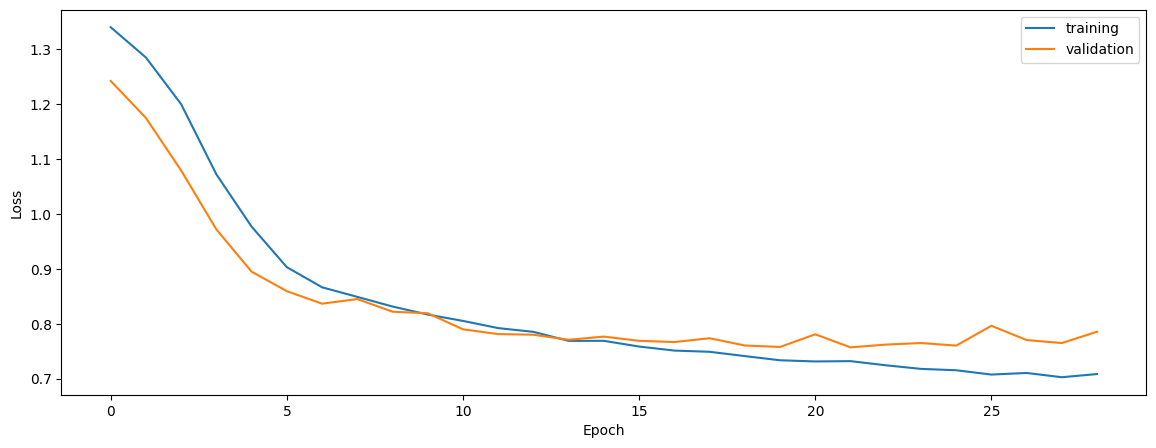

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.7059669936877329
0.7104399741824441
0.7117708651454998


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

native
0.7059669936877329
0.7104399741824441
0.7117708651454998


In [9]:
print('normalized')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.7032764011265858
0.7072285179887776
0.7175478491567179


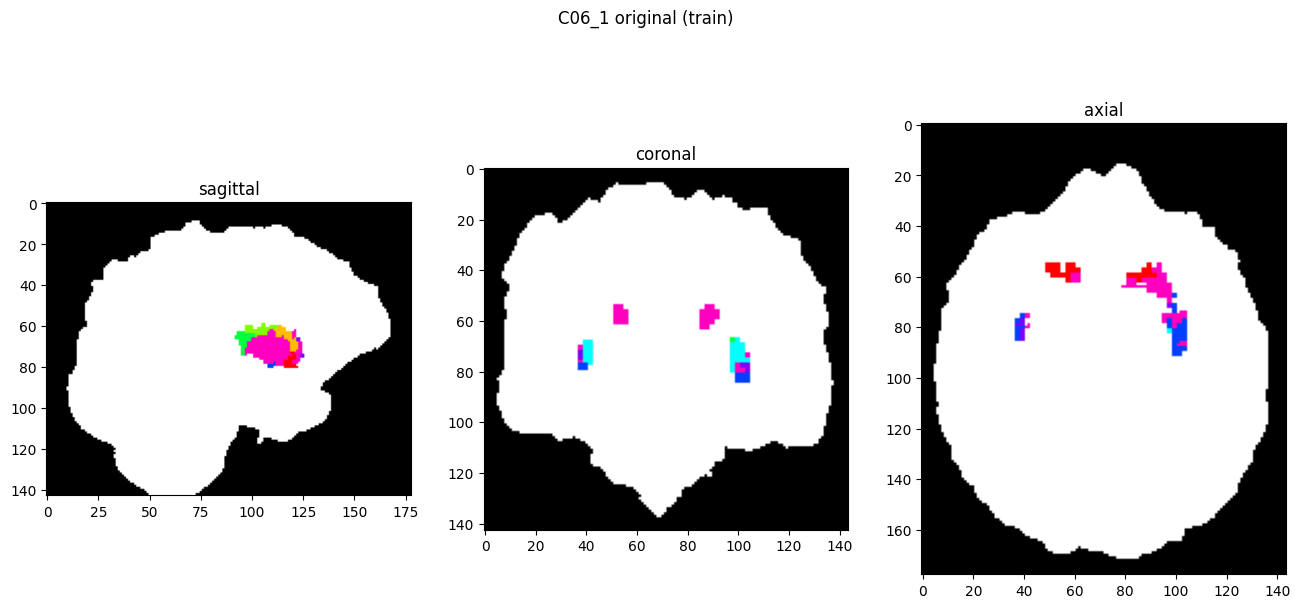

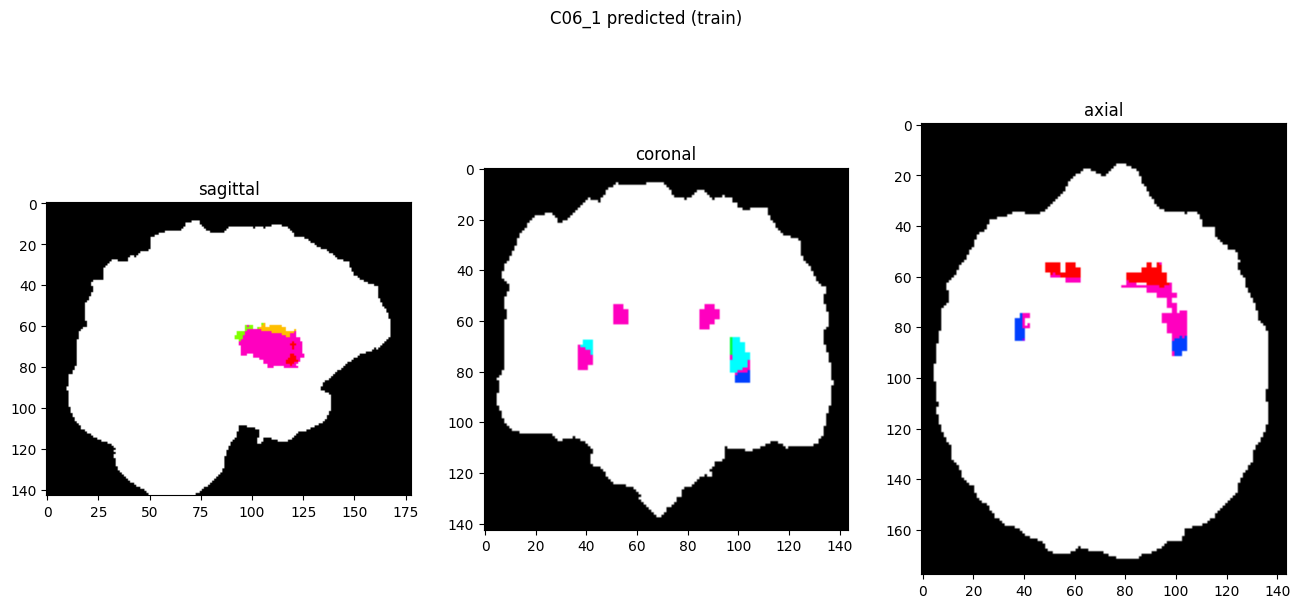

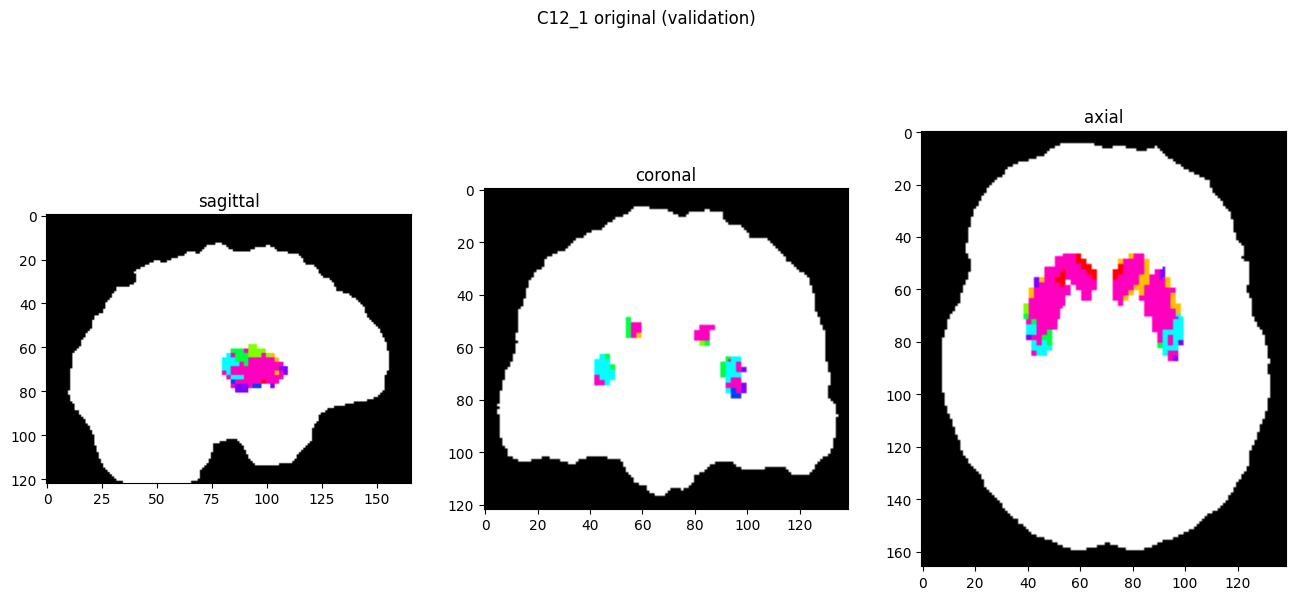

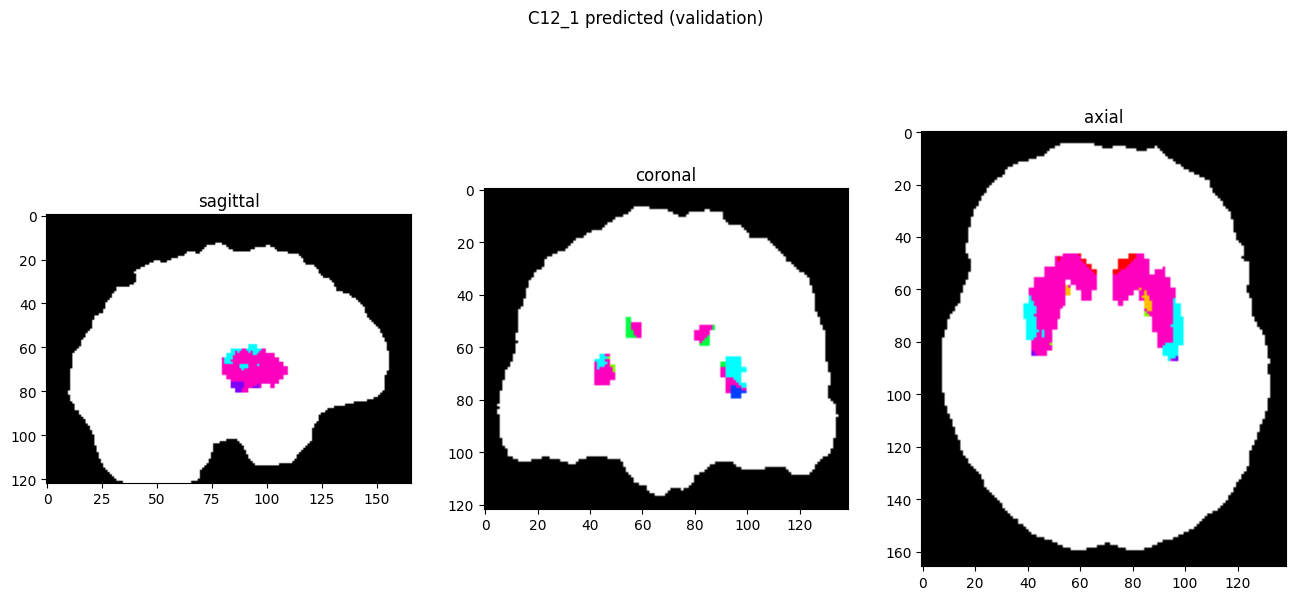

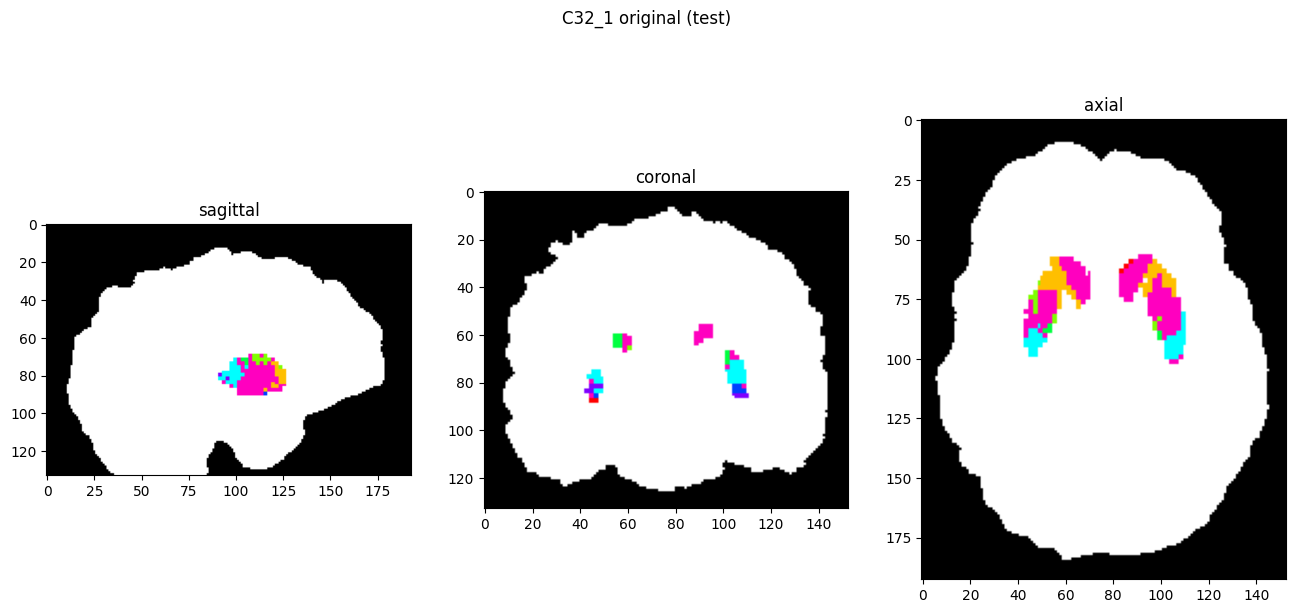

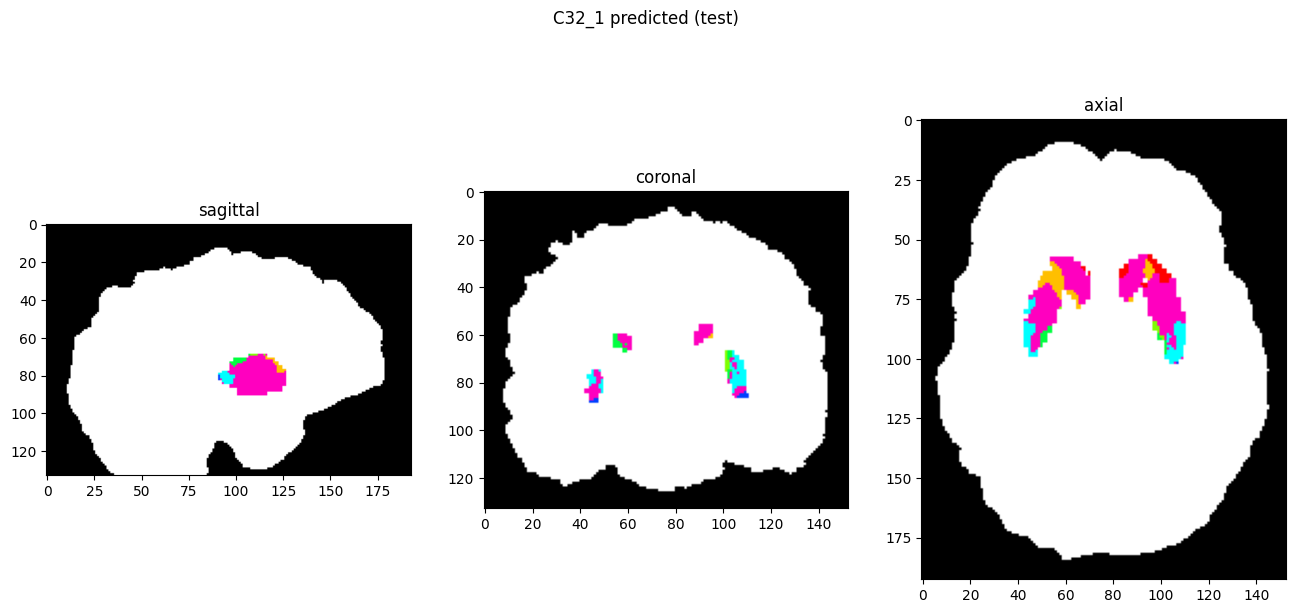

In [10]:
showResults(model, gen, threshold=0)